# 2 - modéliser
---

**imports des librairies utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**A ] une approche non supervisée : LDA**

**imports des données**

In [2]:
lda_posts_body_feature_names = np.load("data/lda_posts_body_feature_names.npy", allow_pickle=True)
lda_posts_body_tfidf = np.load("data/lda_posts_body_tfidf.npy" , allow_pickle=True, ).item()
lda_posts_body_tf = np.load("data/lda_posts_body_tf.npy" , allow_pickle=True, ).item() 

In [3]:
lda_posts_body_tfidf 

<240397x31421 sparse matrix of type '<class 'numpy.float64'>'
	with 9928445 stored elements in Compressed Sparse Row format>

In [4]:
lda_posts_body_tf

<240397x31421 sparse matrix of type '<class 'numpy.int64'>'
	with 9928445 stored elements in Compressed Sparse Row format>

**modélisation lda**

In [5]:
random_state=42

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=20,random_state=random_state).fit(lda_posts_body_tfidf)

In [7]:
# affiche les 10 mots les plus importants par topics
def display_topics(lda, feature_names, nb_tag):
    for x, topic in enumerate(lda.components_):
        print("--------------------------------------------")
        print(f"Topic {x}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1][:nb_tag]]))
        print("--------------------------------------------")

In [8]:
display_topics(lda, lda_posts_body_feature_names, 10)

--------------------------------------------
Topic 0:
user session login application password email page pdf web authentication
--------------------------------------------
--------------------------------------------
Topic 1:
database data sql table tables db entity server use way
--------------------------------------------
--------------------------------------------
Topic 2:
use good know one net code web looking question application
--------------------------------------------
--------------------------------------------
Topic 3:
service thread client server socket memory application data process threads
--------------------------------------------
--------------------------------------------
Topic 4:
com http www url php google example domain map index
--------------------------------------------
--------------------------------------------
Topic 5:
page form asp button user function javascript control ajax event
--------------------------------------------
----------------------

**B] une approche supervisée : Multi-label classification**

**imports des données**

In [9]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)

In [10]:
#pd.set_option('display.max_colwidth', 500)

In [11]:
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
# if no title and no body
multi_posts = multi_posts.dropna()

In [12]:
multi_posts.head(5)

body_title  asp  css  database  \
0  absolutely positioned div containing several c...    0    1         0   
1  given datetime representing person birthday ca...    0    0         0   
2  standard way web server able determine user ti...    0    0         0   
3  difference math floor math truncate net   diff...    0    0         0   
4  expose linq query asmx web service usually bus...    0    0         0   

   html  iphone  java  javascript  jquery  mvc  ...  net  php  python  ruby  \
0     1       0     0           0       0    0  ...    0    0       0     0   
1     0       0     0           0       0    0  ...    1    0       0     0   
2     1       0     0           0       0    0  ...    0    0       0     0   
3     0       0     0           0       0    0  ...    1    0       0     0   
4     0       0     0           0       0    0  ...    1    0       0     0   

   server  sql  studio  visual  web  windows  
0       0    0       0       0    0        0  
1       0    0       0       0    0        0  
2       0    0       0       0    0        0  
3       0    0       0       0    0        0  
4       0    0       0       0    1        0  

[5 rows x 21 columns]

**Fonctions scorer - metrics - divers**

In [13]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix , confusion_matrix

def jaccard(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    jaccard = []
    thresholds = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        jaccard.append(jaccard_score(y_pred_class,y_true,average="weighted"))
        thresholds.append(i)
    return jaccard , thresholds

def neg_hamming_loss(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    neg_hamming_loss = []
    thresholds = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        neg_hamming_loss.append(-1*hamming_loss(y_pred_class,y_true))
        thresholds.append(i)
    return neg_hamming_loss , thresholds

def scorer_jaccard(y_true, y_score):
    score , thresholds = jaccard(y_true, y_score)
    return score[np.argmax(score)]


def scorer_neg_hamming_loss(y_true, y_score): 
    score , thresholds = neg_hamming_loss(y_true, y_score)
    return score[np.argmax(score)]

def get_metrics(y_true, y_score, index , decimals=4):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    dict_metrics = {}
    dict_metrics['neg_hamming_loss'] = scorer_neg_hamming_loss(y_true, y_score)
    #dict_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    dict_metrics['jaccard'] = scorer_jaccard(y_true, y_score)
    #dict_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    #dict_metrics['aupr'] = average_precision_score(y_true, probs, average='weighted')
    #dict_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    #dict_metrics['auroc'] = roc_auc_score(y_true, probs, average="weighted")
    metrics = pd.DataFrame(dict_metrics, index=[index])
    return metrics.round(decimals=decimals)

def multi_confusion_matrix(y_true, y_score, threshold=None):
    
    if threshold is None:
        threshold = 0.5
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    ml_confusion_matrix=[]
    for i in range(0,len(labels)):
        y_pred_class = np.array(probs[:, i]) > threshold
        ml_confusion_matrix.append(confusion_matrix(y_true[:,i], y_pred_class))
    return ml_confusion_matrix

def get_threshold(y_true,y_score):
    score, thresholds = neg_hamming_loss(y_true, y_score)
    return thresholds[np.argmax(score)]

**Fonctions de visualisations de la classification**

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay

def plot_auroc(y_true, y_score, labels, data_name="", threshold=None):
    
    print(f"courbe ROC pour chaques étiquettes : {data_name}")
    print("----------------------------------")
    
    if threshold is not None :
        ml_confusion_matrix = multi_confusion_matrix(y_true, y_score, threshold)
    
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], probs[:, i])
        ax.plot(fpr[i], tpr[i])
        if threshold is not None :
            tn, fp, fn, tp  = ml_confusion_matrix[i].flatten()
            ax.scatter(fp/(fp+tn), tp/(tp+fn), marker='o', color='red', label='Best')
        ax.set_xlabel('fpr')
        ax.set_ylabel('tpr')
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlim([-0.05, 1.05])
        ax.set_title(labels[i])
    plt.show()    


        
def plot_aupr(y_true, y_score, labels, data_name="", threshold=None):

    print(f"courbe precision-recall pour chaques étiquettes : {data_name}")
    print("-----------------------------------------------")
    
    if threshold is not None :
        ml_confusion_matrix = multi_confusion_matrix(y_true, y_score, threshold)
    
    precision = dict()
    recall = dict()
    thresholds = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true[:, i], probs[:, i])
        
        ax.plot(recall[i], precision[i])
        if threshold is not None :
            tn, fp, fn, tp  = ml_confusion_matrix[i].flatten()
            ax.scatter(tp/(tp+fn), tp/(tp+fp), marker='o', color='red', label='Best')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.05])
        ax.set_title(labels[i])
    
    plt.show()
    

        
def plot_matconf(y_true, y_score, labels, data_name="", threshold=0.5):
    
    print(f"matrice de confusion : {data_name}")
    print("--------------------")
    
    ml_confusion_matrix = multi_confusion_matrix(y_true, y_score, threshold)
 
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ConfusionMatrixDisplay(confusion_matrix=ml_confusion_matrix[i]).plot(ax=ax , colorbar=None , cmap=plt.cm.Blues)
        ax.set_title(labels[i])
    plt.show()
        

def plot_accuracy(y_true, y_score, labels, data_name="", threshold=None):
    
    print(f"courbe accuracy pour chaques étiquettes : {data_name}")
    print("---------------------------------------")
    
    def __plot_average_accuracy(thresholds,average_accuracy, threshold):
        plt.figure()
        plt.plot(thresholds, average_accuracy)
        if threshold is not None :
            best_threshold = round(threshold * len(thresholds))
            plt.scatter(thresholds[best_threshold], average_accuracy[best_threshold], marker='o', color='red', label='Best')
        plt.xlabel('Thresholds')
        plt.ylabel('average weighted accuracy')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('average weighted accuracy')
        plt.show()
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    average_accuracy = np.zeros(size)
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    weights = np.sum(y_true, axis=0)
    weights = weights / np.sum(weights)
    
    
    for j, ax in enumerate(axes):
        accuracy = []
        thresholds = []
        for i in np.linspace(0, 1.0, num=size):
            y_pred_class = np.array(probs[:, j]) > i
            accuracy.append(accuracy_score(y_pred_class,y_true[:, j]))
            thresholds.append(i)
        average_accuracy = np.sum([average_accuracy, np.array(accuracy)*weights[j]], axis=0)

        ax.plot(thresholds, accuracy)
        if threshold is not None :
            best_threshold = round(threshold * len(thresholds))
            ax.scatter(thresholds[best_threshold], accuracy[best_threshold], marker='o', color='red', label='Best')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Accuracy_score')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.05])
        ax.set_title(labels[j])
            
    #average_accuracy = (average_accuracy/size)
    
    plt.show()
    print("with threshold = ",thresholds[np.argmax(average_accuracy)])
    print("best average accuracy weighted score = ", average_accuracy[np.argmax(average_accuracy)])
    
    __plot_average_accuracy(thresholds,average_accuracy.tolist(), threshold=threshold)
    
def plot_neg_hamming_loss(y_true, y_score, data_name="", threshold=None):
    
    print(f"courbe neg hamming loss : {data_name}")
    print("-----------------------")
    
    score , thresholds = neg_hamming_loss(y_true, y_score)
    
    plt.figure()
    plt.plot(thresholds, score)
    if threshold is not None :
        best_threshold = round(threshold * len(thresholds))
        plt.scatter(thresholds[best_threshold], score[best_threshold], marker='o', color='red', label='Best')
    plt.xlabel('Thresholds')
    plt.ylabel('neg_hamming_loss')
    plt.ylim([-1.05, 0])
    plt.xlim([0.0, 1.05])
    plt.title('neg_hamming_loss')
    
    
    print("with threshold = ",thresholds[np.argmax(score)])
    print("best neg_hamming_loss = ", score[np.argmax(score)])
    
    plt.show()
    
def plot_jaccard(y_true, y_score, data_name="", threshold=None):
    
    print(f"courbe jaccard : {data_name}")
    print("--------------")
    
    score , thresholds = jaccard(y_true, y_score)

    plt.figure()
    plt.plot(thresholds, score)
    if threshold is not None :
        best_threshold = round(threshold * len(thresholds))
        plt.scatter(thresholds[best_threshold], score[best_threshold], marker='o', color='red', label='Best')
        
    plt.xlabel('Thresholds')
    plt.ylabel('jaccard_score')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Jaccard score')
    
    print("with threshold = ",thresholds[np.argmax(score)])
    print("best jaccard score = ", score[np.argmax(score)])
    
    plt.show()

def plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=None):

    plot_neg_hamming_loss(y_train,y_score_train, data_name="train", threshold=threshold)
    plot_neg_hamming_loss(y_val,y_score_val, data_name="val", threshold=threshold)
    plot_auroc(y_train,y_score_train, data_name="train", threshold=threshold,  labels=labels)
    plot_auroc(y_val,y_score_val, data_name="val", threshold=threshold, labels=labels)
    plot_aupr(y_train,y_score_train, data_name="train", threshold=threshold, labels=labels)
    plot_aupr(y_val,y_score_val, data_name="val", threshold=threshold, labels=labels)
    plot_accuracy(y_train,y_score_train, data_name="train", threshold=threshold, labels=labels)
    plot_accuracy(y_val,y_score_val, data_name="val", threshold=threshold, labels=labels)
    plot_jaccard(y_train,y_score_train, data_name="train", threshold=threshold)
    plot_jaccard(y_val,y_score_val, data_name="val", threshold=threshold)
    plot_matconf(y_train, y_score_train, data_name="train", threshold=threshold, labels=labels)
    plot_matconf(y_val, y_score_val, data_name="val", threshold=threshold, labels=labels)

**parametres globaux**

In [15]:
import random

random_state=42
scoring= make_scorer(scorer_neg_hamming_loss, needs_proba=True)
labels = tags.columns.tolist()

**echantillonages**

In [16]:
multi_posts = multi_posts.sample(5000,random_state=random_state)

In [17]:
multi_posts

body_title  asp  css  database  \
33023   according mysql manual table comments limited ...    0    0         0   
135505  lamp server fairly busy cpu usage hovers aroun...    0    0         0   
88898   simple sql server database use conversions bas...    0    0         1   
33429   datetime store date mysql column mysqli prepar...    0    0         0   
89391   link site strictly javascript users optionally...    0    0         0   
...                                                   ...  ...  ...       ...   
86327   got form repeater webpage number parameter tel...    1    0         0   
585     best way make linked list java   create linked...    0    0         0   
63975   asp net dynamic data website set application s...    1    0         0   
140155  processing treeview directories files user sel...    0    0         0   
58184   error making installer program images inside d...    0    0         0   

        html  iphone  java  javascript  jquery  mvc  ...  net  php  python  \
33023      0       0     0           0       0    0  ...    0    0       0   
135505     0       0     0           0       0    0  ...    0    1       0   
88898      0       0     0           0       0    0  ...    0    0       0   
33429      0       0     0           0       0    0  ...    0    1       0   
89391      0       0     0           1       0    0  ...    0    0       0   
...      ...     ...   ...         ...     ...  ...  ...  ...  ...     ...   
86327      0       0     0           0       0    0  ...    1    0       0   
585        0       0     1           0       0    0  ...    0    0       0   
63975      0       0     0           0       0    0  ...    1    0       0   
140155     0       0     0           0       0    0  ...    1    0       0   
58184      0       0     0           0       0    0  ...    1    0       0   

        ruby  server  sql  studio  visual  web  windows  
33023      0       0    0       0       0    0        0  
135505     0       0    0       0       0    0        0  
88898      0       1    1       0       0    0        0  
33429      0       0    0       0       0    0        0  
89391      0       0    0       0       0    0        0  
...      ...     ...  ...     ...     ...  ...      ...  
86327      0       0    0       0       0    0        0  
585        0       0    0       0       0    0        0  
63975      0       0    0       0       0    0        0  
140155     0       0    0       0       0    0        0  
58184      0       0    0       0       0    0        0  

[5000 rows x 21 columns]

**séparation du jeu de données**

In [18]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(multi_posts, random_state=random_state, test_size=0.2, shuffle=True)
validation, test = train_test_split(validation, random_state=random_state, test_size=0.5, shuffle=True)

In [19]:
X_train, y_train = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_val, y_val = validation['body_title'], validation.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_test, y_test = test['body_title'], test.iloc[:,1:].to_numpy(copy=True, dtype='int32')

**extraction de caractéristiques - tfidf - pour classification**

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

multi_tfidf_vectorizer = TfidfVectorizer(max_df= 0.5, min_df=8)

X_train_tfidf = multi_tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = multi_tfidf_vectorizer.transform(X_val)
X_test_tfidf = multi_tfidf_vectorizer.transform(X_test)

In [21]:
X_val_tfidf.shape

(500, 2990)

**transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [22]:
"""from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_tfidf)

X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_val_tfidf_scaled = scaler.transform(X_val_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)"""

'from sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X_train_tfidf)\n\nX_train_tfidf_scaled = scaler.transform(X_train_tfidf)\nX_val_tfidf_scaled = scaler.transform(X_val_tfidf)\nX_test_tfidf_scaled = scaler.transform(X_test_tfidf)'

**modélisation et optimisation principale**   
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

In [23]:
from sklearn.utils.multiclass import is_multilabel

print(is_multilabel(y_train))

True


**rapport**

In [24]:
#init le rapport
classification_report = pd.DataFrame()

**0) classification baseline**

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier

#“stratified”: generates predictions by respecting the training set’s class distribution.

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier = MultiOutputClassifier(dummy_classifier).fit(X_train_tfidf, y_train)

In [26]:
y_score_train = dummy_classifier.predict_proba(X_train_tfidf)
y_pred_train = dummy_classifier.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'dummy_classifier_on_train'))

In [27]:
y_score_val = dummy_classifier.predict_proba(X_val_tfidf)
y_pred_val = dummy_classifier.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'dummy_classifier_on_val'))

courbe neg hamming loss : train
-----------------------
with threshold =  0.0
best neg_hamming_loss =  -0.07525


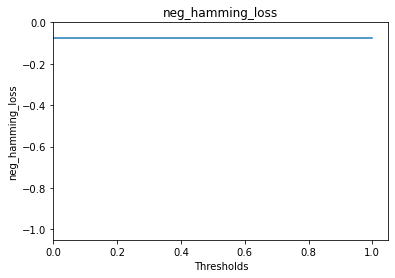

courbe neg hamming loss : val
-----------------------
with threshold =  0.0
best neg_hamming_loss =  -0.0738


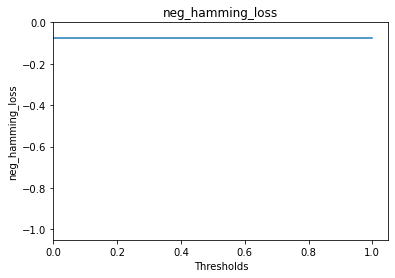

courbe ROC pour chaques étiquettes : train
----------------------------------


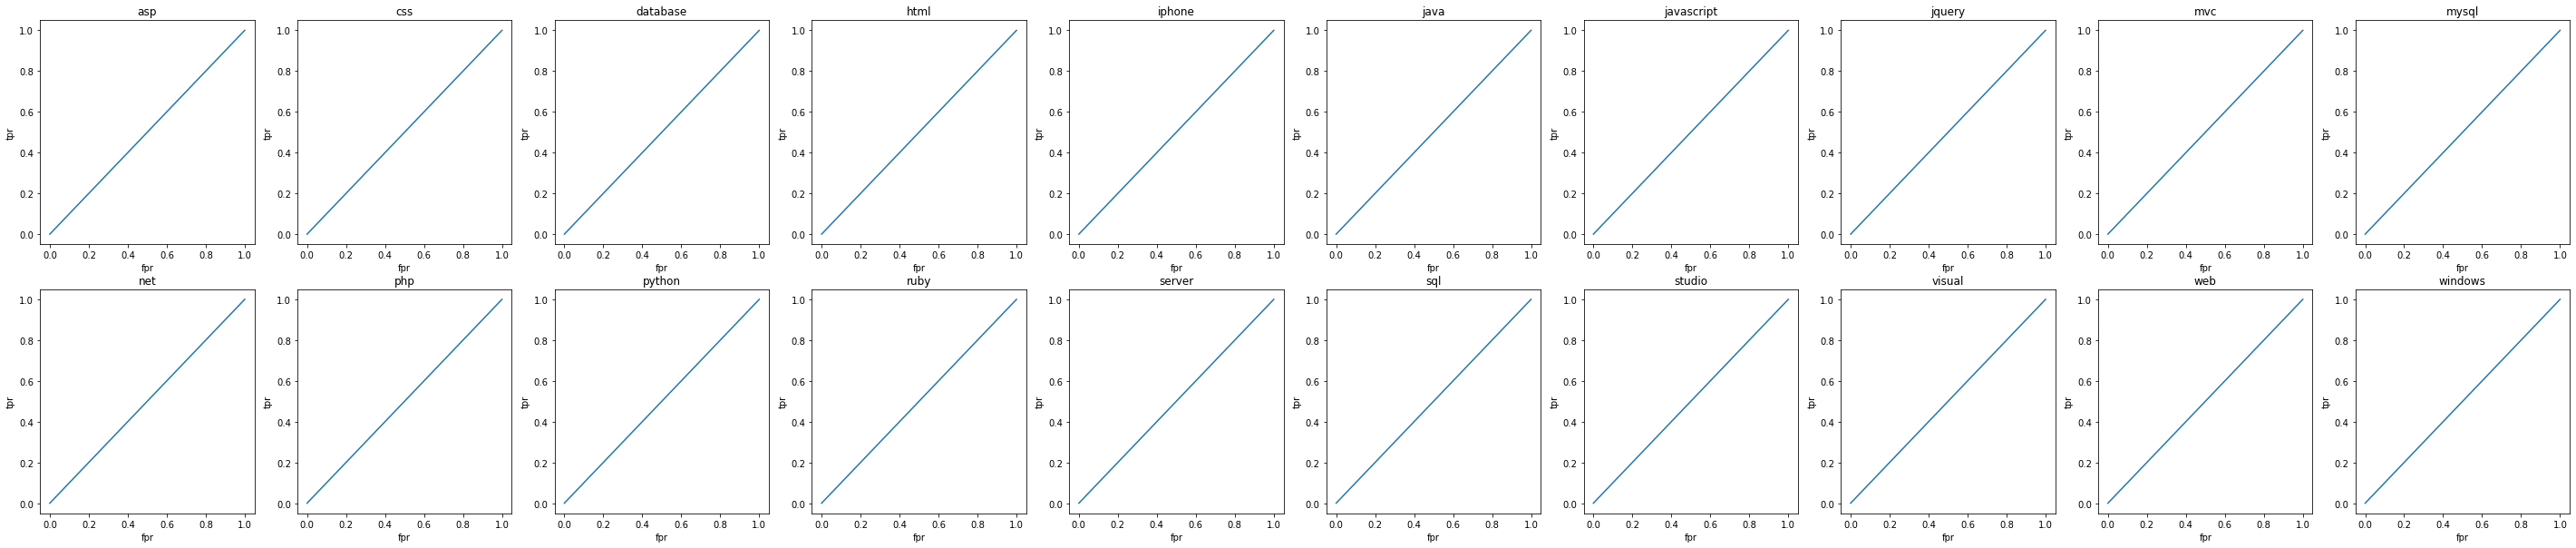

courbe ROC pour chaques étiquettes : val
----------------------------------


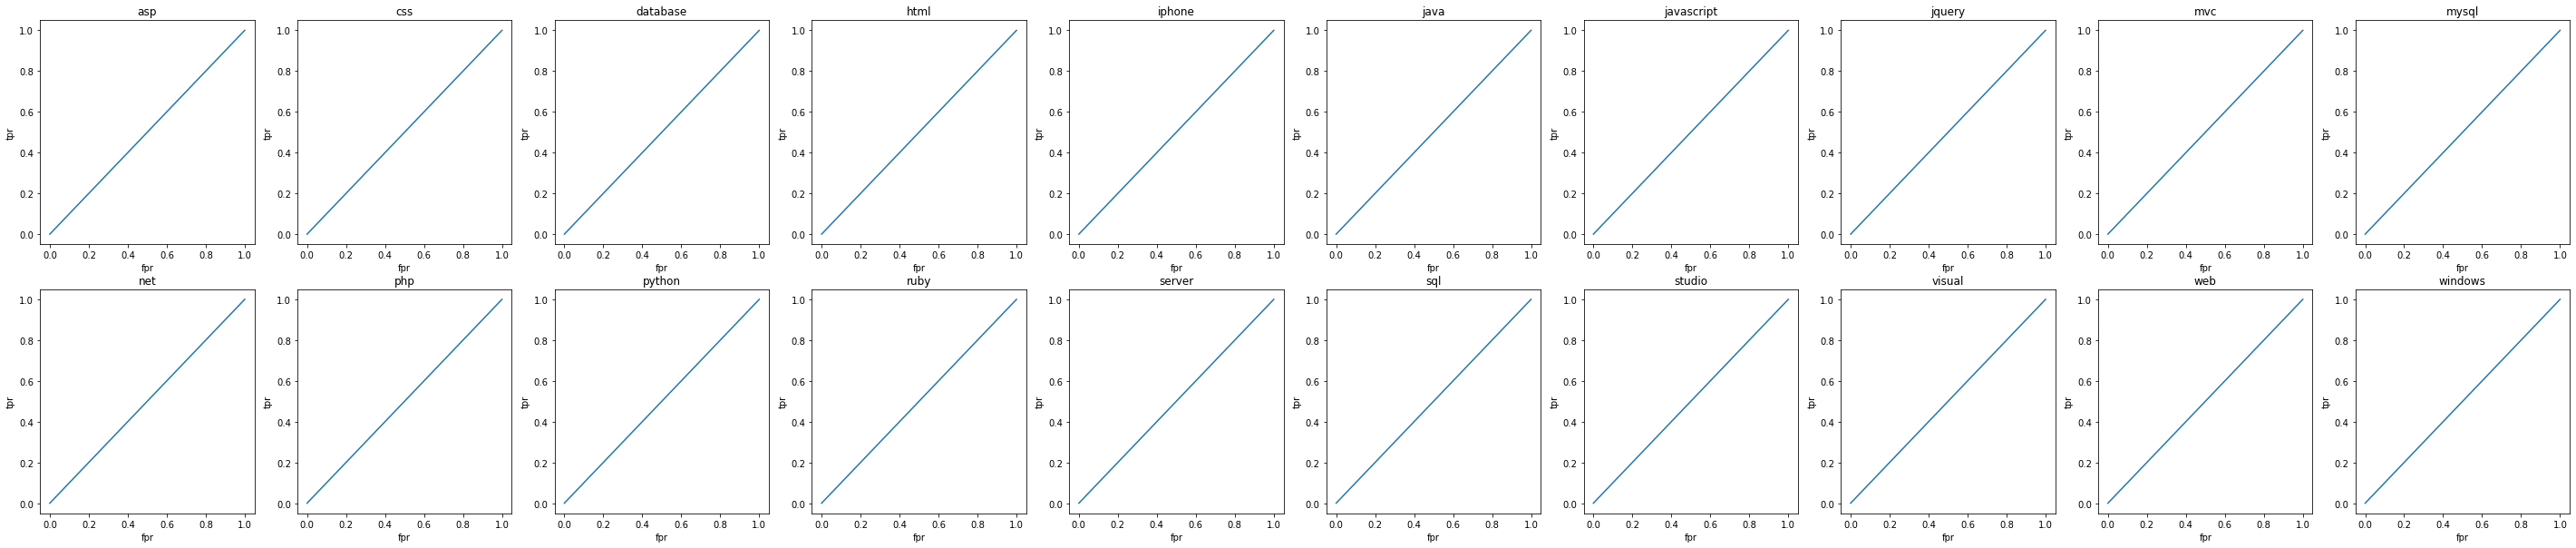

courbe precision-recall pour chaques étiquettes : train
-----------------------------------------------


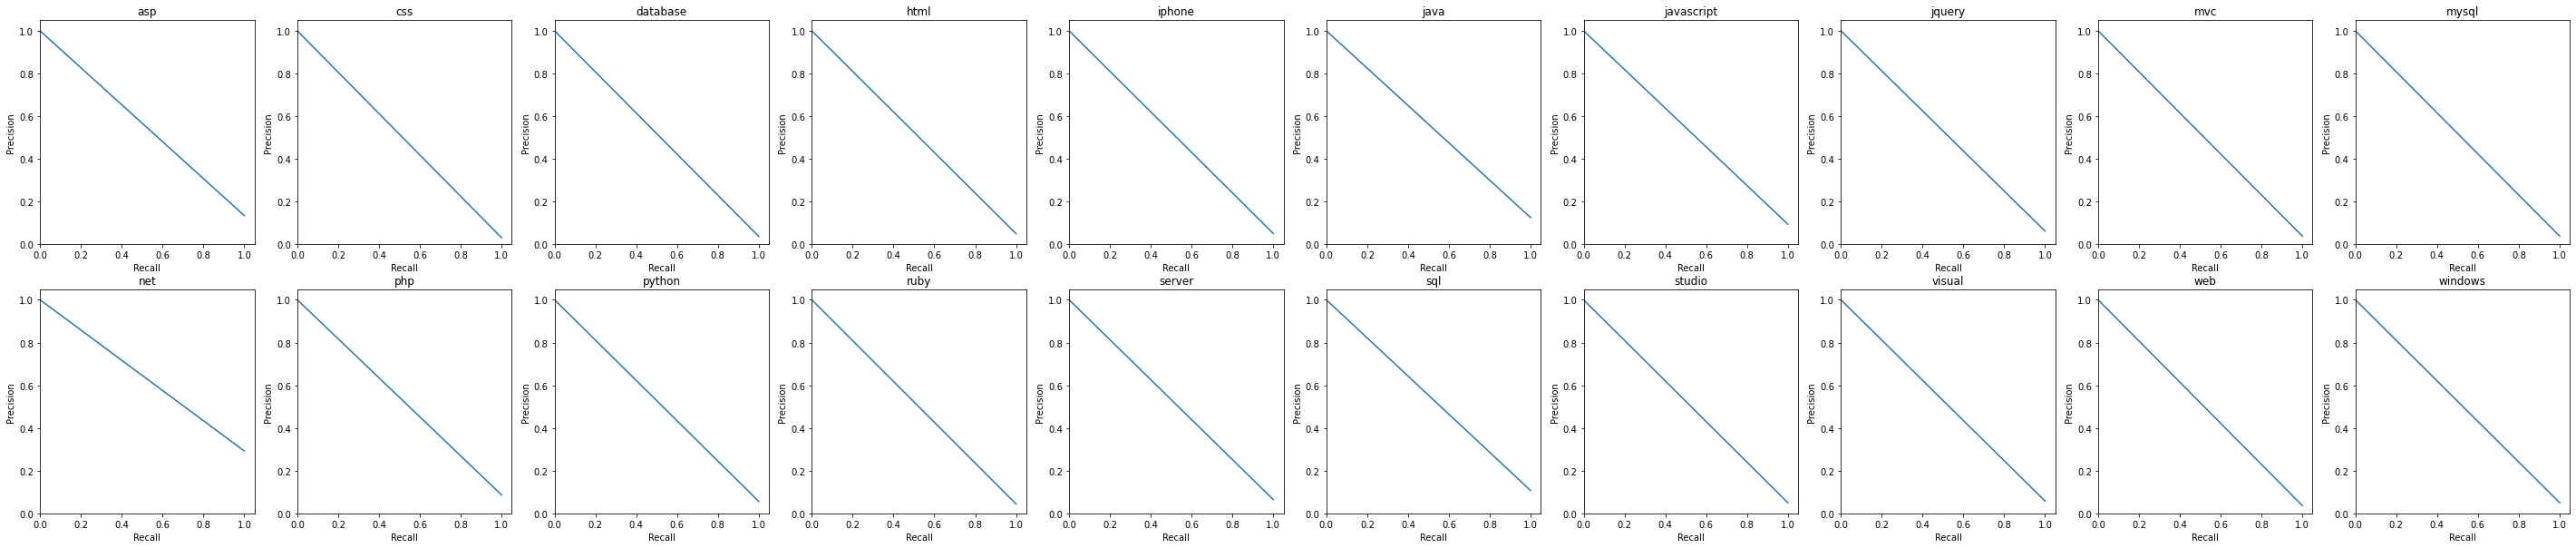

courbe precision-recall pour chaques étiquettes : val
-----------------------------------------------


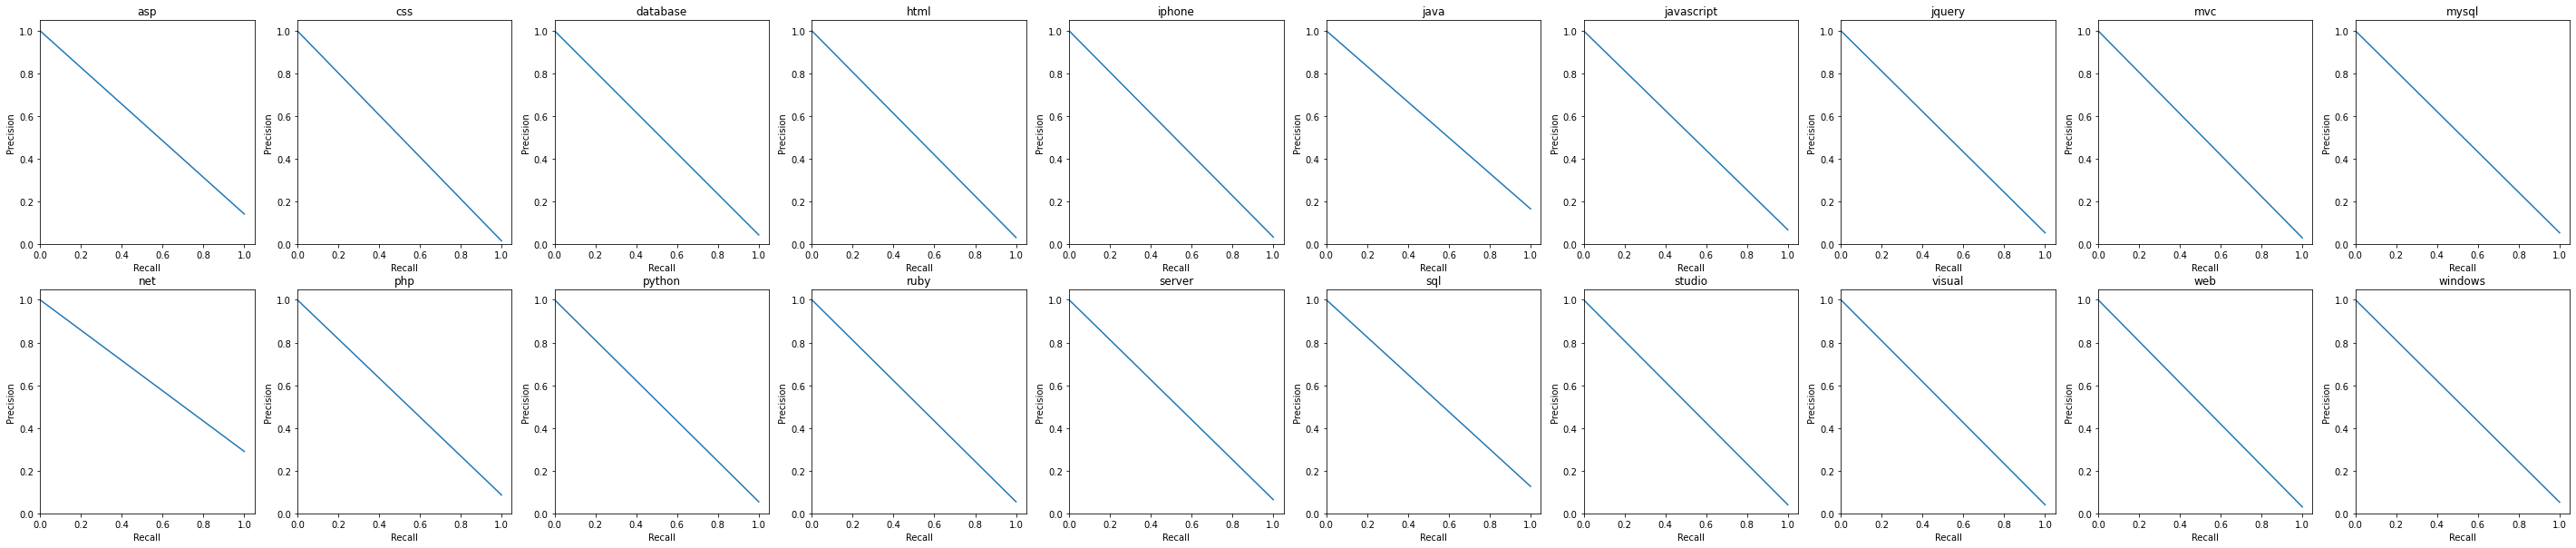

courbe accuracy pour chaques étiquettes : train
---------------------------------------


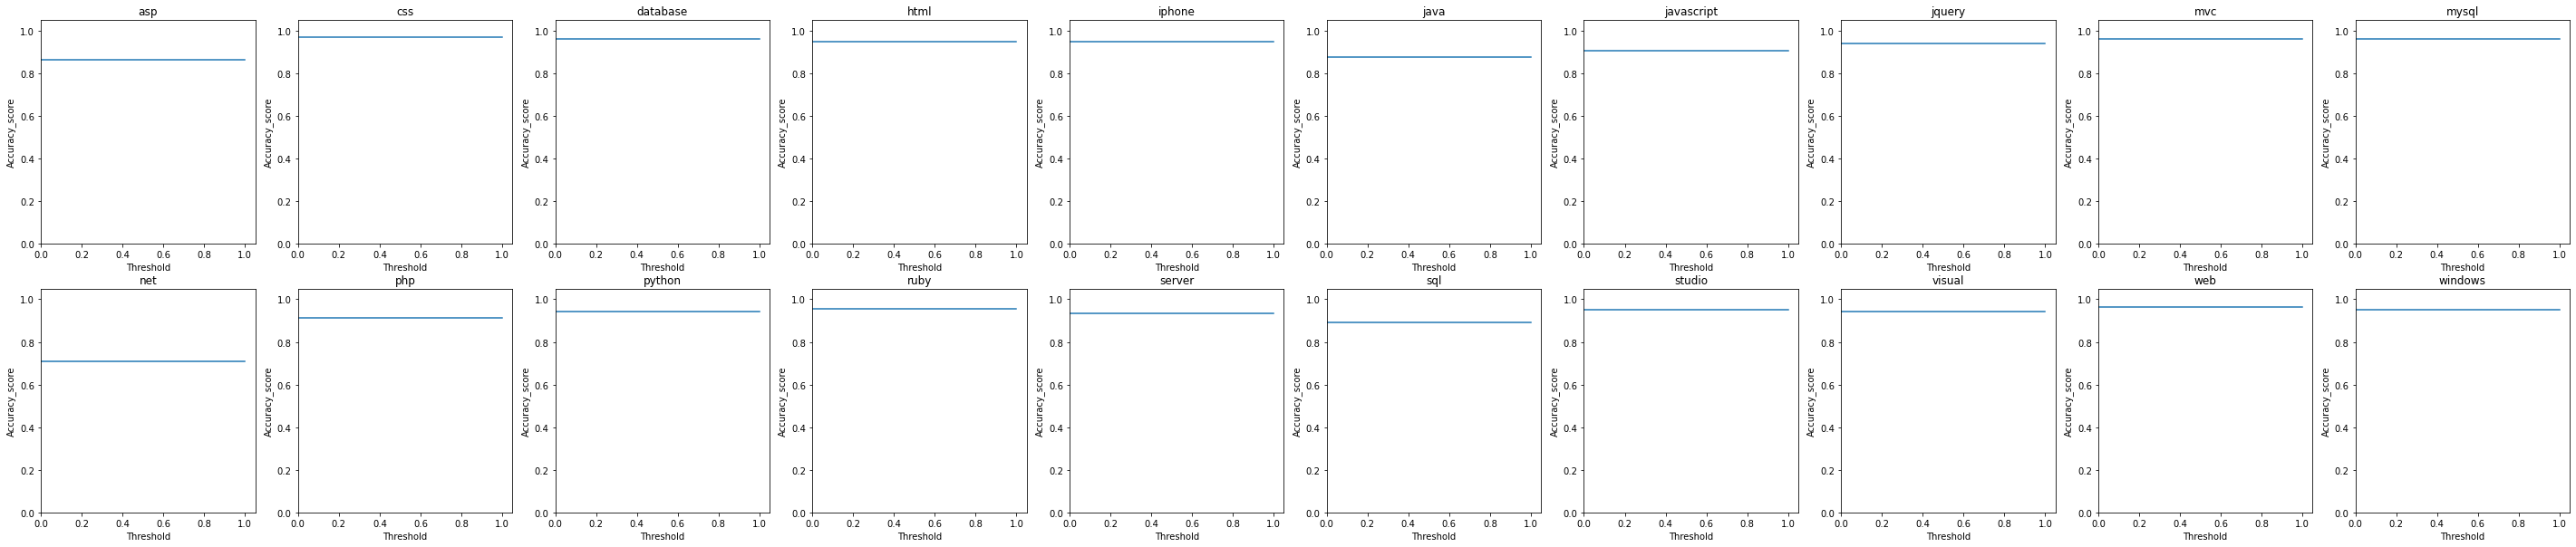

with threshold =  0.0
best average accuracy weighted score =  0.8803732558139535


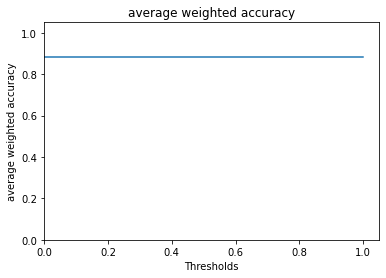

courbe accuracy pour chaques étiquettes : val
---------------------------------------


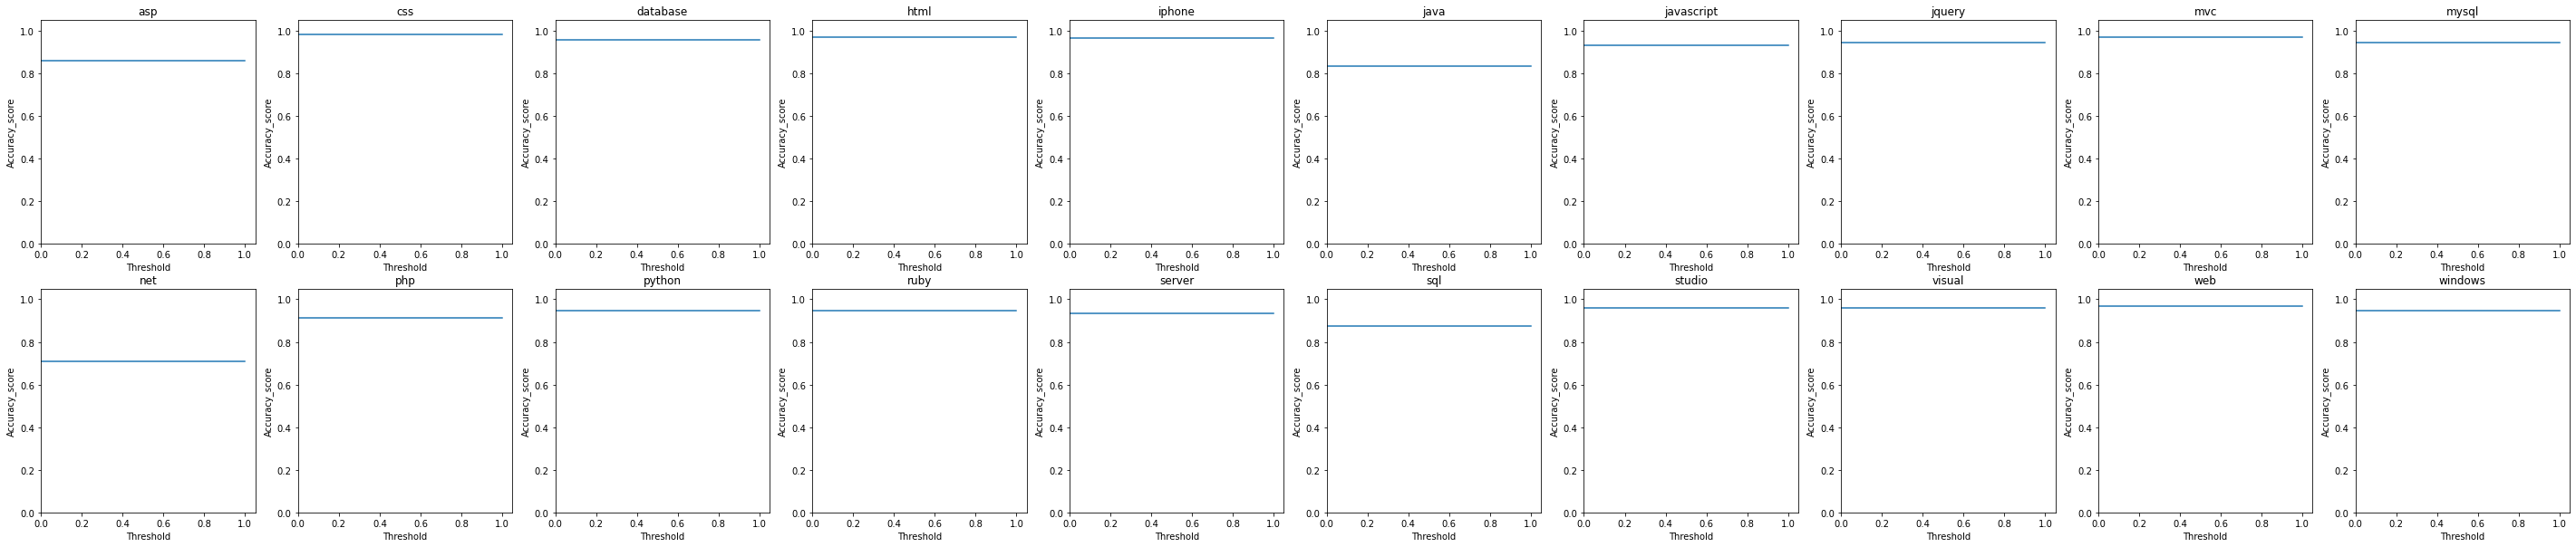

with threshold =  0.0
best average accuracy weighted score =  0.8729322493224934


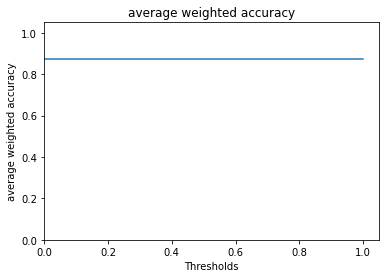

courbe jaccard : train
--------------
with threshold =  0.0
best jaccard score =  0.0


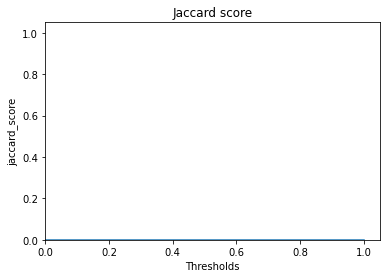

courbe jaccard : val
--------------
with threshold =  0.0
best jaccard score =  0.0


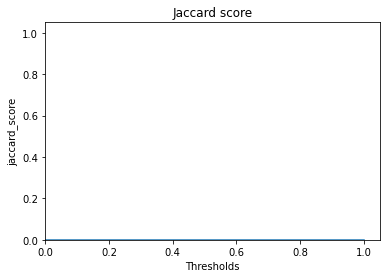

matrice de confusion : train
--------------------


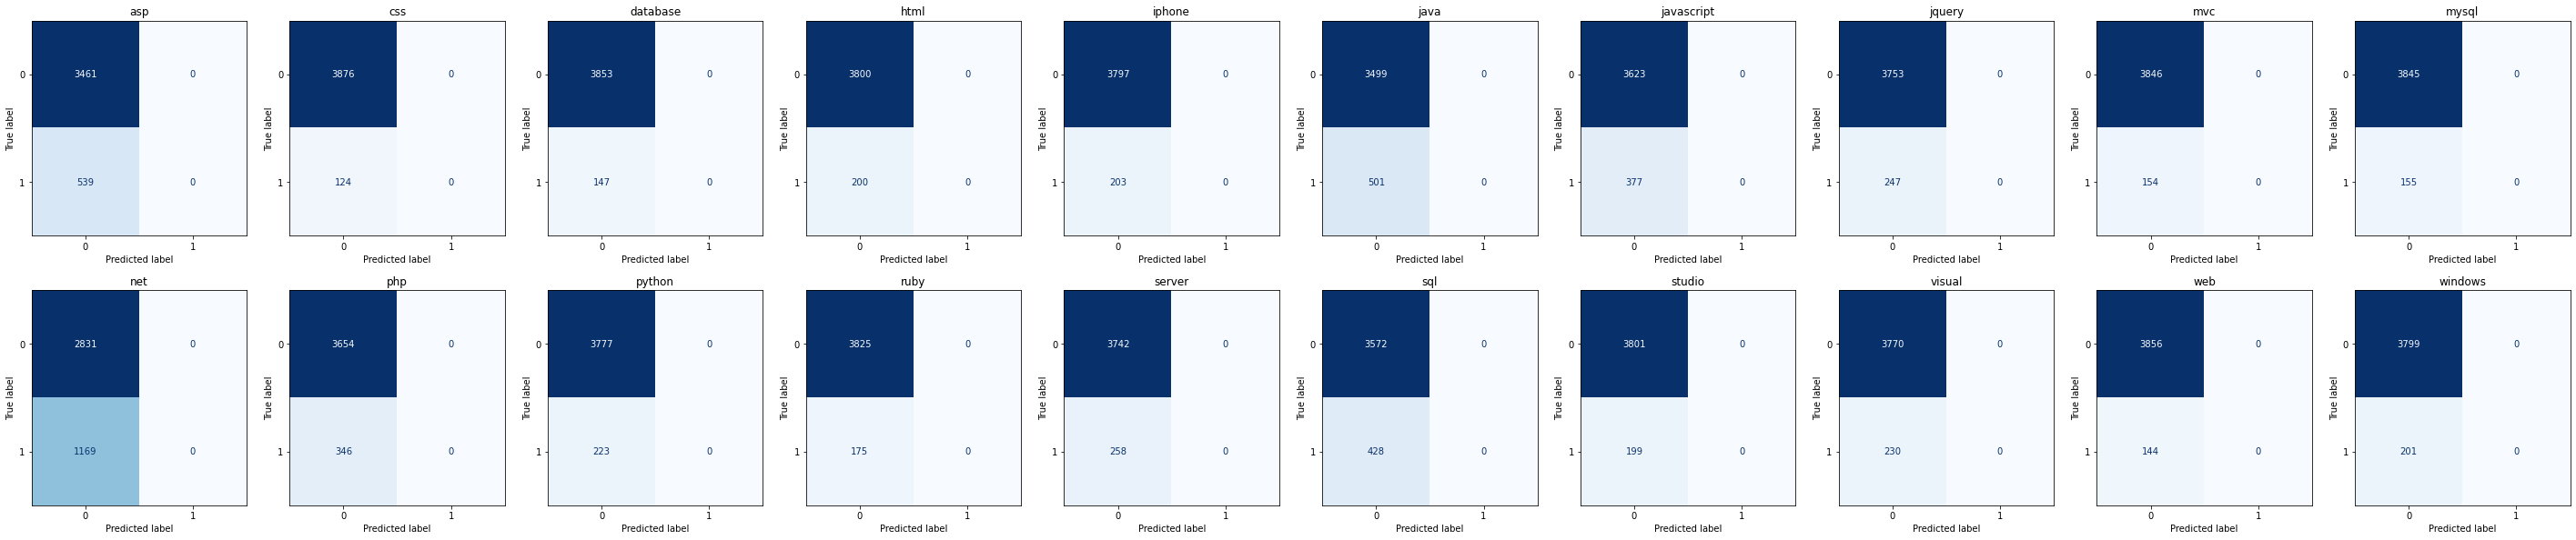

matrice de confusion : val
--------------------


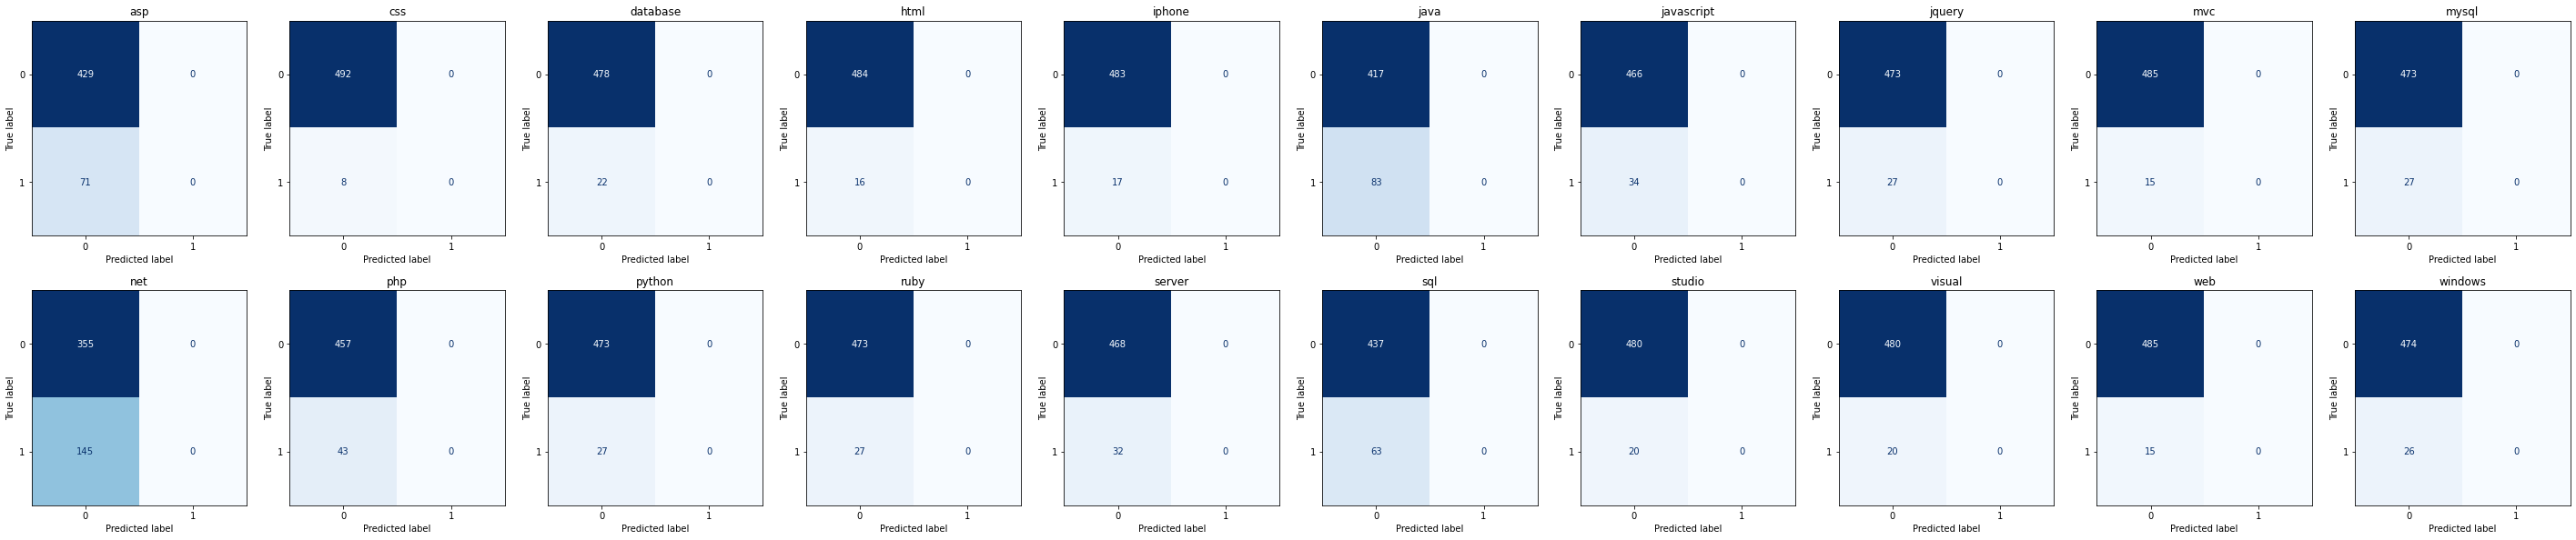

In [28]:
plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=None)

**1) classification logistic regression**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

logistic_regression = LogisticRegression()
logistic_regression = MultiOutputClassifier(logistic_regression)

n_C = 10
estimator__C = np.logspace(0, 1, n_C)

n_jobs=[4]
estimator__max_iter = [400]

hyperparameters = dict(estimator__max_iter = estimator__max_iter,
                       estimator__C = estimator__C,
                       n_jobs = n_jobs
                      )

gscv_logistic_regression = GridSearchCV(logistic_regression, hyperparameters, cv=KFold(4,shuffle=True, random_state=random_state), scoring=scoring , verbose=2)
gscv_logistic_regression.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   1.4s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   0.2s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.6681005372000588, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.6681005372000588, estimator__max_iter=400, n_jobs=4; total time=   0.3s
[CV] END estimator__C=1.668100537200058

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'estimator__max_iter': [400], 'n_jobs': [4]},
             scoring=make_scorer(scorer_neg_hamming_loss, needs_proba=True),
             verbose=2)

In [30]:
gscv_logistic_regression.best_estimator_.get_params()

{'estimator__C': 5.994842503189409,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 400,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=5.994842503189409, max_iter=400),
 'n_jobs': 4}

In [31]:
gscv_logistic_regression.best_params_

{'estimator__C': 5.994842503189409, 'estimator__max_iter': 400, 'n_jobs': 4}

In [32]:
gscv_logistic_regression.cv_results_

{'mean_fit_time': array([0.55232817, 0.30129117, 0.29274344, 0.3134256 , 0.33334833,
        0.3453033 , 0.36844862, 0.38666701, 0.43505949, 0.42939508]),
 'std_fit_time': array([0.51115487, 0.02080393, 0.00966643, 0.01843949, 0.01452099,
        0.00527188, 0.02427337, 0.01036848, 0.02098652, 0.01366105]),
 'mean_score_time': array([0.10247612, 0.10133737, 0.10578805, 0.10246813, 0.10414004,
        0.10184443, 0.10409033, 0.10185641, 0.10213596, 0.10228091]),
 'std_score_time': array([0.00122802, 0.00121582, 0.00506442, 0.00107473, 0.00242367,
        0.00080849, 0.00365061, 0.0010889 , 0.00131064, 0.00089068]),
 'param_estimator__C': masked_array(data=[1.0, 1.2915496650148839, 1.6681005372000588,
                    2.154434690031884, 2.7825594022071245,
                    3.5938136638046276, 4.641588833612778,
                    5.994842503189409, 7.742636826811269, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False

In [33]:
y_score_train = gscv_logistic_regression.predict_proba(X_train_tfidf)
y_pred_train = gscv_logistic_regression.predict(X_train_tfidf)

classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'logistic_regression_on_train'))

In [34]:
y_score_val = gscv_logistic_regression.predict_proba(X_val_tfidf)
y_pred_val = gscv_logistic_regression.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'logistic_regression_on_val'))

In [35]:
threshold = get_threshold(y_train,y_score_train) 

courbe neg hamming loss : train
-----------------------
with threshold =  0.32323232323232326
best neg_hamming_loss =  -0.0078


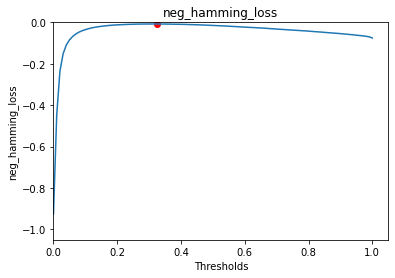

courbe neg hamming loss : val
-----------------------
with threshold =  0.31313131313131315
best neg_hamming_loss =  -0.0362


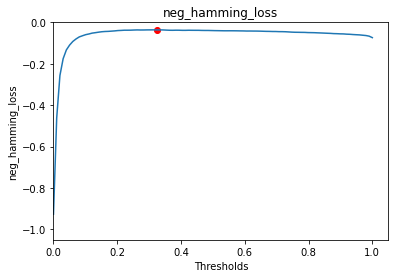

courbe ROC pour chaques étiquettes : train
----------------------------------


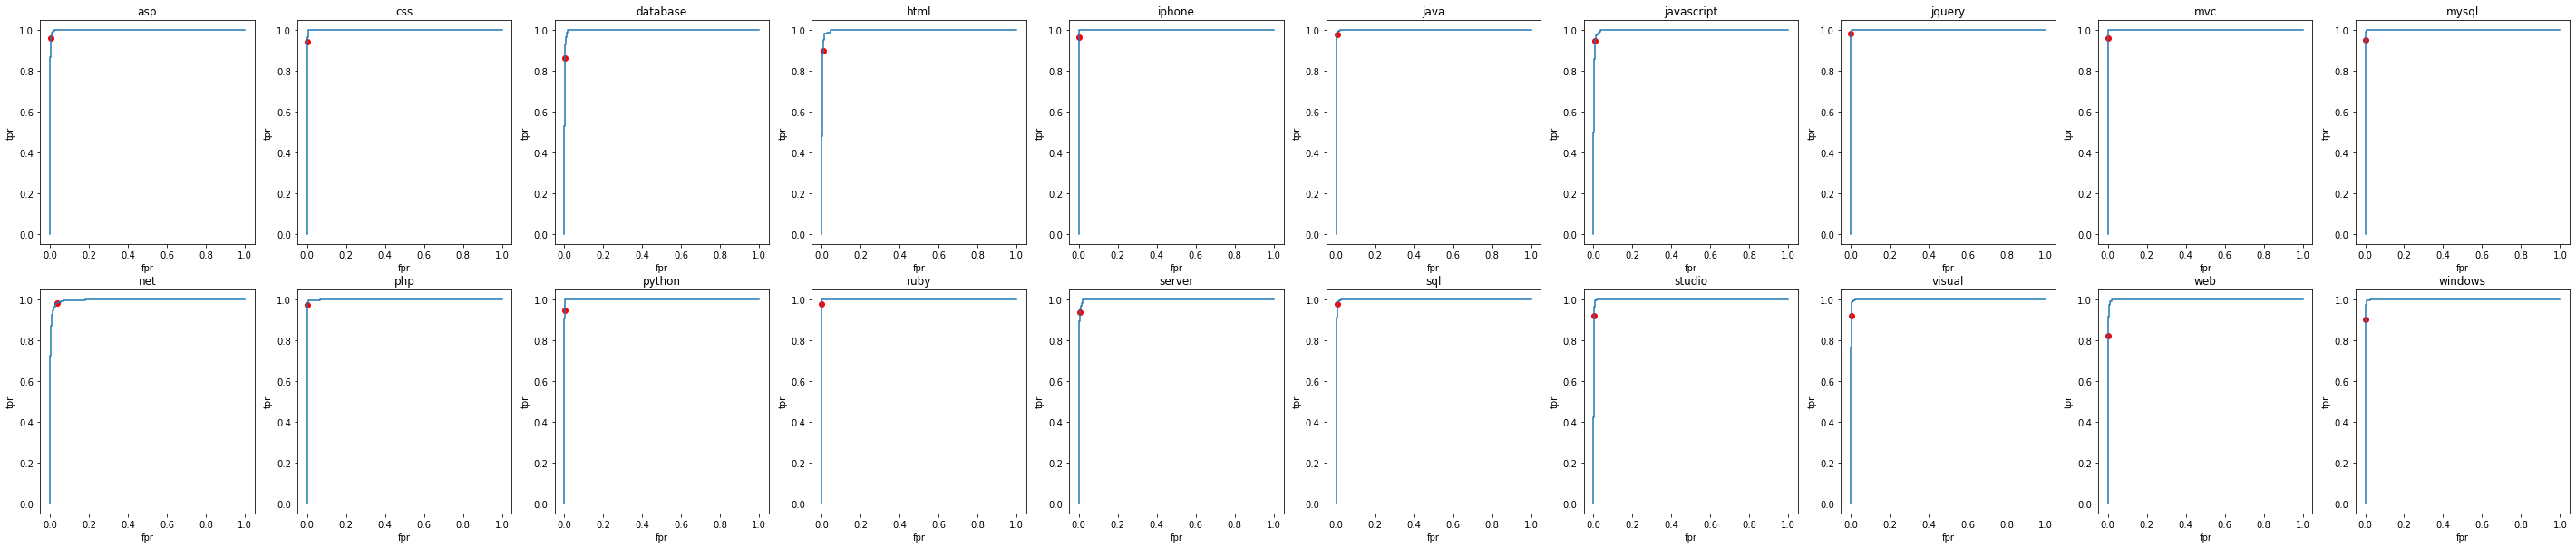

courbe ROC pour chaques étiquettes : val
----------------------------------


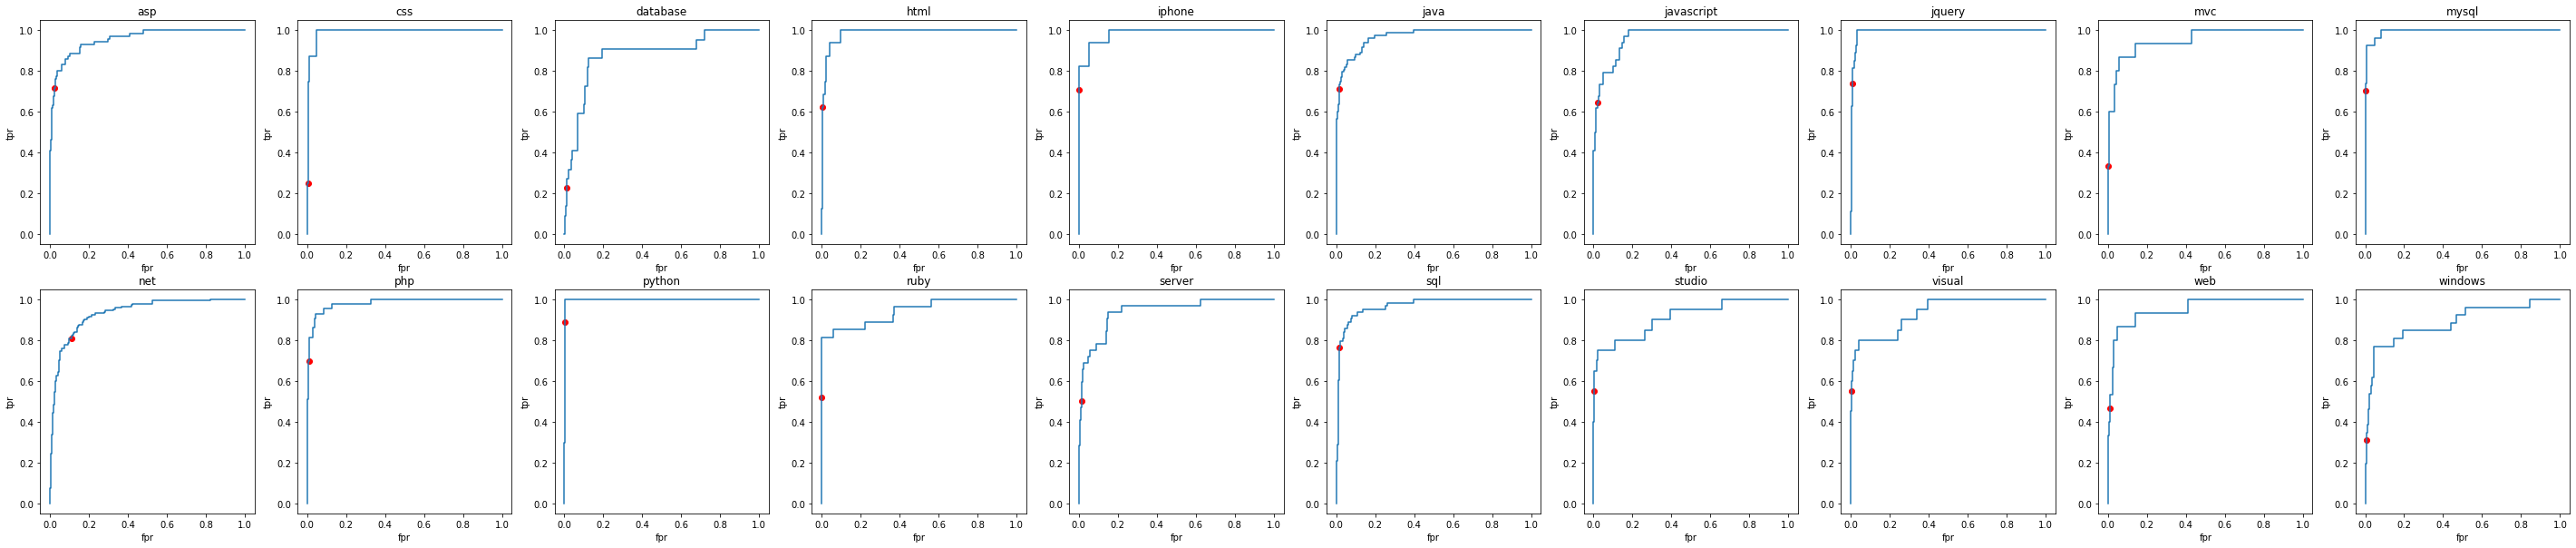

courbe precision-recall pour chaques étiquettes : train
-----------------------------------------------


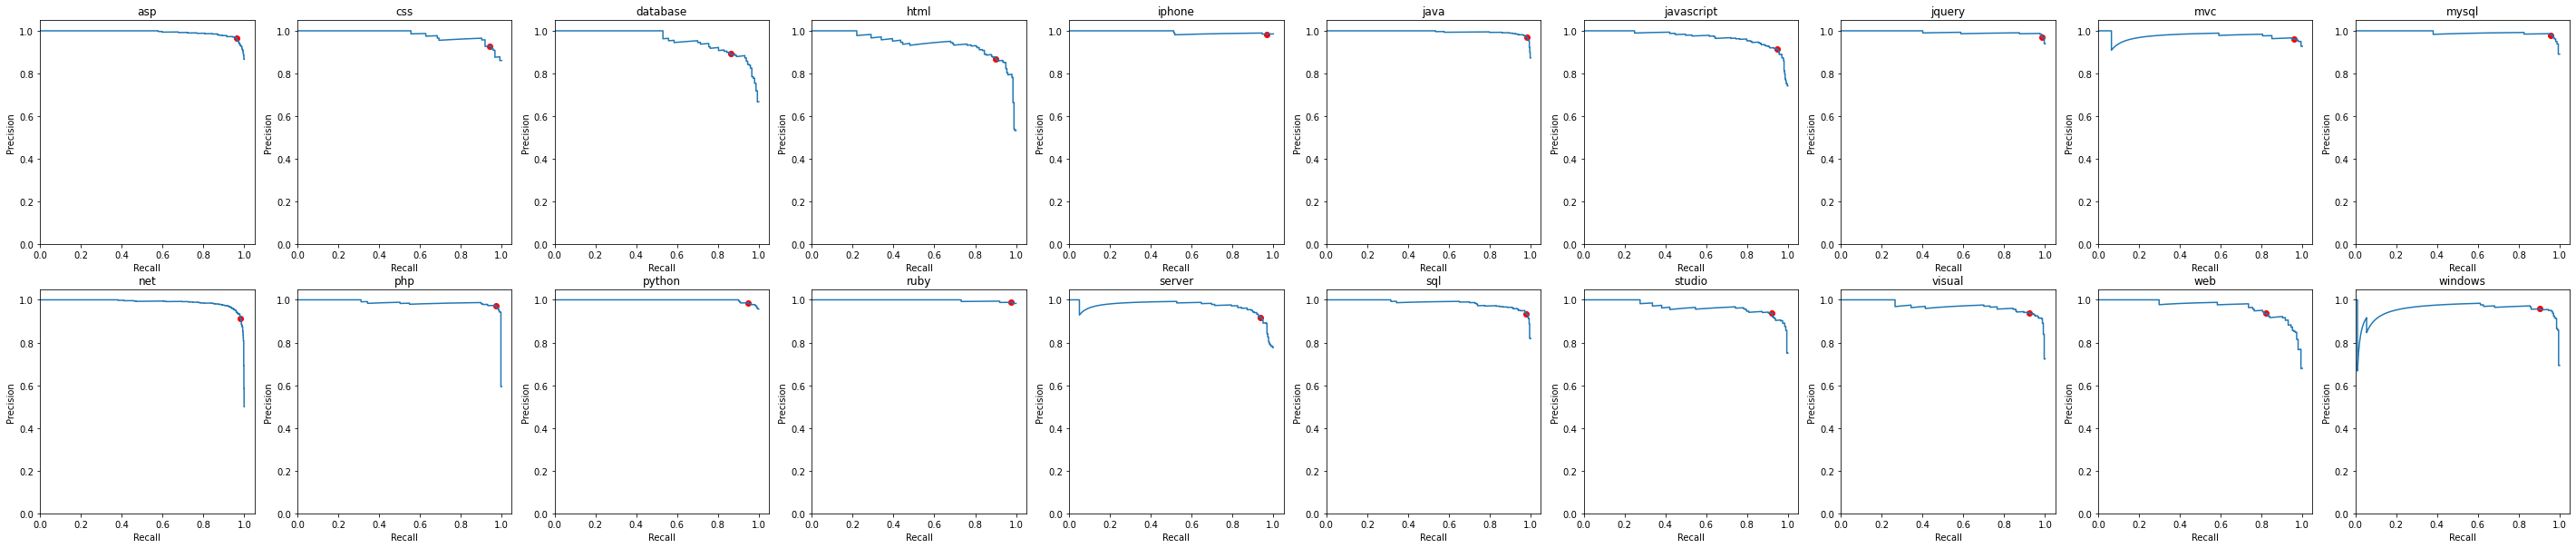

courbe precision-recall pour chaques étiquettes : val
-----------------------------------------------


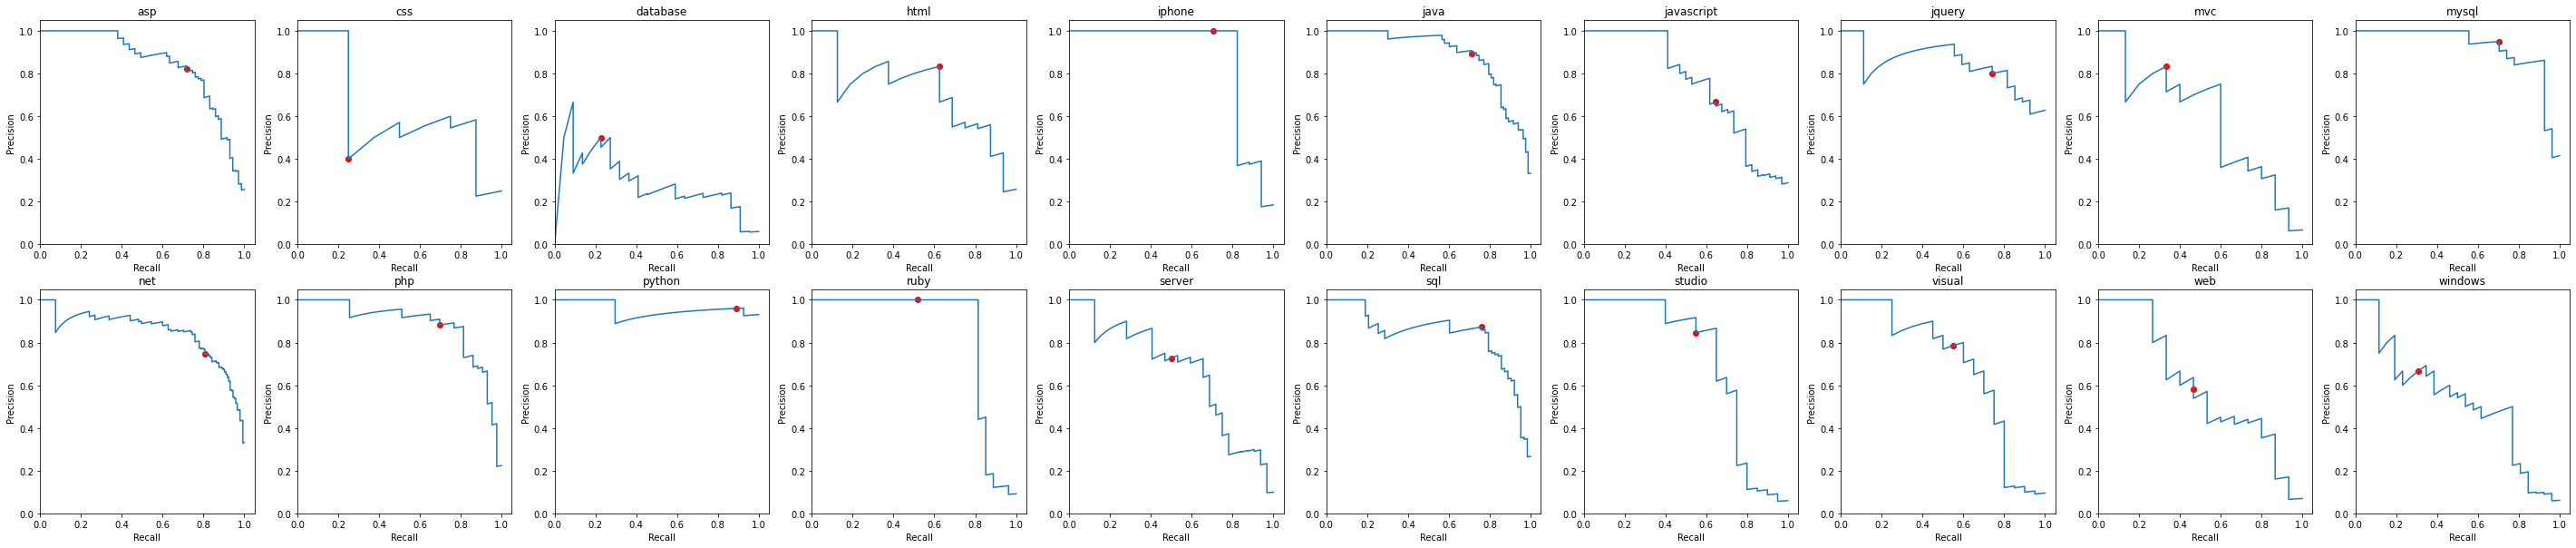

courbe accuracy pour chaques étiquettes : train
---------------------------------------


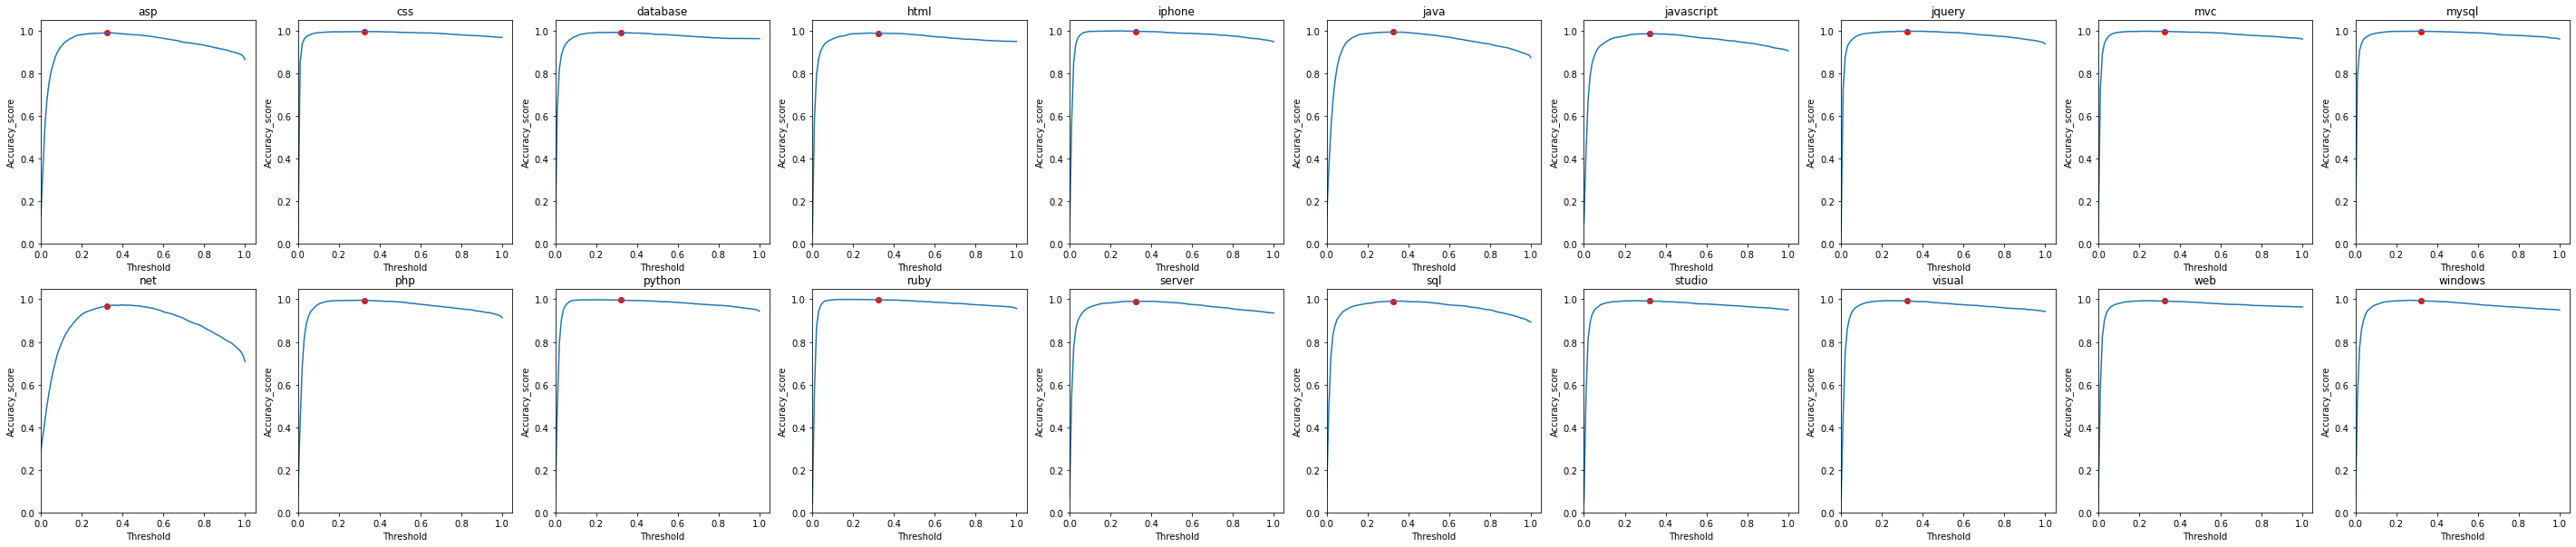

with threshold =  0.3535353535353536
best average accuracy weighted score =  0.9884392026578073


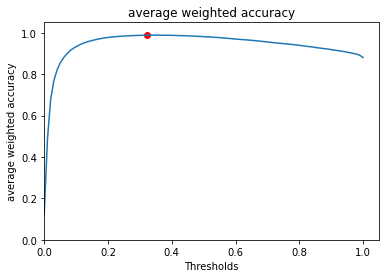

courbe accuracy pour chaques étiquettes : val
---------------------------------------


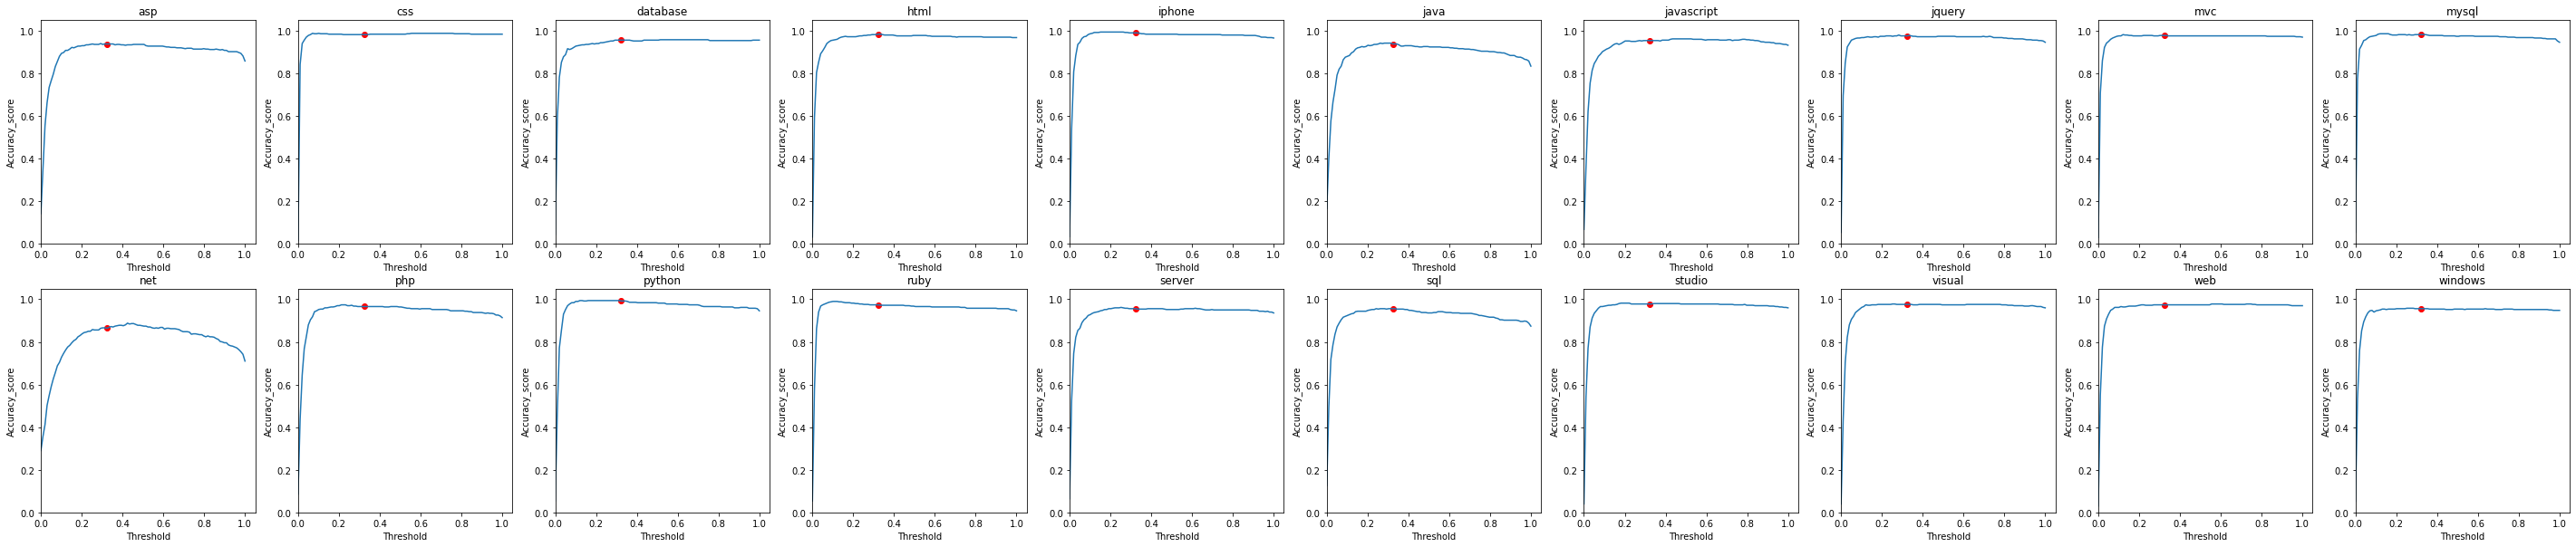

with threshold =  0.42424242424242425
best average accuracy weighted score =  0.9433279132791328


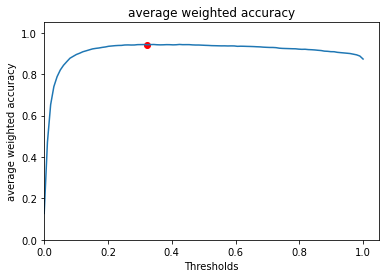

courbe jaccard : train
--------------
with threshold =  0.31313131313131315
best jaccard score =  0.9034263812280225


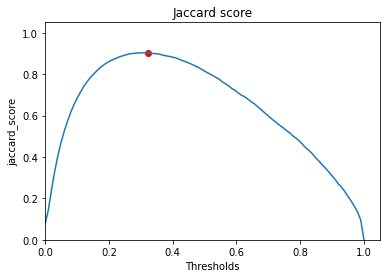

courbe jaccard : val
--------------
with threshold =  0.26262626262626265
best jaccard score =  0.6138339002920766


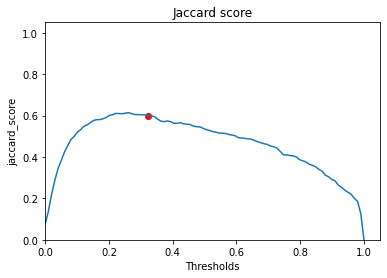

matrice de confusion : train
--------------------


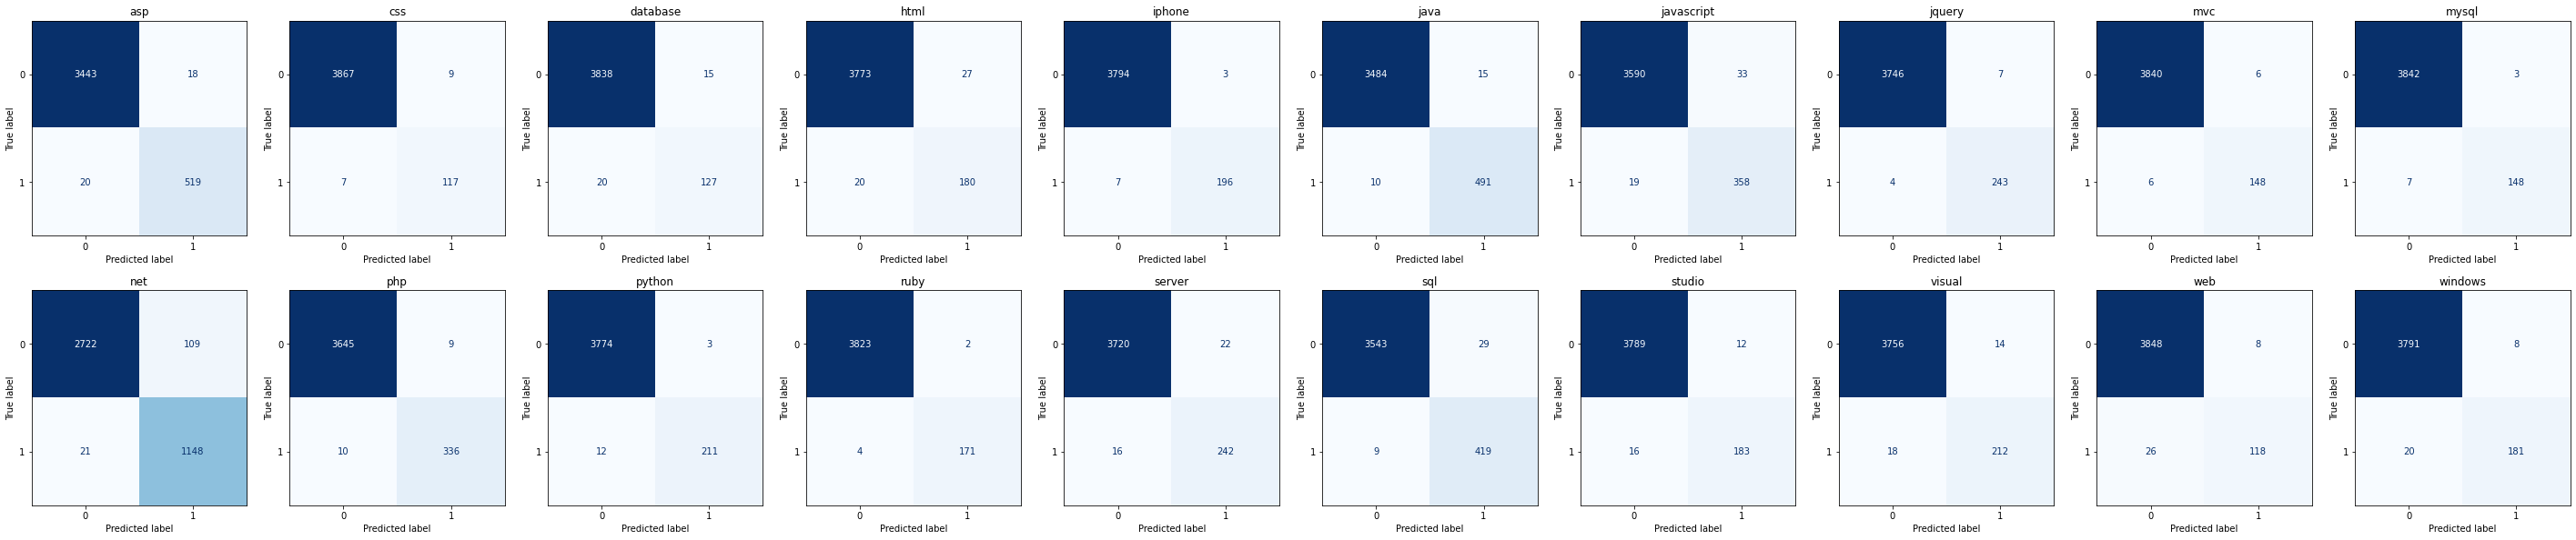

matrice de confusion : val
--------------------


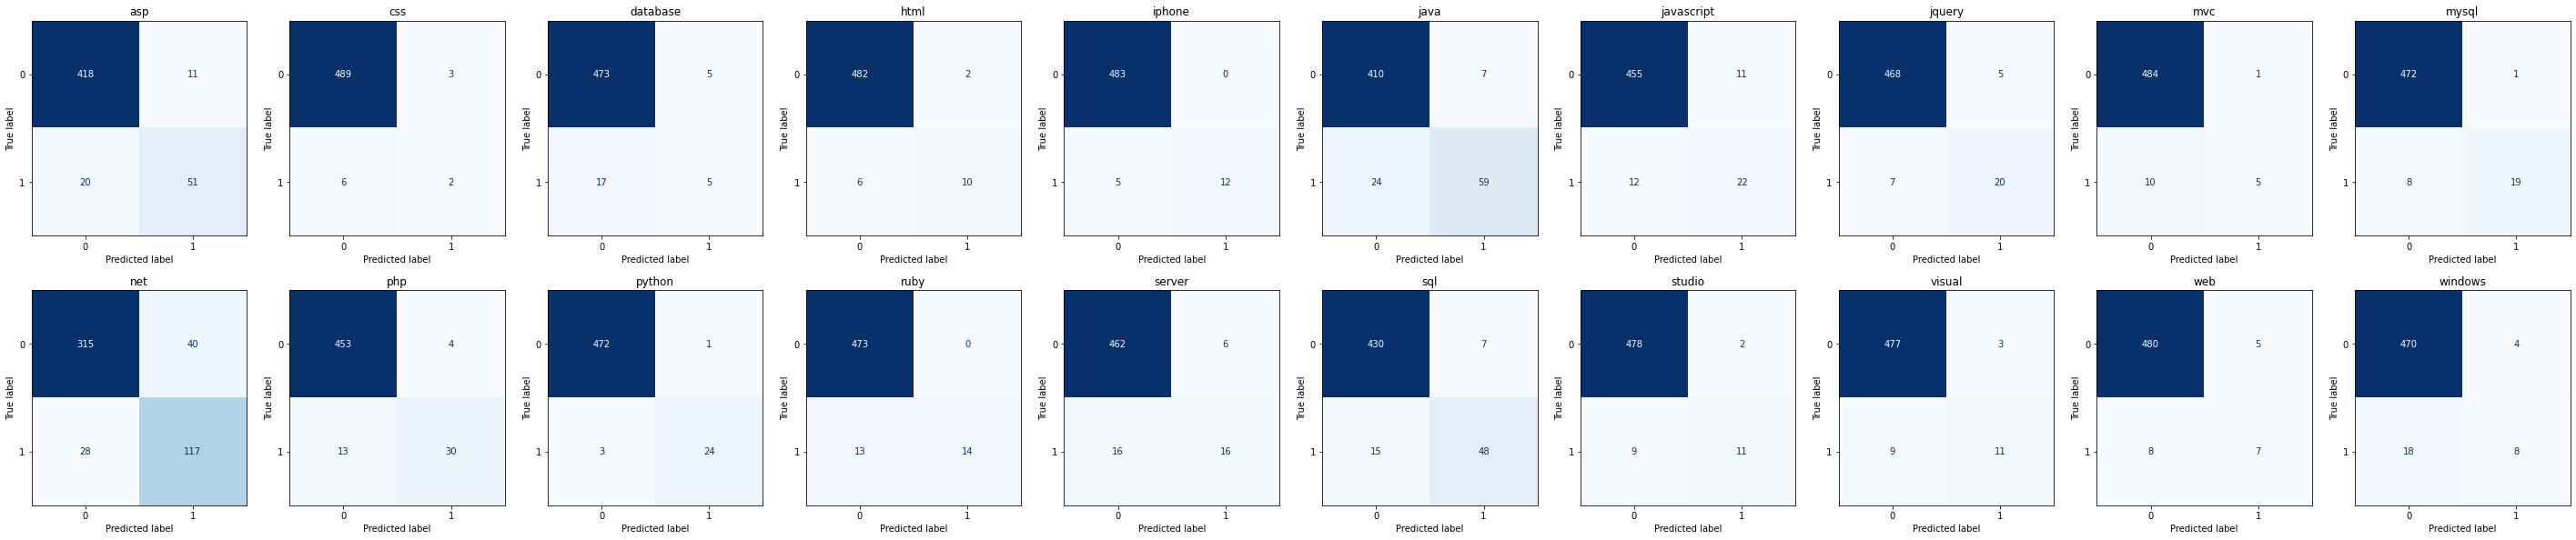

In [36]:
plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=threshold)

**1) k_neighbors**


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

k_neighbors = KNeighborsClassifier()
k_neighbors = MultiOutputClassifier(k_neighbors)

estimator__n_neighbors = np.arange(2, 40, 4)

n_jobs=[4]

hyperparameters = dict(estimator__n_neighbors = estimator__n_neighbors,
                       n_jobs = n_jobs
                      )

gscv_k_neighbors = GridSearchCV(k_neighbors, hyperparameters, cv=KFold(4,shuffle=True, random_state=random_state), scoring=scoring , verbose=2)
gscv_k_neighbors.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END .................estimator__n_neighbors=2, n_jobs=4; total time=   2.1s
[CV] END .................estimator__n_neighbors=2, n_jobs=4; total time=   2.0s
[CV] END .................estimator__n_neighbors=2, n_jobs=4; total time=   2.1s
[CV] END .................estimator__n_neighbors=2, n_jobs=4; total time=   2.0s
[CV] END .................estimator__n_neighbors=6, n_jobs=4; total time=   2.3s
[CV] END .................estimator__n_neighbors=6, n_jobs=4; total time=   2.4s
[CV] END .................estimator__n_neighbors=6, n_jobs=4; total time=   2.4s
[CV] END .................estimator__n_neighbors=6, n_jobs=4; total time=   2.4s
[CV] END ................estimator__n_neighbors=10, n_jobs=4; total time=   2.4s
[CV] END ................estimator__n_neighbors=10, n_jobs=4; total time=   2.4s
[CV] END ................estimator__n_neighbors=10, n_jobs=4; total time=   2.4s
[CV] END ................estimator__n_neighbors=

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38]),
                         'n_jobs': [4]},
             scoring=make_scorer(scorer_neg_hamming_loss, needs_proba=True),
             verbose=2)

In [38]:
gscv_k_neighbors.best_estimator_.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 38,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(n_neighbors=38),
 'n_jobs': 4}

In [39]:
gscv_k_neighbors.best_params_

{'estimator__n_neighbors': 38, 'n_jobs': 4}

In [40]:
gscv_k_neighbors.cv_results_

{'mean_fit_time': array([0.14404488, 0.13878131, 0.1408751 , 0.13024247, 0.13272631,
        0.13892549, 0.14399523, 0.13920957, 0.13800758, 0.14414626]),
 'std_fit_time': array([0.0104305 , 0.0091054 , 0.01017478, 0.00829193, 0.00449446,
        0.0029073 , 0.01043781, 0.00618611, 0.00506457, 0.00838594]),
 'mean_score_time': array([2.00131559, 2.32948631, 2.34981459, 2.35757548, 2.40690744,
        2.40370101, 2.4300335 , 2.4297989 , 2.44284141, 2.41334927]),
 'std_score_time': array([0.01275608, 0.01649319, 0.01475989, 0.01185751, 0.02092492,
        0.03032471, 0.02986916, 0.01030208, 0.0151991 , 0.01492161]),
 'param_estimator__n_neighbors': masked_array(data=[2, 6, 10, 14, 18, 22, 26, 30, 34, 38],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_jobs': masked_array(data=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
              mask=[False, False, False, False, False, Fa

In [41]:
y_score_train = gscv_k_neighbors.predict_proba(X_train_tfidf)
y_pred_train = gscv_k_neighbors.predict(X_train_tfidf)

classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'k_neighbors_on_train'))

In [42]:
y_score_val = gscv_k_neighbors.predict_proba(X_val_tfidf)
y_pred_val = gscv_k_neighbors.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'k_neighbors_on_val'))

In [43]:
threshold = get_threshold(y_train,y_score_train) 

courbe neg hamming loss : train
-----------------------
with threshold =  0.3434343434343435
best neg_hamming_loss =  -0.0476375


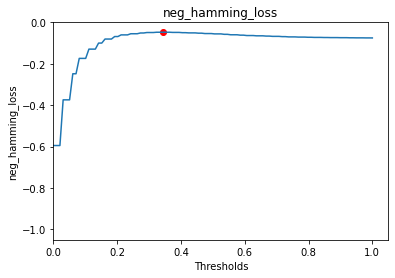

courbe neg hamming loss : val
-----------------------
with threshold =  0.32323232323232326
best neg_hamming_loss =  -0.0499


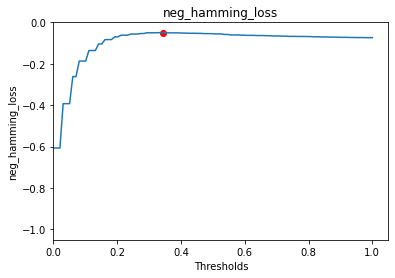

courbe ROC pour chaques étiquettes : train
----------------------------------


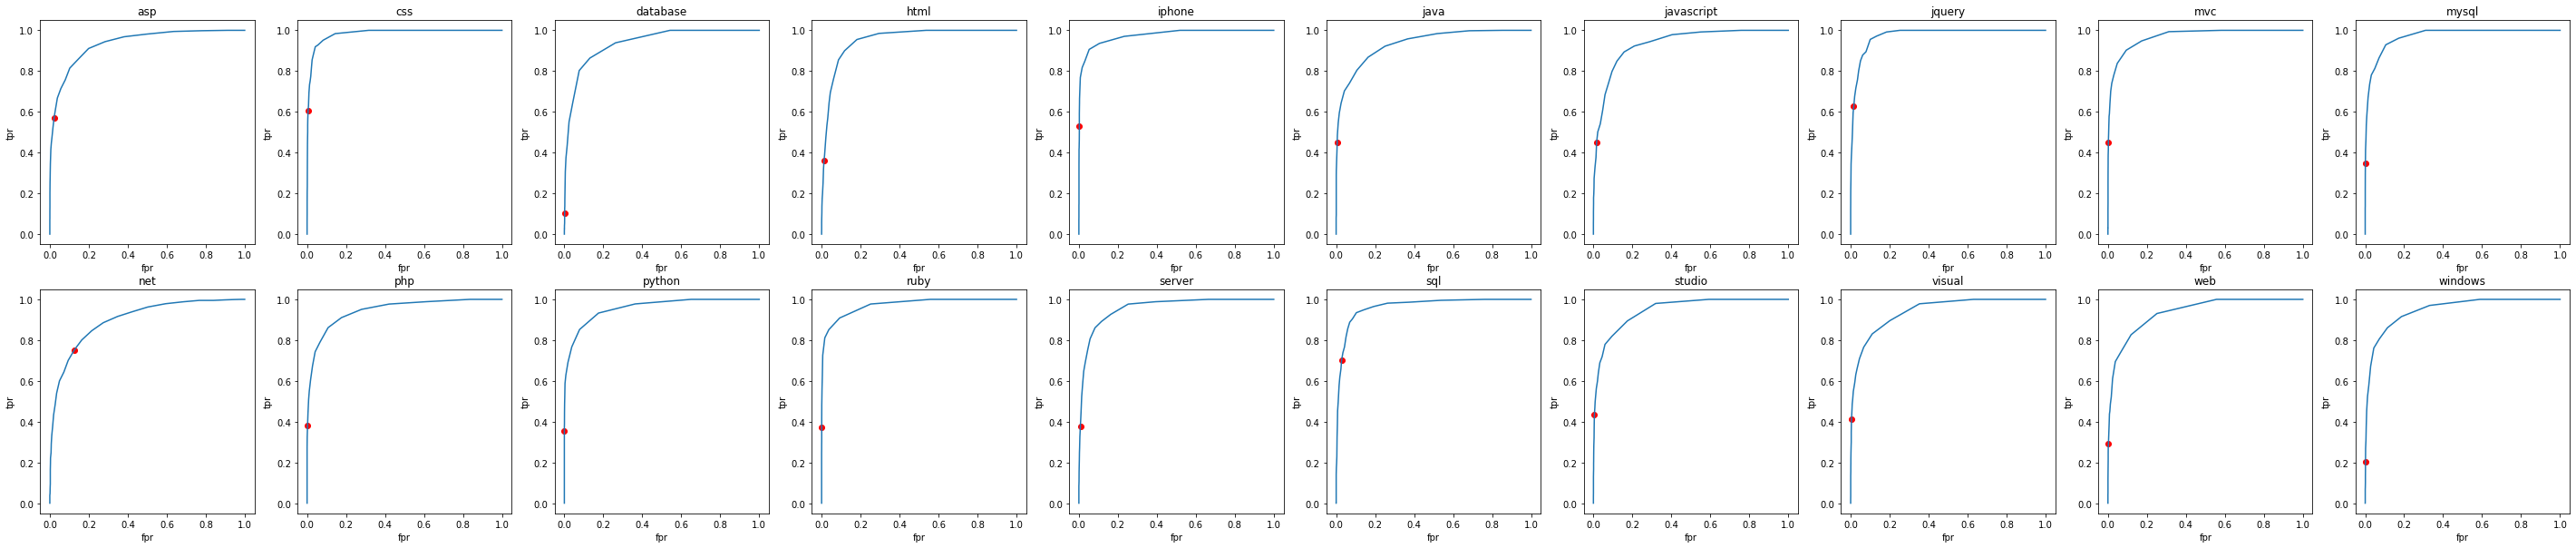

courbe ROC pour chaques étiquettes : val
----------------------------------


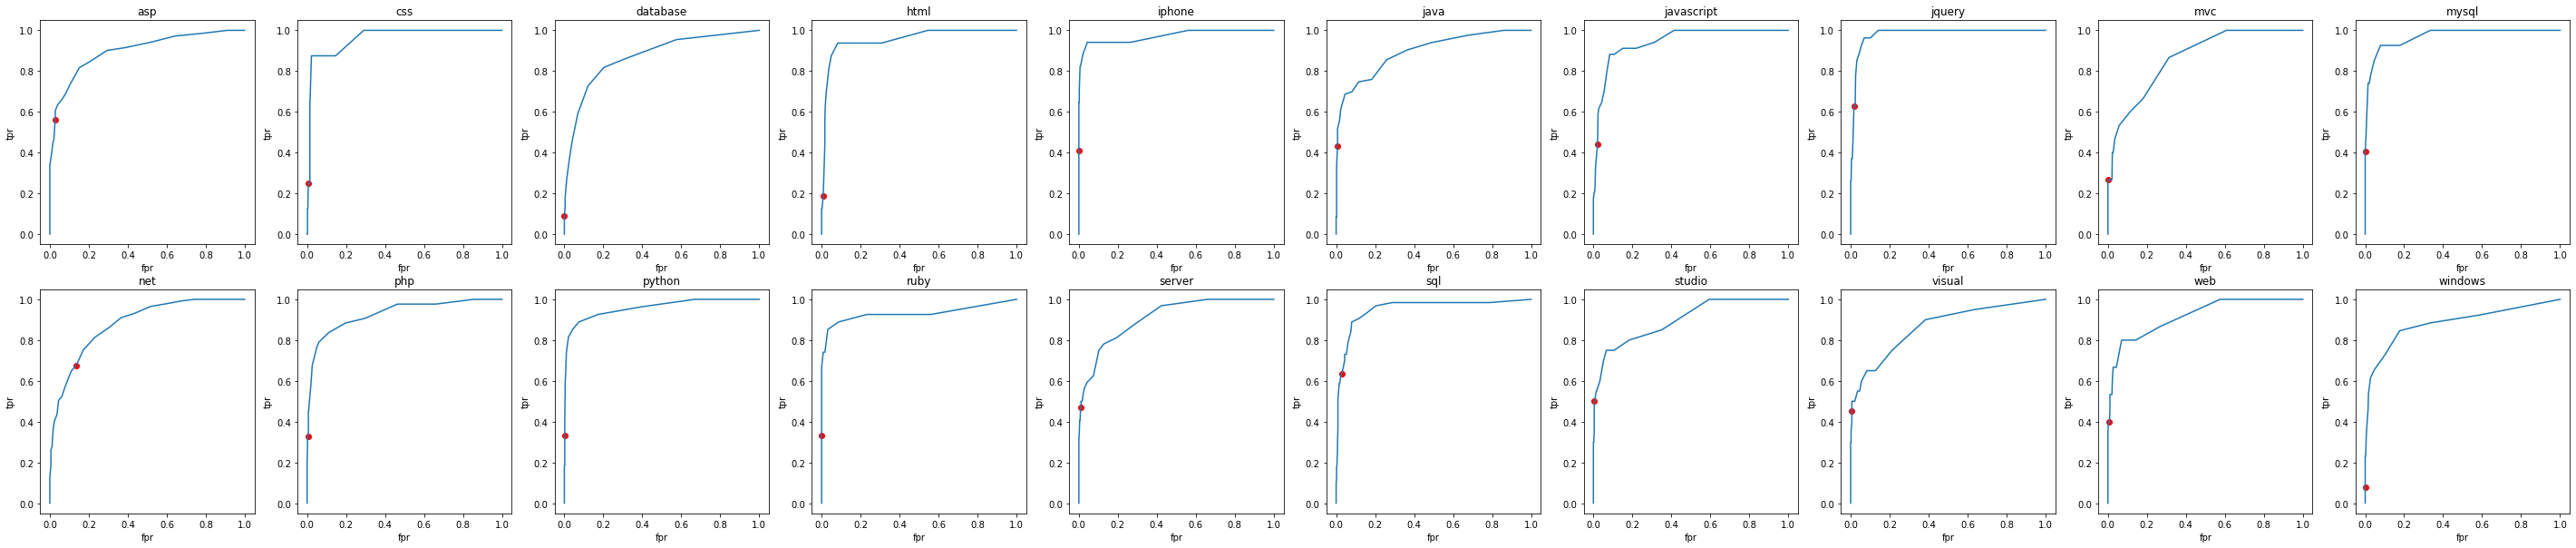

courbe precision-recall pour chaques étiquettes : train
-----------------------------------------------


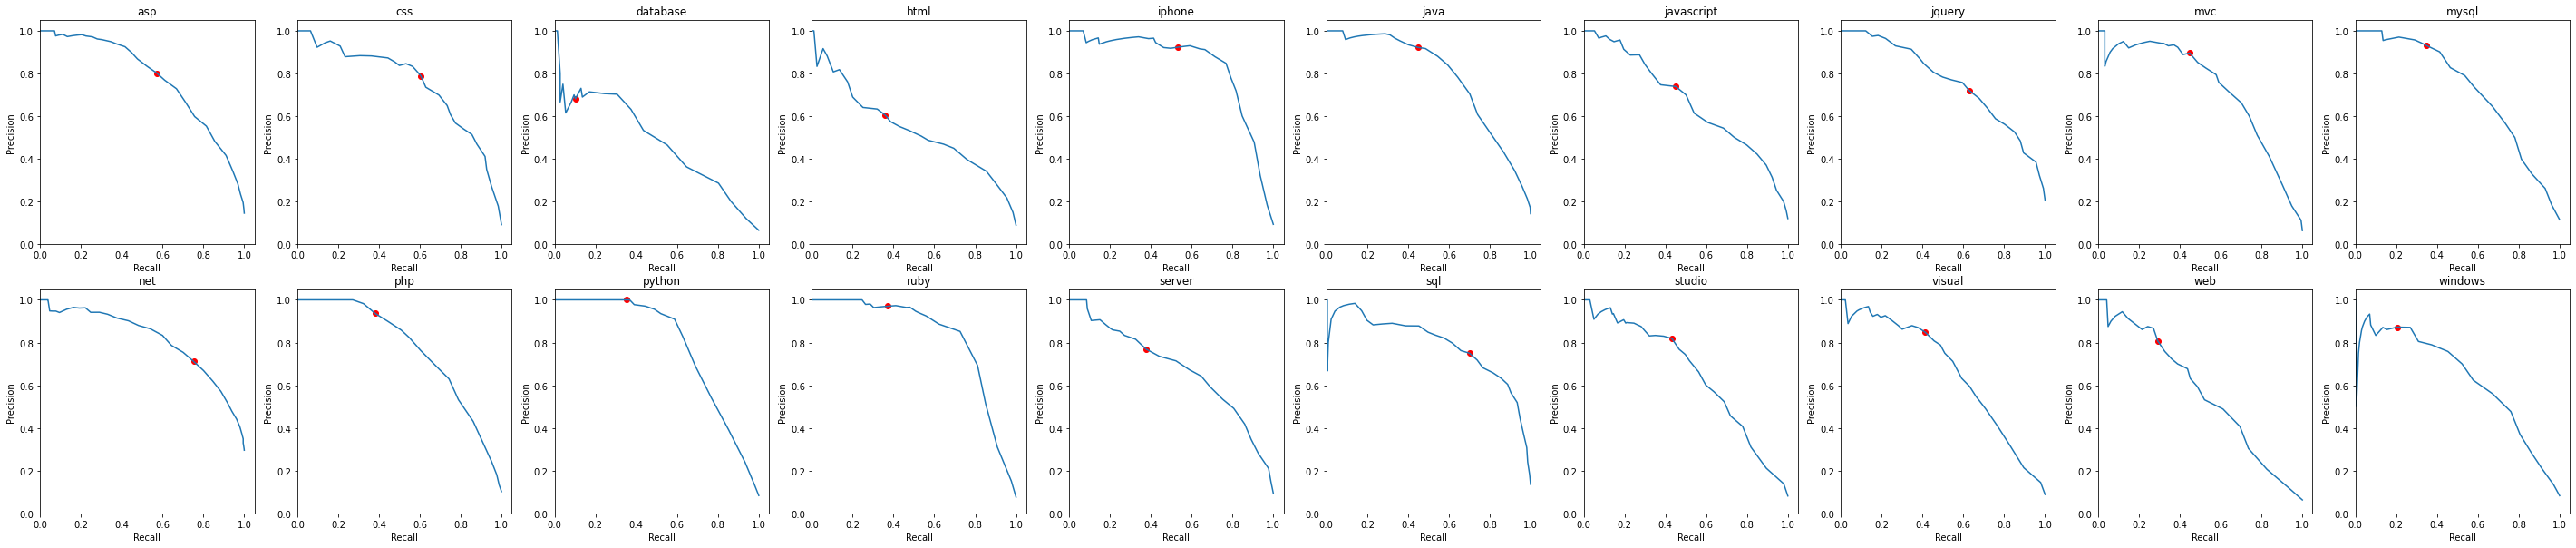

courbe precision-recall pour chaques étiquettes : val
-----------------------------------------------


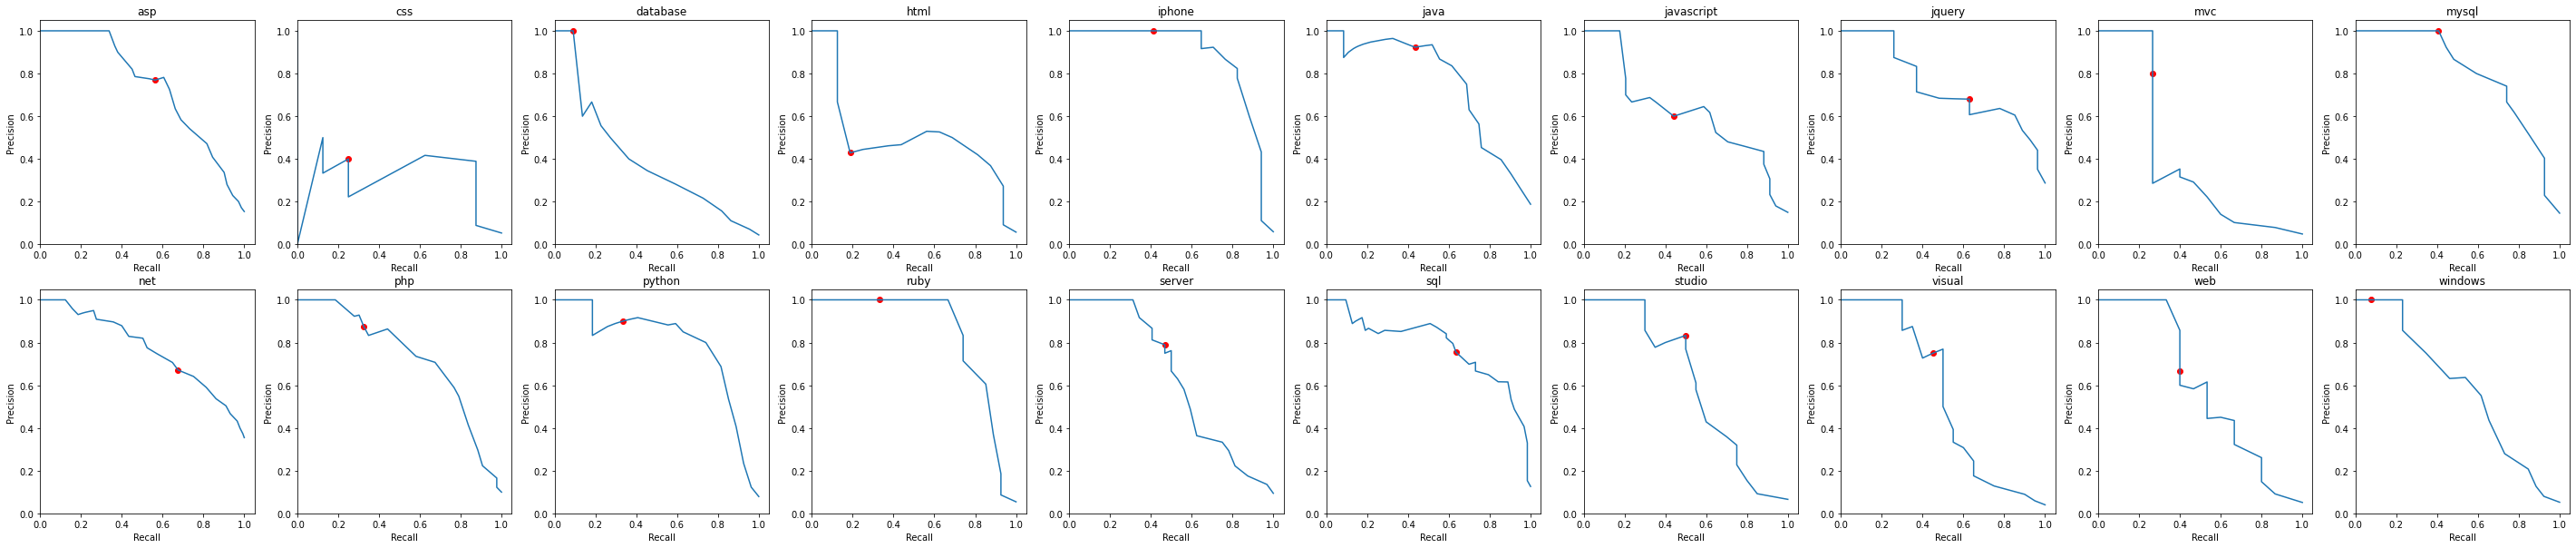

courbe accuracy pour chaques étiquettes : train
---------------------------------------


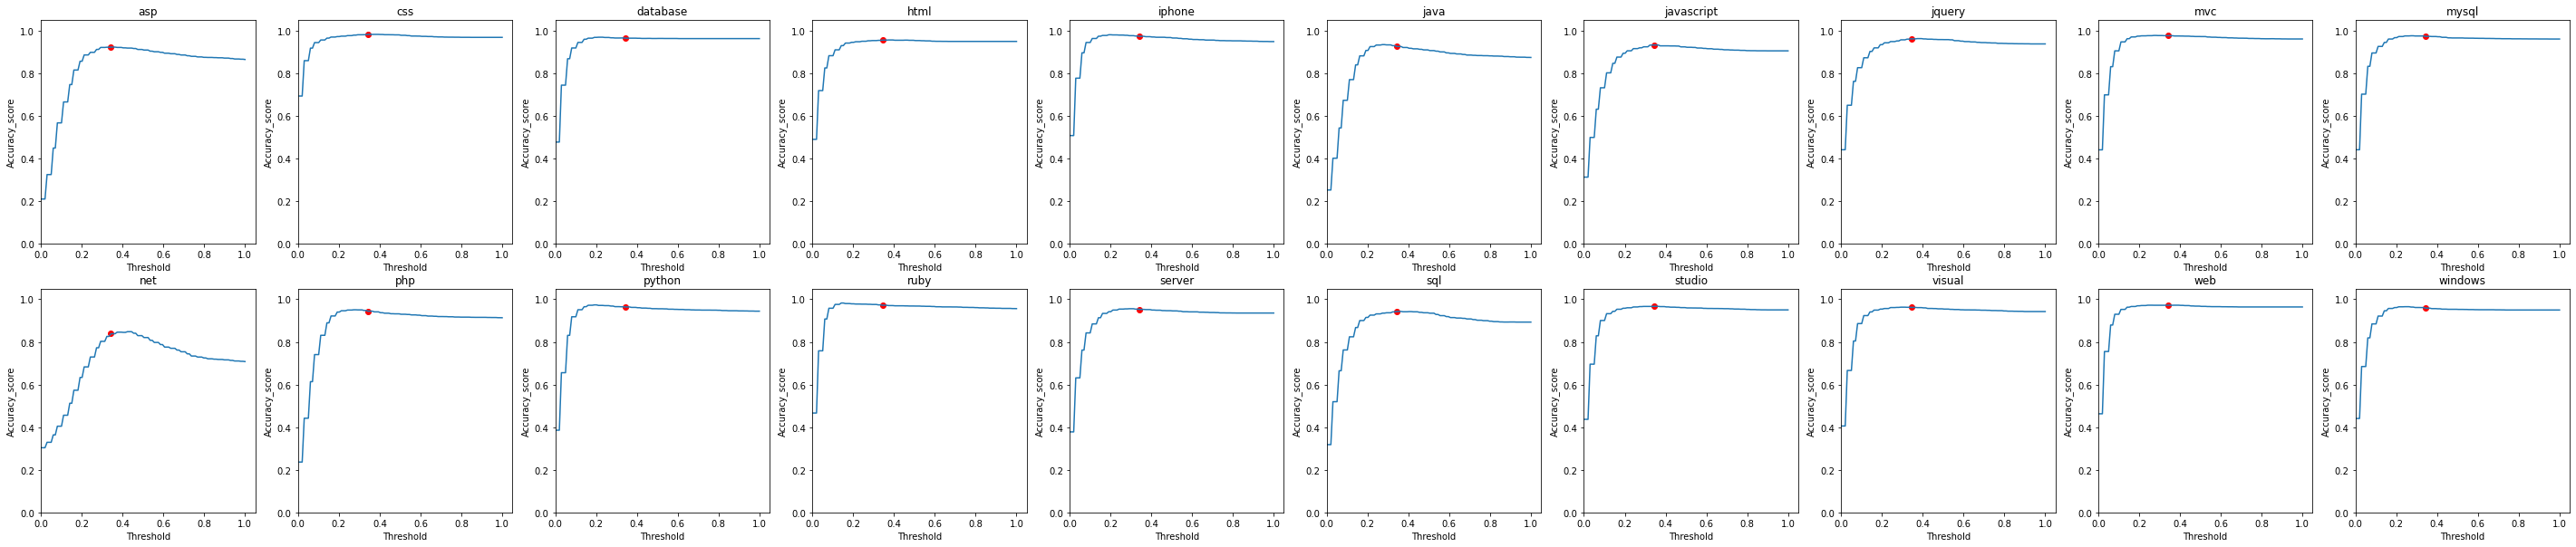

with threshold =  0.3434343434343435
best average accuracy weighted score =  0.9290473837209302


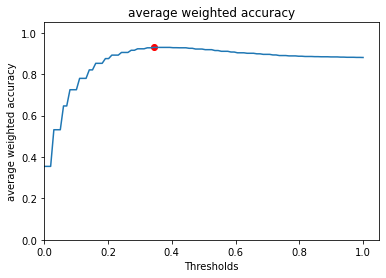

courbe accuracy pour chaques étiquettes : val
---------------------------------------


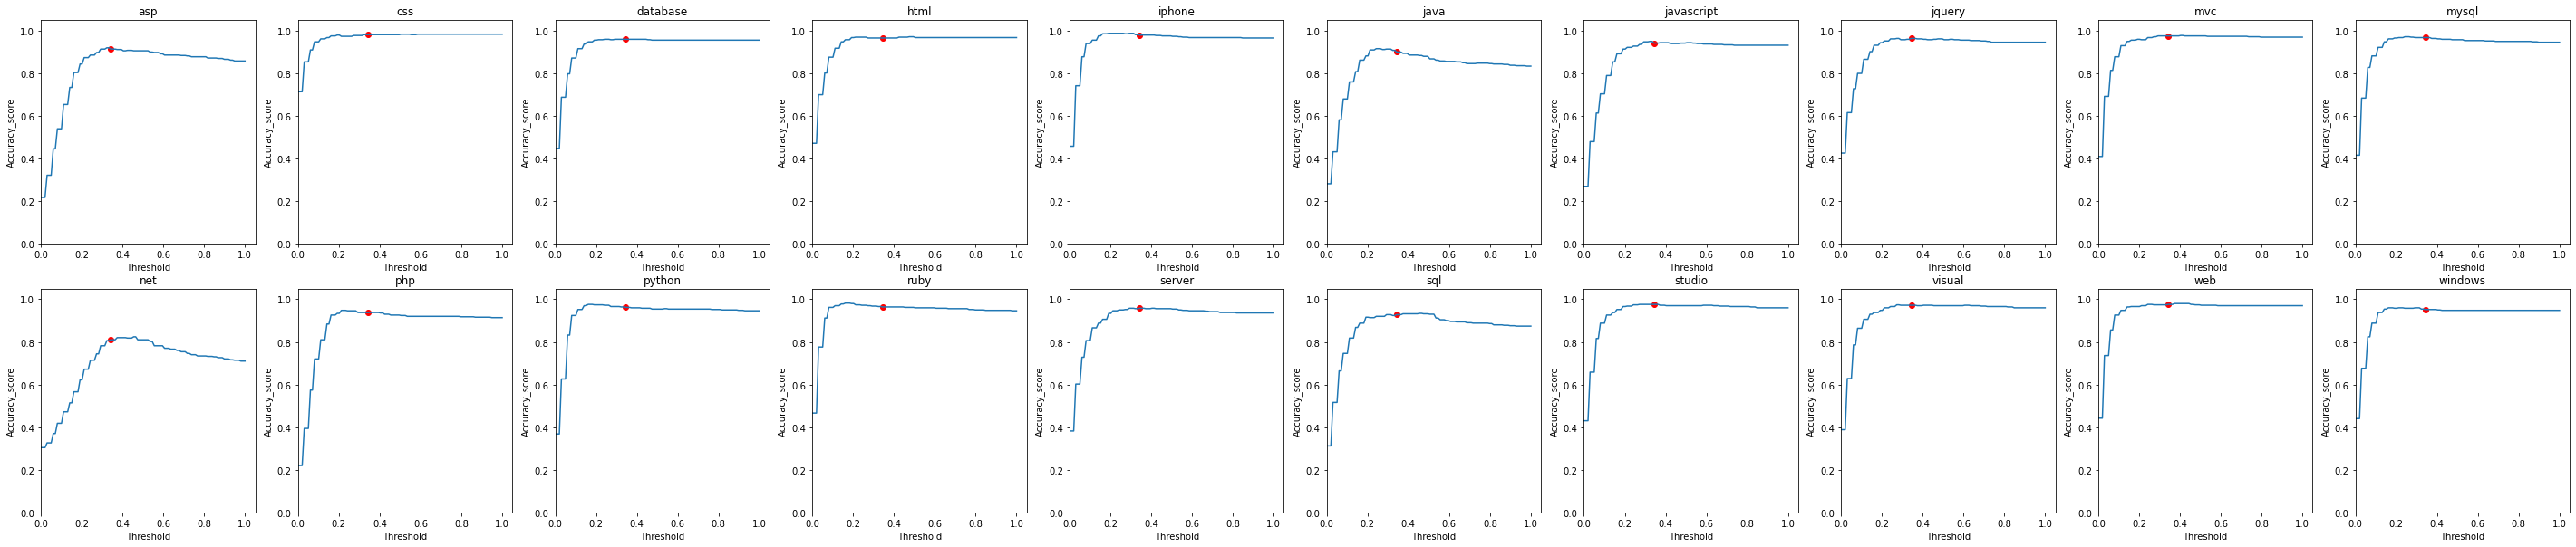

with threshold =  0.37373737373737376
best average accuracy weighted score =  0.9181111111111111


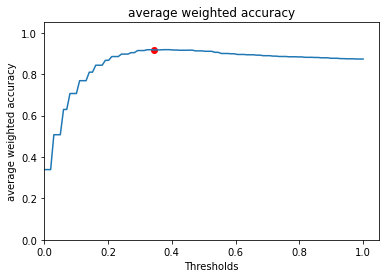

courbe jaccard : train
--------------
with threshold =  0.27272727272727276
best jaccard score =  0.498796332815788


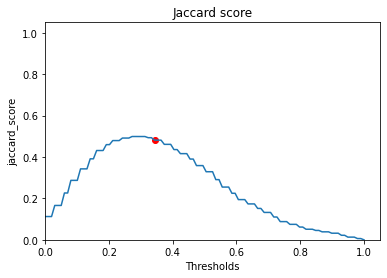

courbe jaccard : val
--------------
with threshold =  0.29292929292929293
best jaccard score =  0.47700249964355856


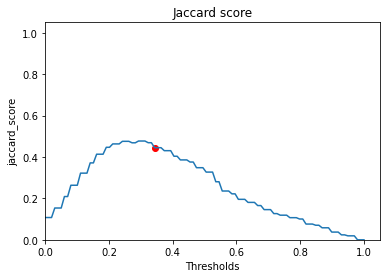

matrice de confusion : train
--------------------


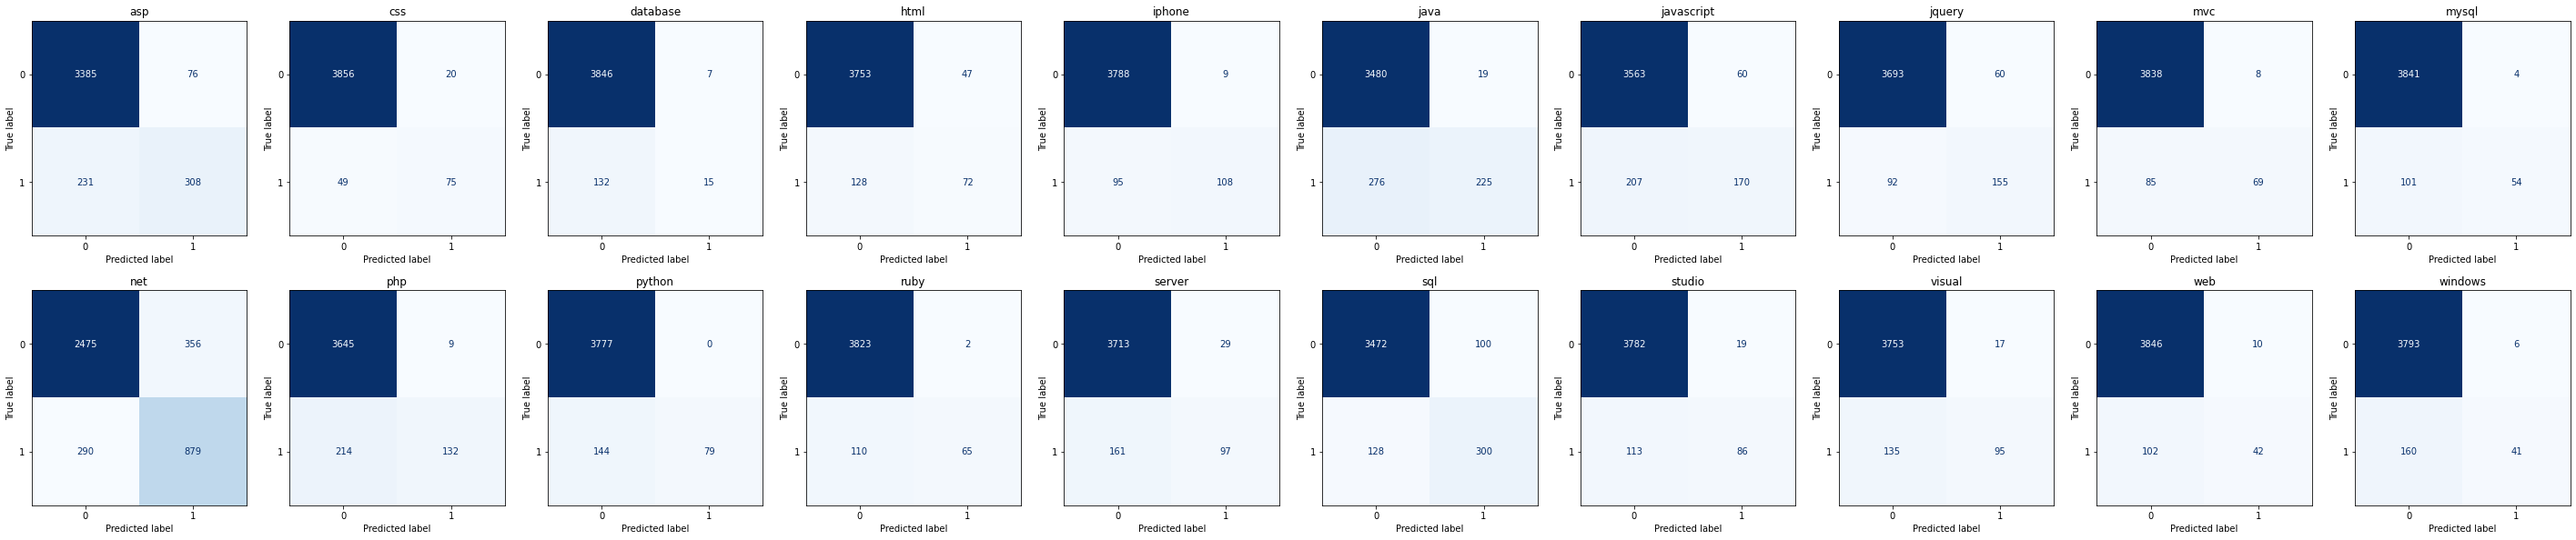

matrice de confusion : val
--------------------


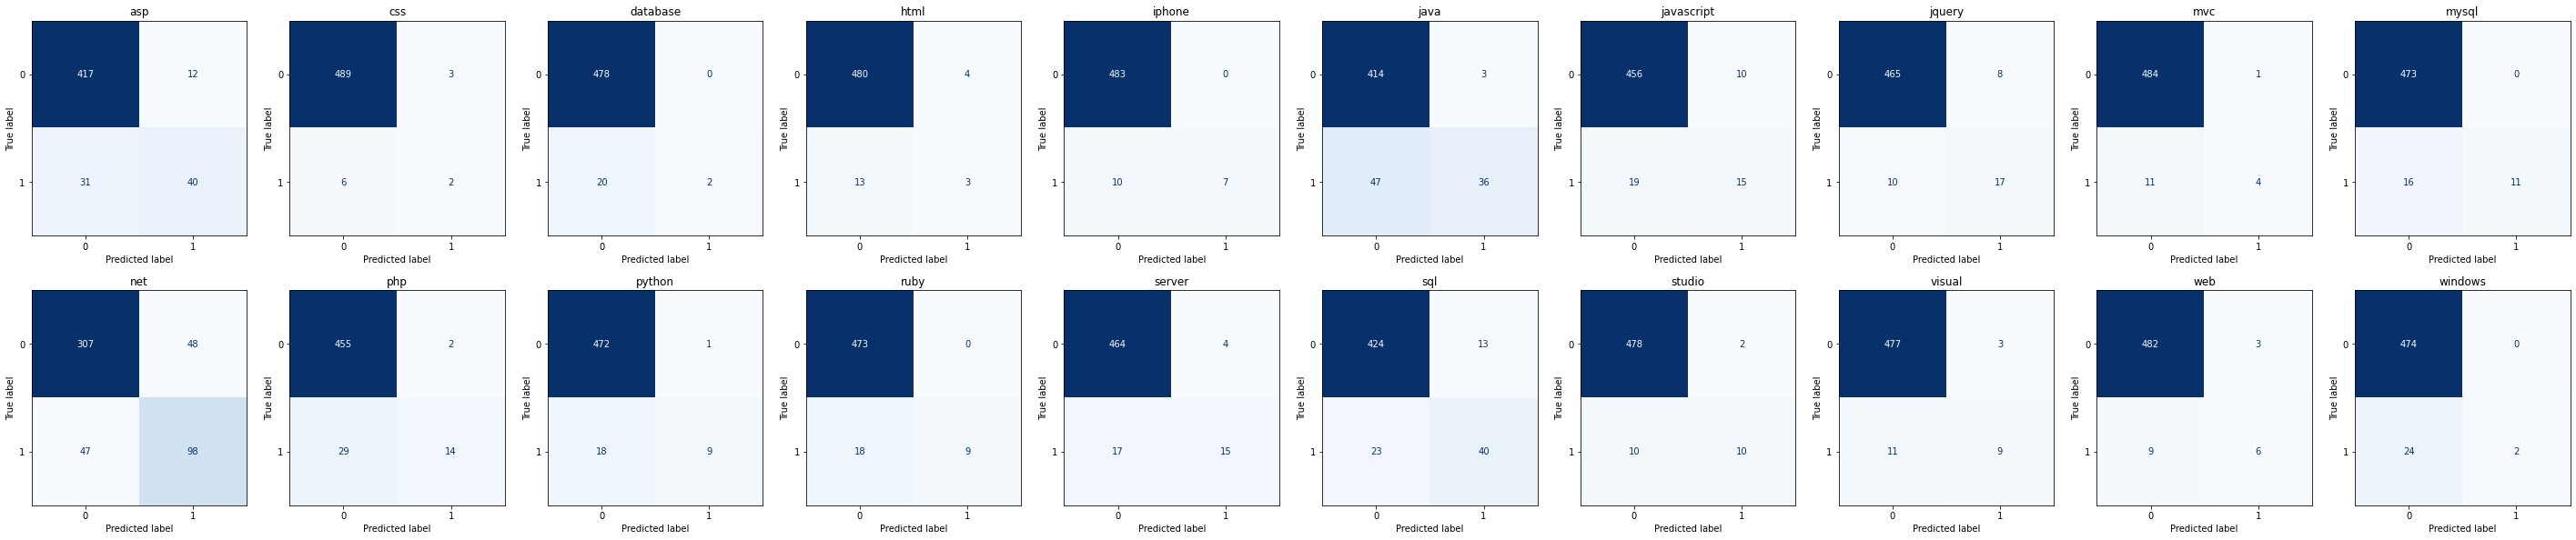

In [44]:
plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=threshold)

**2) classification Random Forest**

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

random_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 5)]
#max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparameters = dict(n_estimators = n_estimators,
                       max_features = max_features,
                       max_depth = max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap,
                       n_jobs = n_jobs
                      )

rscv_random_forest = RandomizedSearchCV(random_forest, hyperparameters, n_iter = 50, cv=KFold(3,shuffle=True, random_state=random_state), verbose=2 , random_state=random_state, scoring=scoring)

rscv_random_forest.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   4.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   4.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   4.7s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.0s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.0s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_sa

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   6.0s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.1s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.1s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.1s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.2s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.2s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4;

[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   1.7s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   1.7s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   4.3s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   4.2s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   4.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   3.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jo

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 9, 16, 23, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [400, 700, 1000],
                                        'n_jobs': [4]},
                   random_state=42,
                   scoring=make_scorer(scorer_neg_hamming_loss, needs_proba=True),
                   verbose=2)

In [46]:
rscv_random_forest.best_params_

{'n_jobs': 4,
 'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [47]:
rscv_random_forest.cv_results_

{'mean_fit_time': array([3.33096242, 1.77481246, 7.29087281, 2.59174951, 3.96334672,
        2.45796776, 0.81528489, 3.07462915, 1.21212777, 4.69438704,
        0.80121088, 1.43483337, 4.71587857, 1.01020153, 1.8903815 ,
        1.81110867, 7.31067165, 2.35880804, 4.66573016, 1.79988996,
        1.98409684, 3.51420299, 1.43322086, 4.61369777, 4.81337078,
        1.7896146 , 1.44238591, 1.26275682, 1.36377819, 1.83074705,
        2.93989277, 4.11287928, 5.98308794, 6.29621363, 1.97651458,
        6.71390065, 1.81736477, 1.01911624, 3.06594388, 2.67360783,
        0.81298351, 8.50946625, 3.6153299 , 3.35683354, 4.13604132,
        1.77433395, 3.03359135, 1.61044327, 5.42986854, 0.77909938]),
 'std_fit_time': array([0.00919322, 0.00759035, 0.01758378, 0.01948421, 0.01358764,
        0.01054334, 0.01392422, 0.02005212, 0.01443858, 0.00622204,
        0.01049357, 0.02171472, 0.02562211, 0.00569184, 0.0445683 ,
        0.02113183, 0.01888487, 0.00770465, 0.00882401, 0.00919493,
        0.003

In [48]:
y_score_train = rscv_random_forest.best_estimator_.predict_proba(X_train_tfidf)
y_pred_train = rscv_random_forest.best_estimator_.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'random_forest_on_train'))

In [49]:
y_score_val = rscv_random_forest.best_estimator_.predict_proba(X_val_tfidf)
y_pred_val = rscv_random_forest.best_estimator_.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'random_forest_on_val'))

In [50]:
threshold = get_threshold(y_train,y_score_train) 

courbe neg hamming loss : train
-----------------------
with threshold =  0.27272727272727276
best neg_hamming_loss =  -0.006875


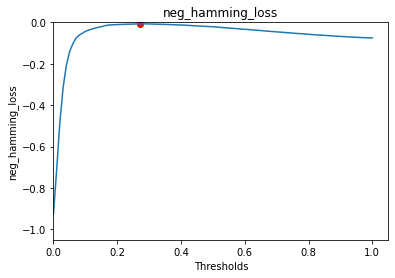

courbe neg hamming loss : val
-----------------------
with threshold =  0.33333333333333337
best neg_hamming_loss =  -0.0351


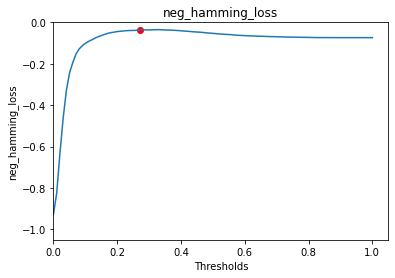

courbe ROC pour chaques étiquettes : train
----------------------------------


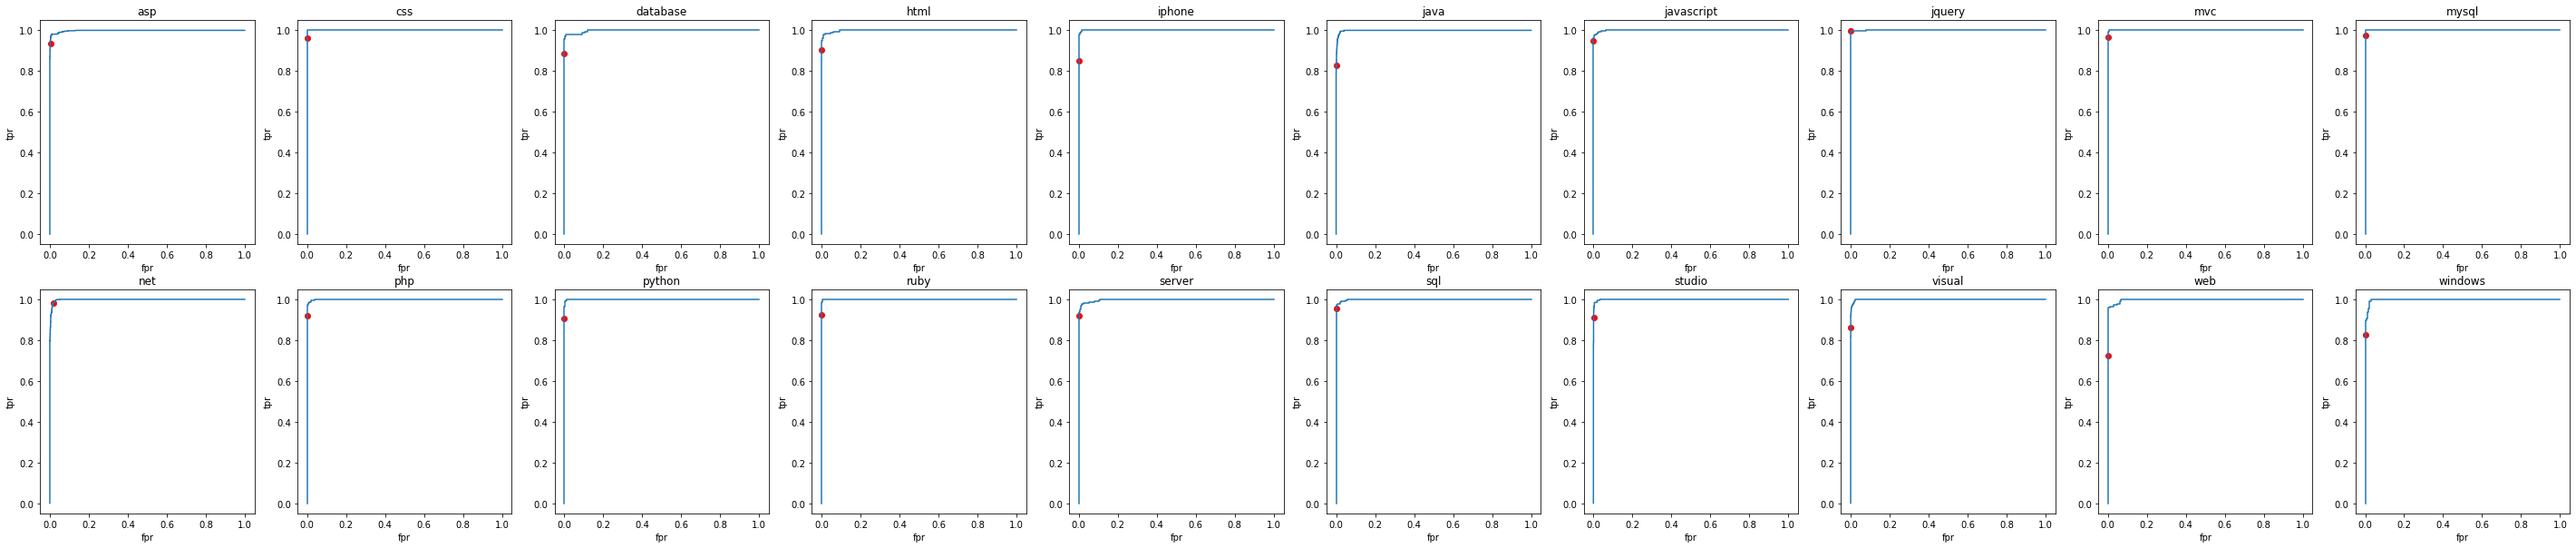

courbe ROC pour chaques étiquettes : val
----------------------------------


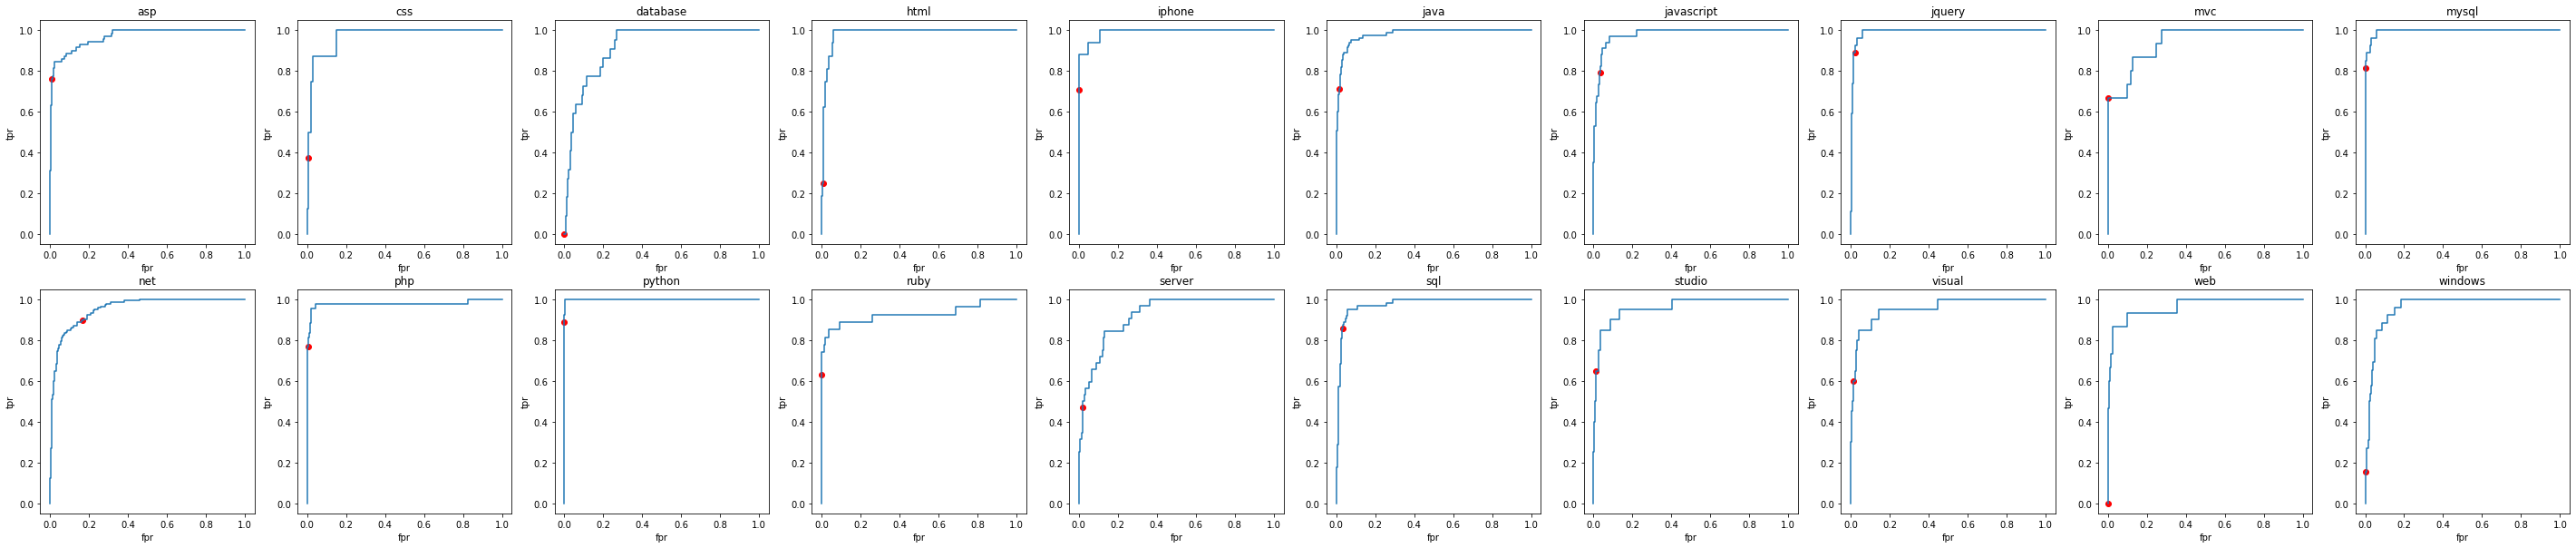

courbe precision-recall pour chaques étiquettes : train
-----------------------------------------------


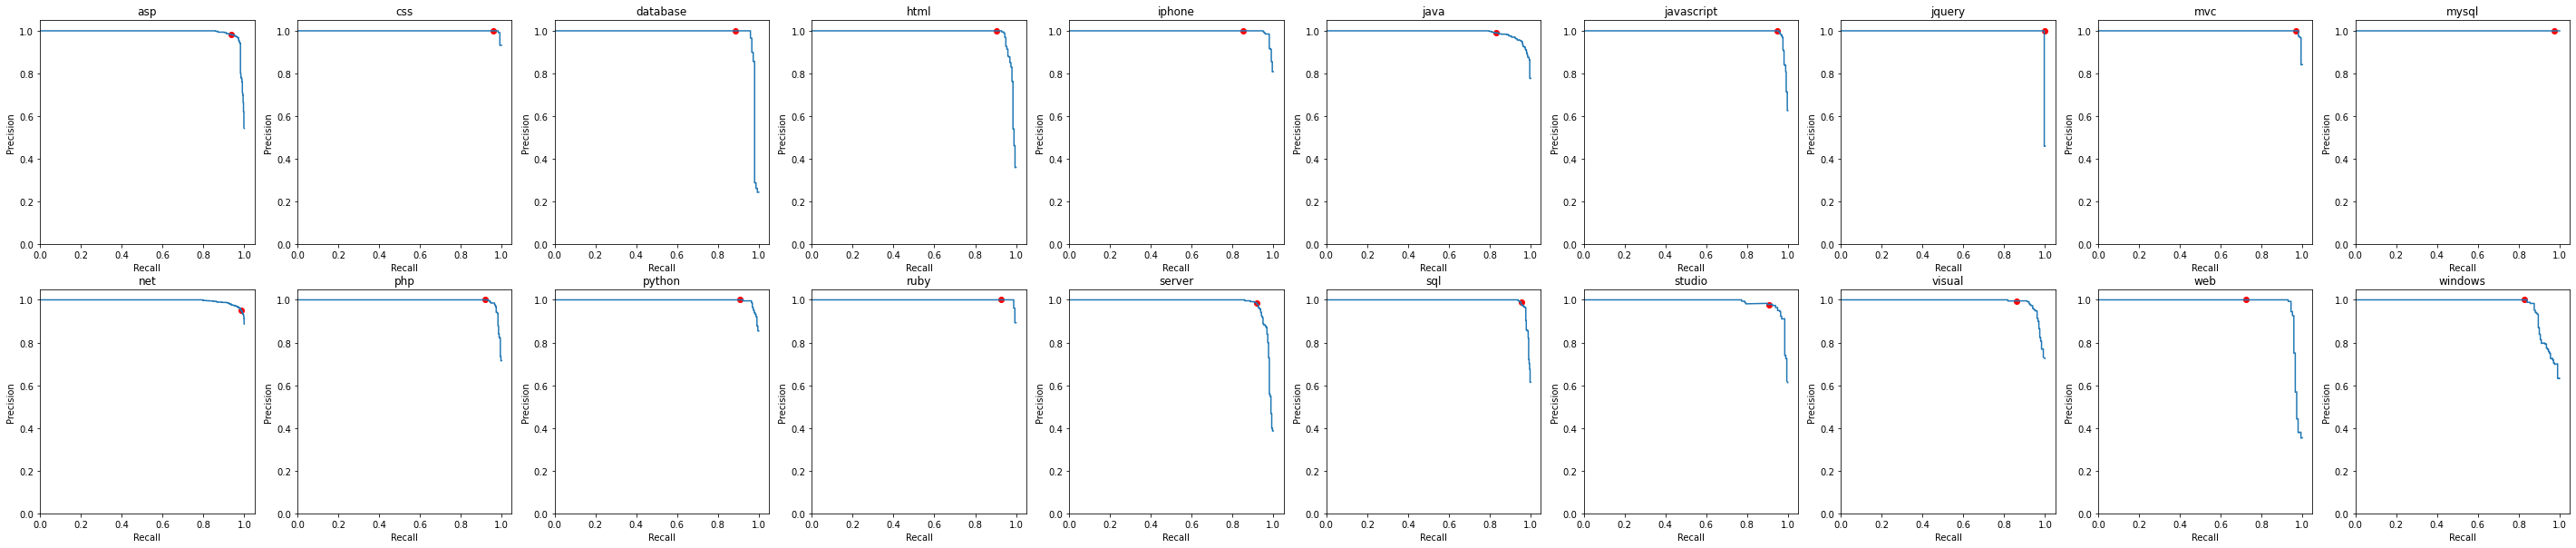

courbe precision-recall pour chaques étiquettes : val
-----------------------------------------------


<ipython-input-14-50b16ed78b21>:58: RuntimeWarning: invalid value encountered in longlong_scalars
  ax.scatter(tp/(tp+fn), tp/(tp+fp), marker='o', color='red', label='Best')
<ipython-input-14-50b16ed78b21>:58: RuntimeWarning: invalid value encountered in longlong_scalars
  ax.scatter(tp/(tp+fn), tp/(tp+fp), marker='o', color='red', label='Best')


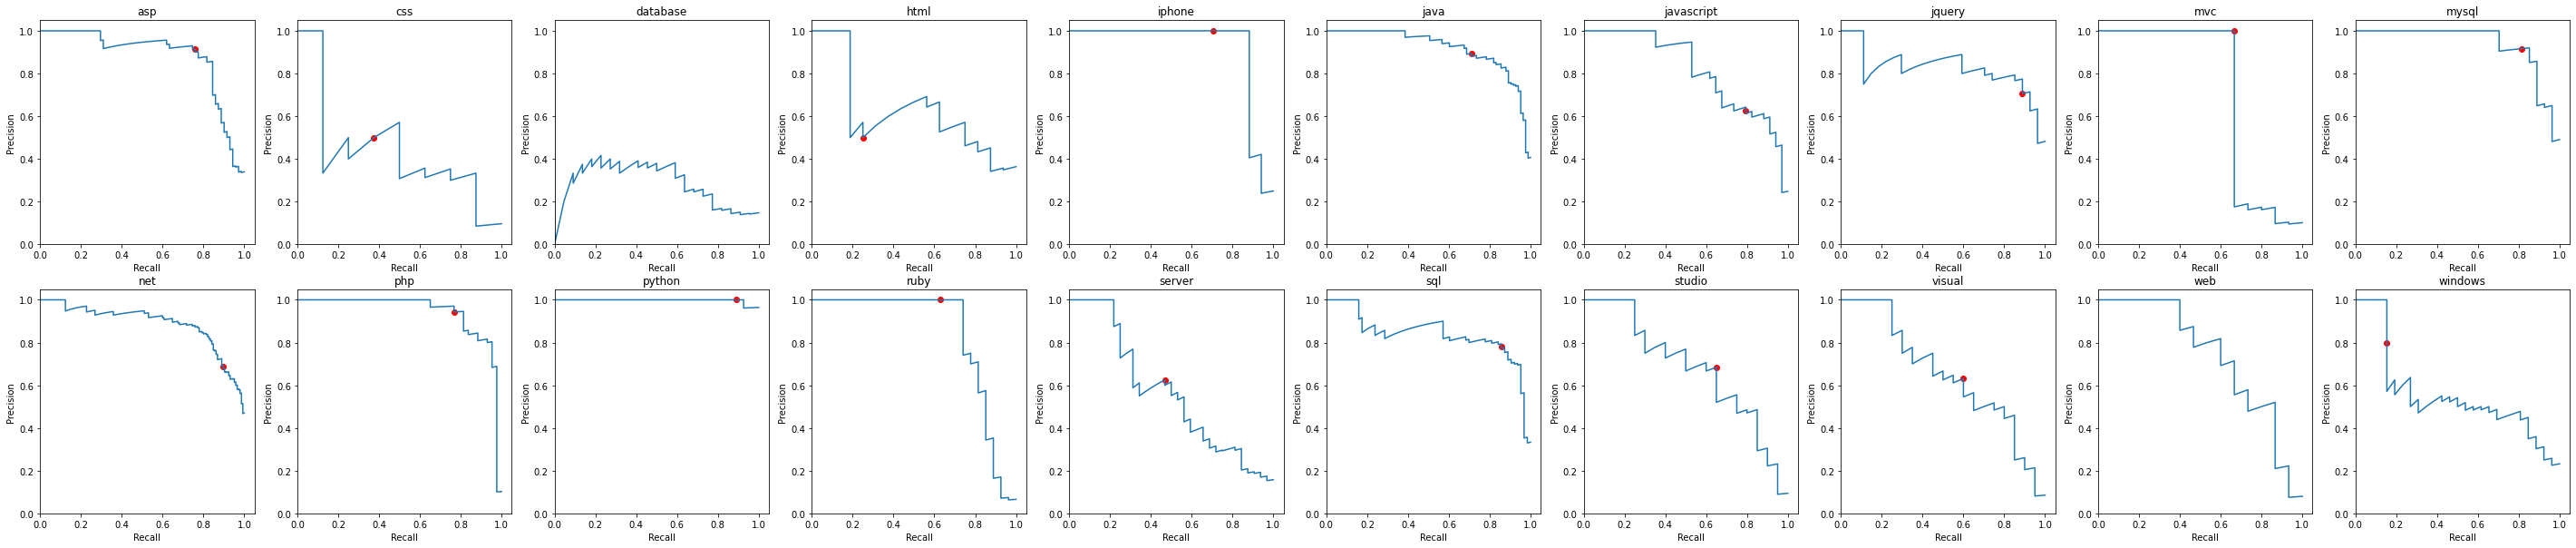

courbe accuracy pour chaques étiquettes : train
---------------------------------------


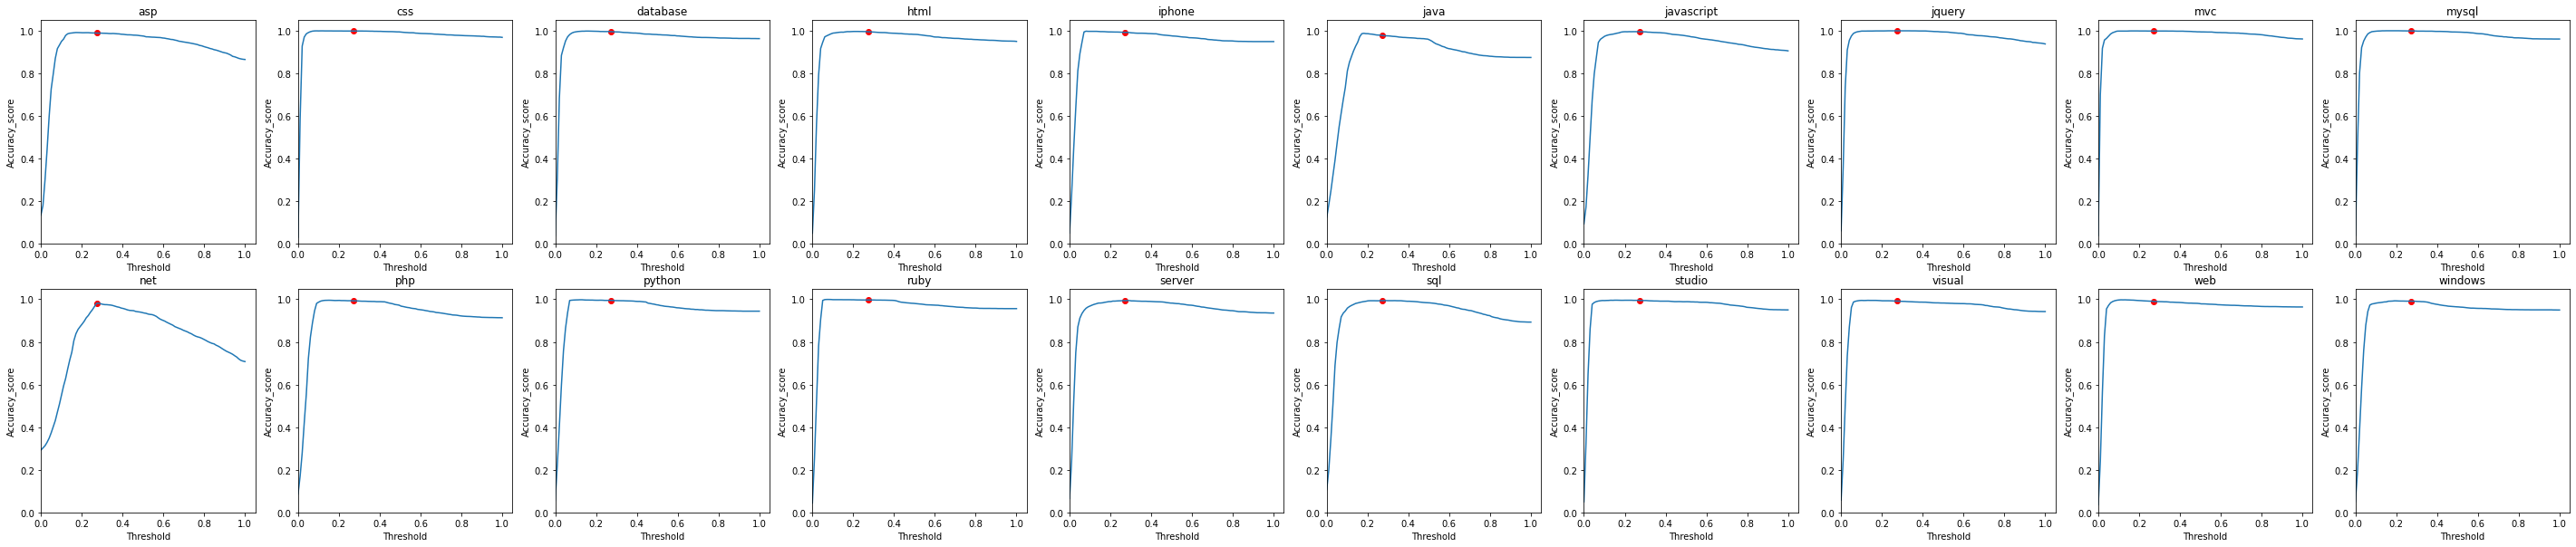

with threshold =  0.27272727272727276
best average accuracy weighted score =  0.9901587209302326


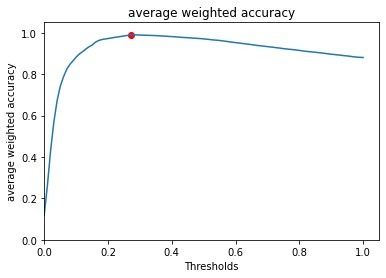

courbe accuracy pour chaques étiquettes : val
---------------------------------------


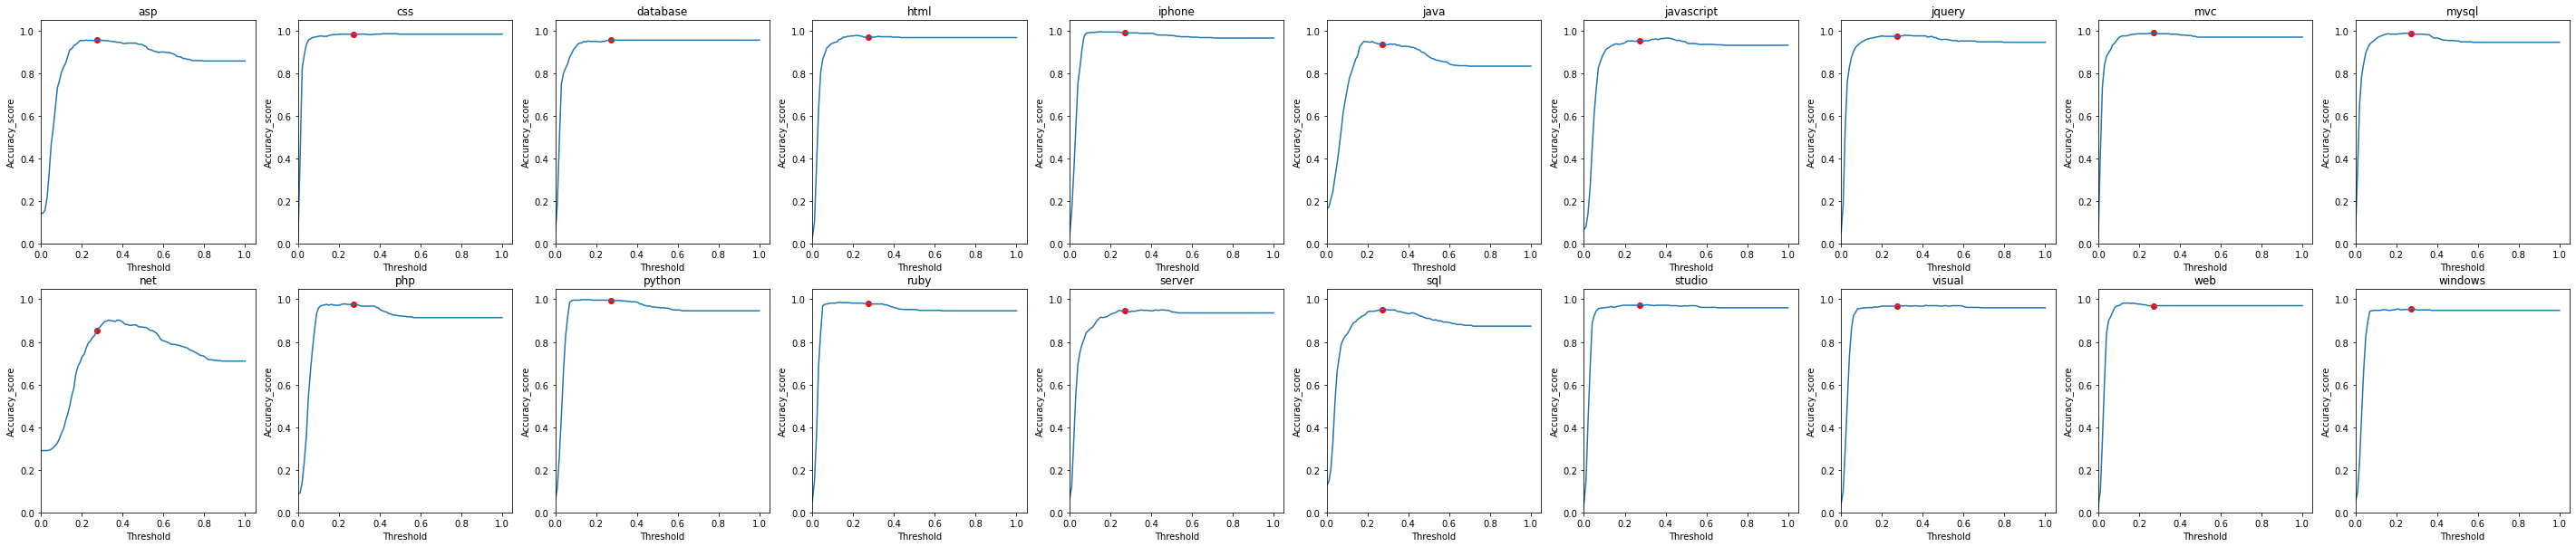

with threshold =  0.33333333333333337
best average accuracy weighted score =  0.9498319783197833


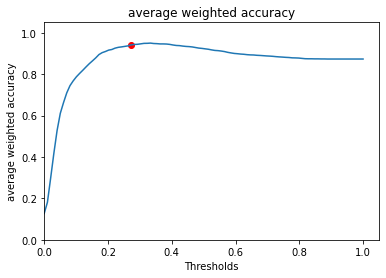

courbe jaccard : train
--------------
with threshold =  0.27272727272727276
best jaccard score =  0.9131881358124909


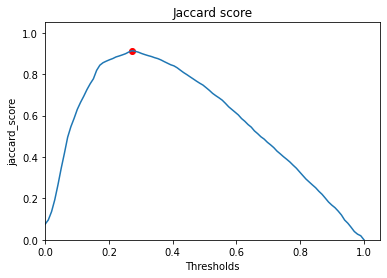

courbe jaccard : val
--------------
with threshold =  0.33333333333333337
best jaccard score =  0.6417910201113487


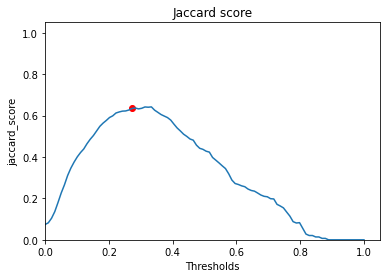

matrice de confusion : train
--------------------


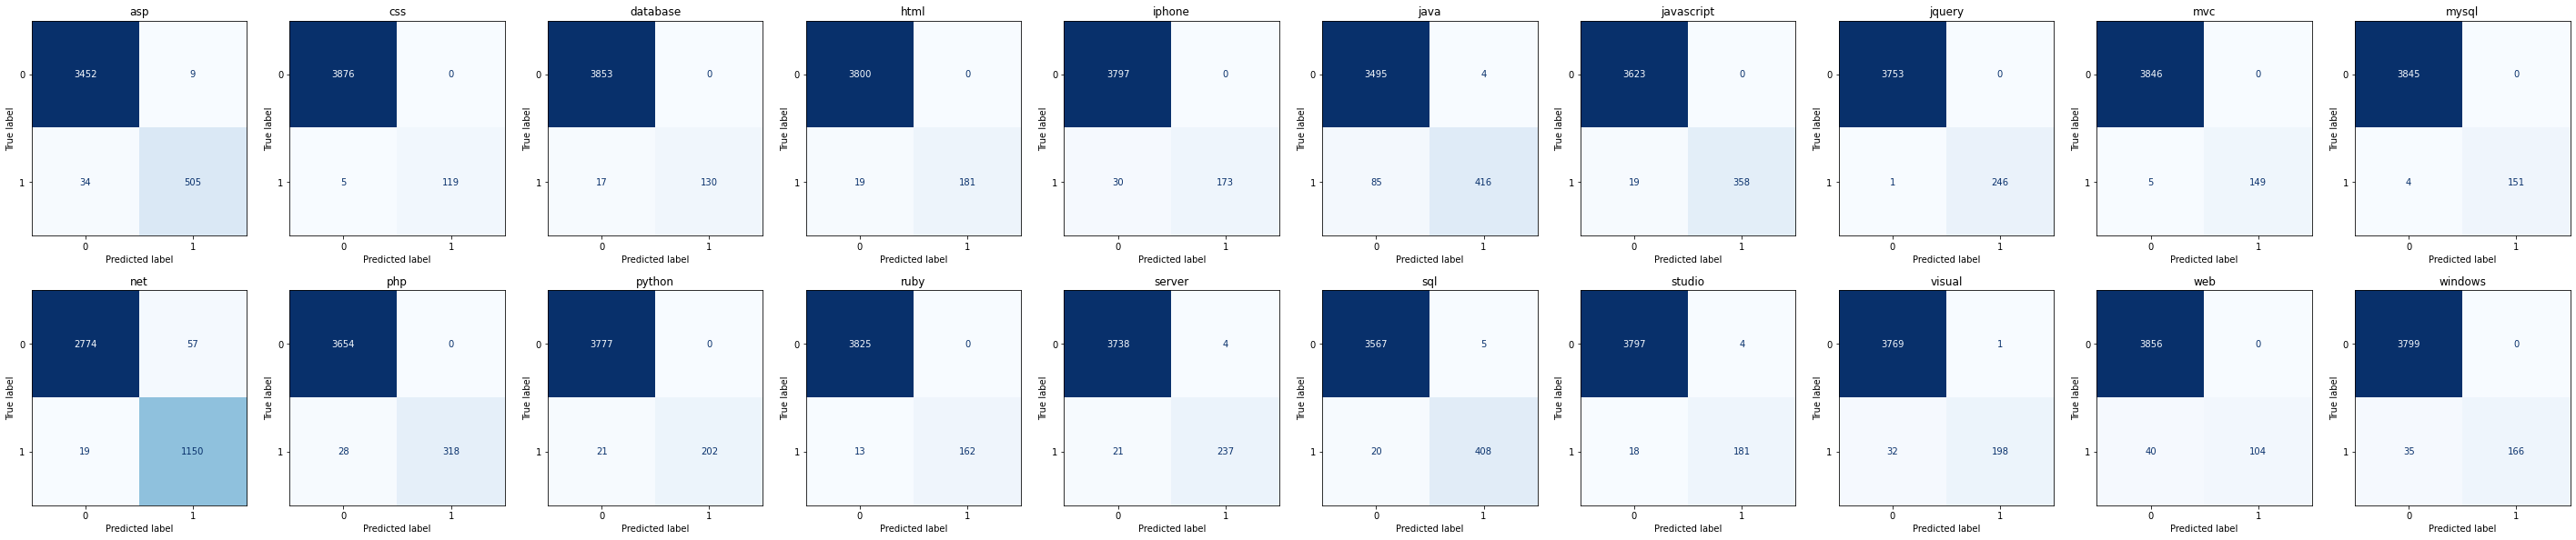

matrice de confusion : val
--------------------


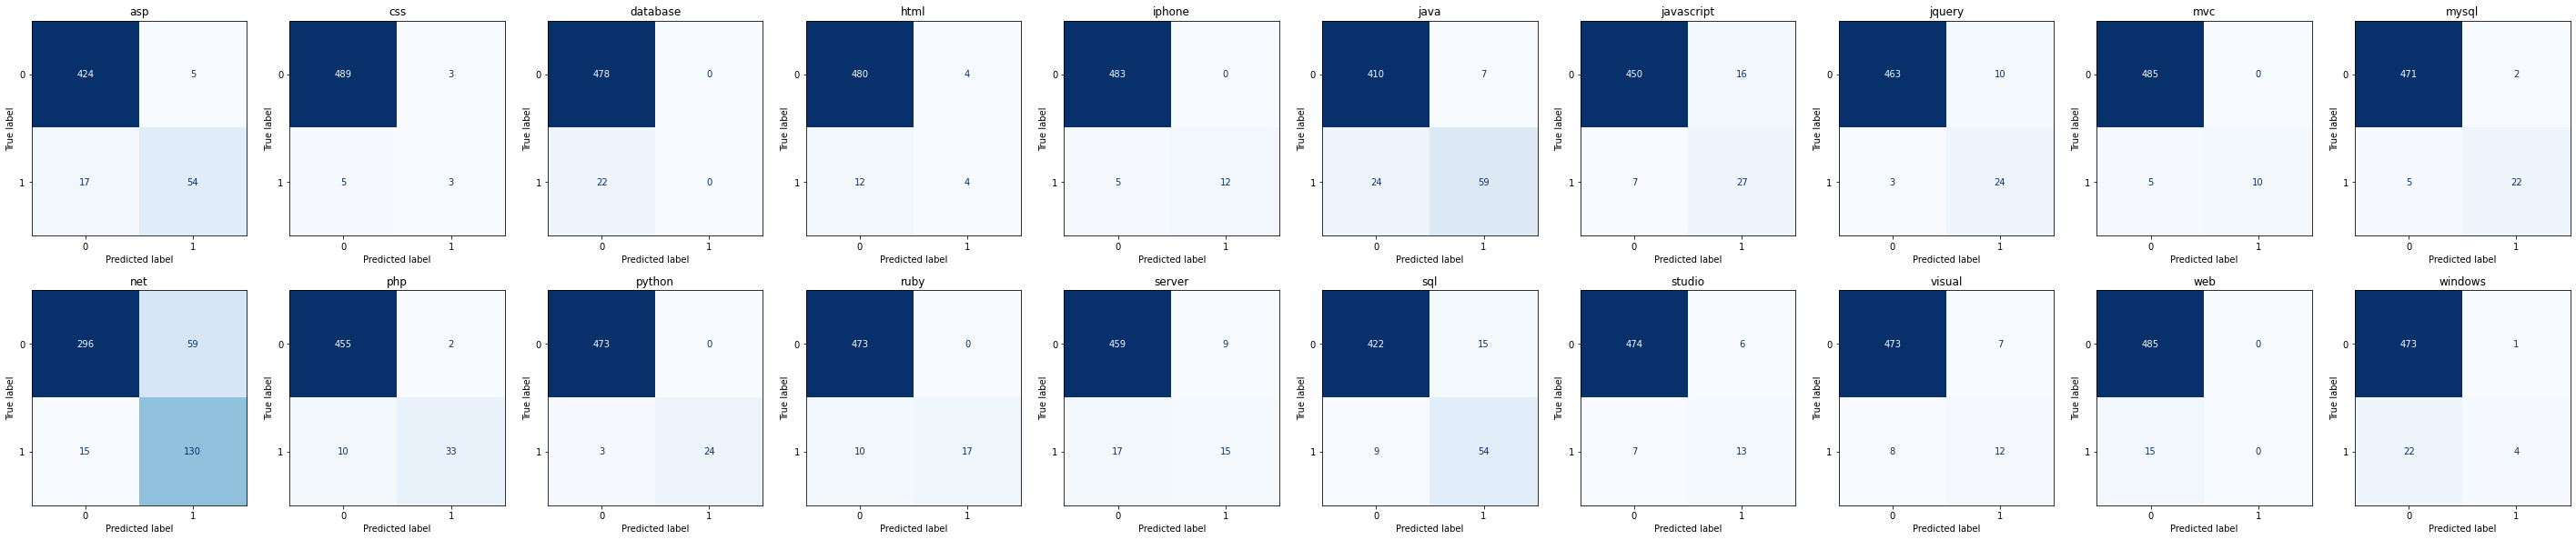

In [51]:
plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=threshold)

**Adaboost**

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

ada_boost = AdaBoostClassifier()
ada_boost = MultiOutputClassifier(ada_boost)

estimator__n_estimators = np.arange(start = 50, stop = 100, step=10)

n_jobs=[4]

hyperparameters = dict(estimator__n_estimators = estimator__n_estimators,
                       n_jobs=n_jobs
                      )

rscv_ada_boost = RandomizedSearchCV(ada_boost, hyperparameters, n_iter = 8, cv=KFold(5,shuffle=True, random_state=random_state), verbose=2 , random_state=random_state, scoring=scoring)

rscv_ada_boost.fit(X_train_tfidf, y_train)

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=8. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............estimator__n_estimators=50, n_jobs=4; total time=   3.5s
[CV] END ...............estimator__n_estimators=50, n_jobs=4; total time=   3.5s
[CV] END ...............estimator__n_estimators=50, n_jobs=4; total time=   3.6s
[CV] END ...............estimator__n_estimators=50, n_jobs=4; total time=   3.5s
[CV] END ...............estimator__n_estimators=50, n_jobs=4; total time=   3.5s
[CV] END ...............estimator__n_estimators=60, n_jobs=4; total time=   4.2s
[CV] END ...............estimator__n_estimators=60, n_jobs=4; total time=   4.2s
[CV] END ...............estimator__n_estimators=60, n_jobs=4; total time=   4.2s
[CV] END ...............estimator__n_estimators=60, n_jobs=4; total time=   4.3s
[CV] END ...............estimator__n_estimators=60, n_jobs=4; total time=   4.2s
[CV] END ...............estimator__n_estimators=70, n_jobs=4; total time=   4.9s
[CV] END ...............estimator__n_estimators=7

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=MultiOutputClassifier(estimator=AdaBoostClassifier()),
                   n_iter=8,
                   param_distributions={'estimator__n_estimators': array([50, 60, 70, 80, 90]),
                                        'n_jobs': [4]},
                   random_state=42,
                   scoring=make_scorer(scorer_neg_hamming_loss, needs_proba=True),
                   verbose=2)

In [53]:
rscv_ada_boost.best_params_

{'n_jobs': 4, 'estimator__n_estimators': 70}

In [54]:
rscv_ada_boost.cv_results_

{'mean_fit_time': array([3.22682514, 3.83895354, 4.50260715, 5.16499825, 5.75681438]),
 'std_fit_time': array([0.04648392, 0.04047151, 0.02154022, 0.06188077, 0.07814796]),
 'mean_score_time': array([0.41222568, 0.47270904, 0.52989879, 0.59986148, 0.65665226]),
 'std_score_time': array([0.00320497, 0.00620999, 0.00268252, 0.00554369, 0.00373845]),
 'param_n_jobs': masked_array(data=[4, 4, 4, 4, 4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_estimator__n_estimators': masked_array(data=[50, 60, 70, 80, 90],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_jobs': 4, 'estimator__n_estimators': 50},
  {'n_jobs': 4, 'estimator__n_estimators': 60},
  {'n_jobs': 4, 'estimator__n_estimators': 70},
  {'n_jobs': 4, 'estimator__n_estimators': 80},
  {'n_jobs': 4, 'estimator__n_estimators': 90}],
 'split0_test_score': array([-0.0413125, -0.0411875, -0.0

In [55]:
y_score_train = rscv_ada_boost.best_estimator_.predict_proba(X_train_tfidf)
y_pred_train = rscv_ada_boost.best_estimator_.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'ada_boost_on_train'))

In [56]:
y_score_val = rscv_ada_boost.best_estimator_.predict_proba(X_val_tfidf)
y_pred_val = rscv_ada_boost.best_estimator_.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'ada_boost_on_val'))

In [57]:
threshold = get_threshold(y_train,y_score_train) 

courbe neg hamming loss : train
-----------------------
with threshold =  0.494949494949495
best neg_hamming_loss =  -0.0215375


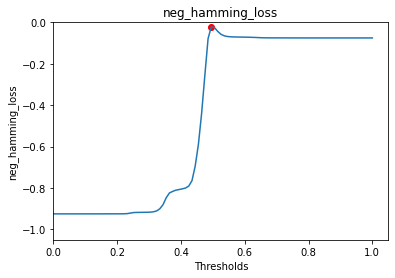

courbe neg hamming loss : val
-----------------------
with threshold =  0.5050505050505051
best neg_hamming_loss =  -0.0401


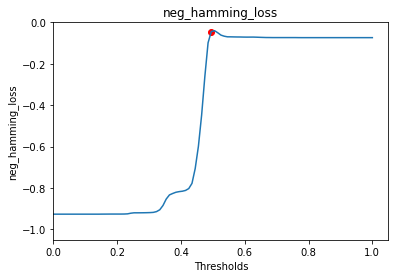

courbe ROC pour chaques étiquettes : train
----------------------------------


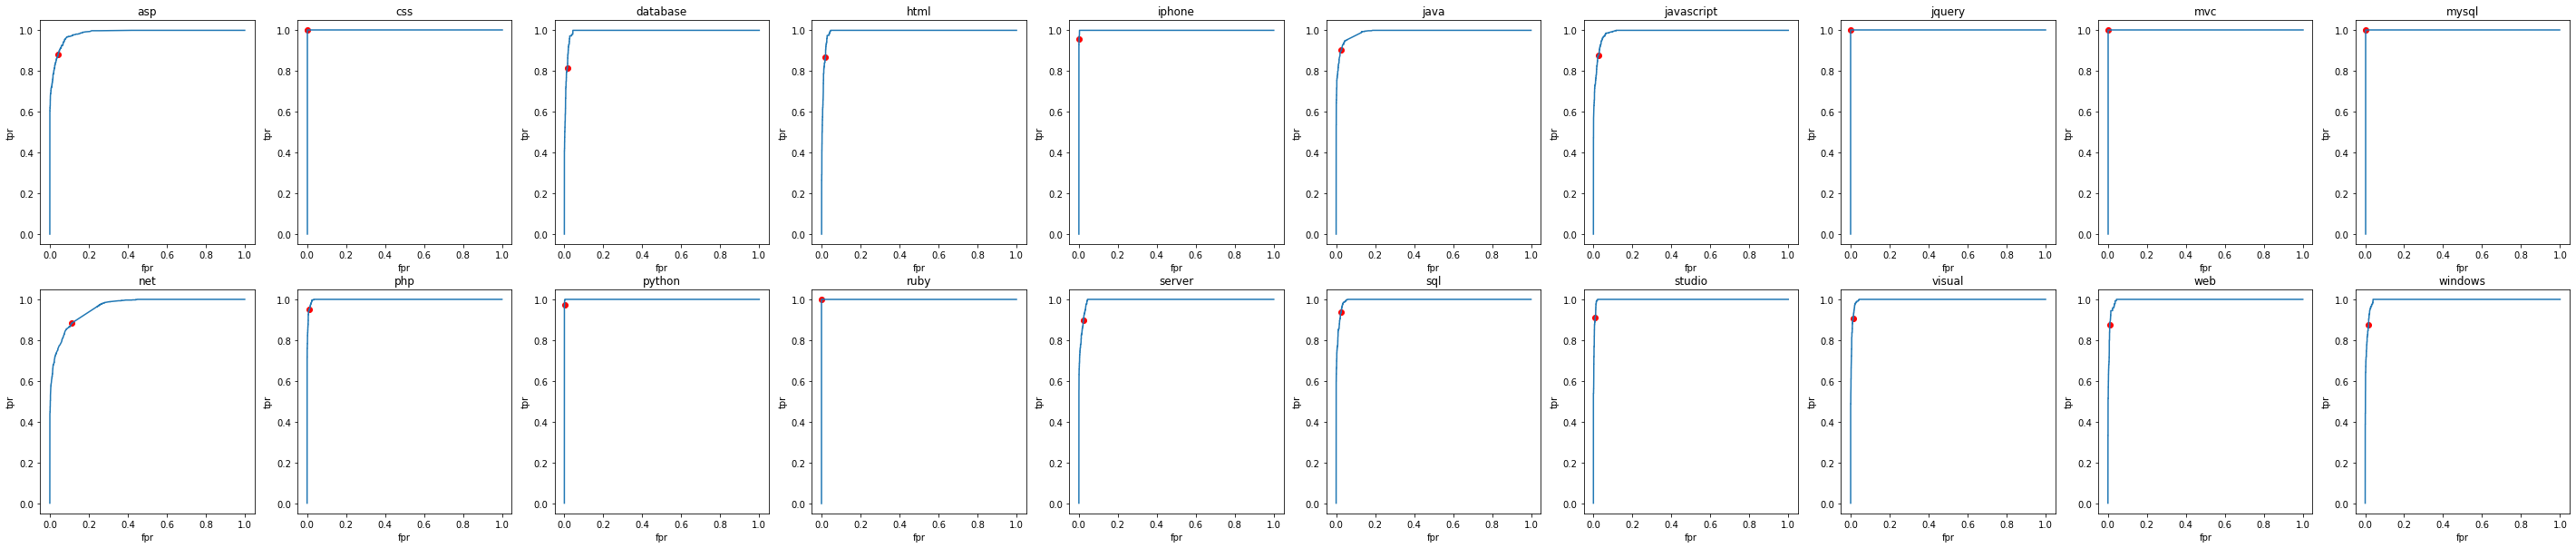

courbe ROC pour chaques étiquettes : val
----------------------------------


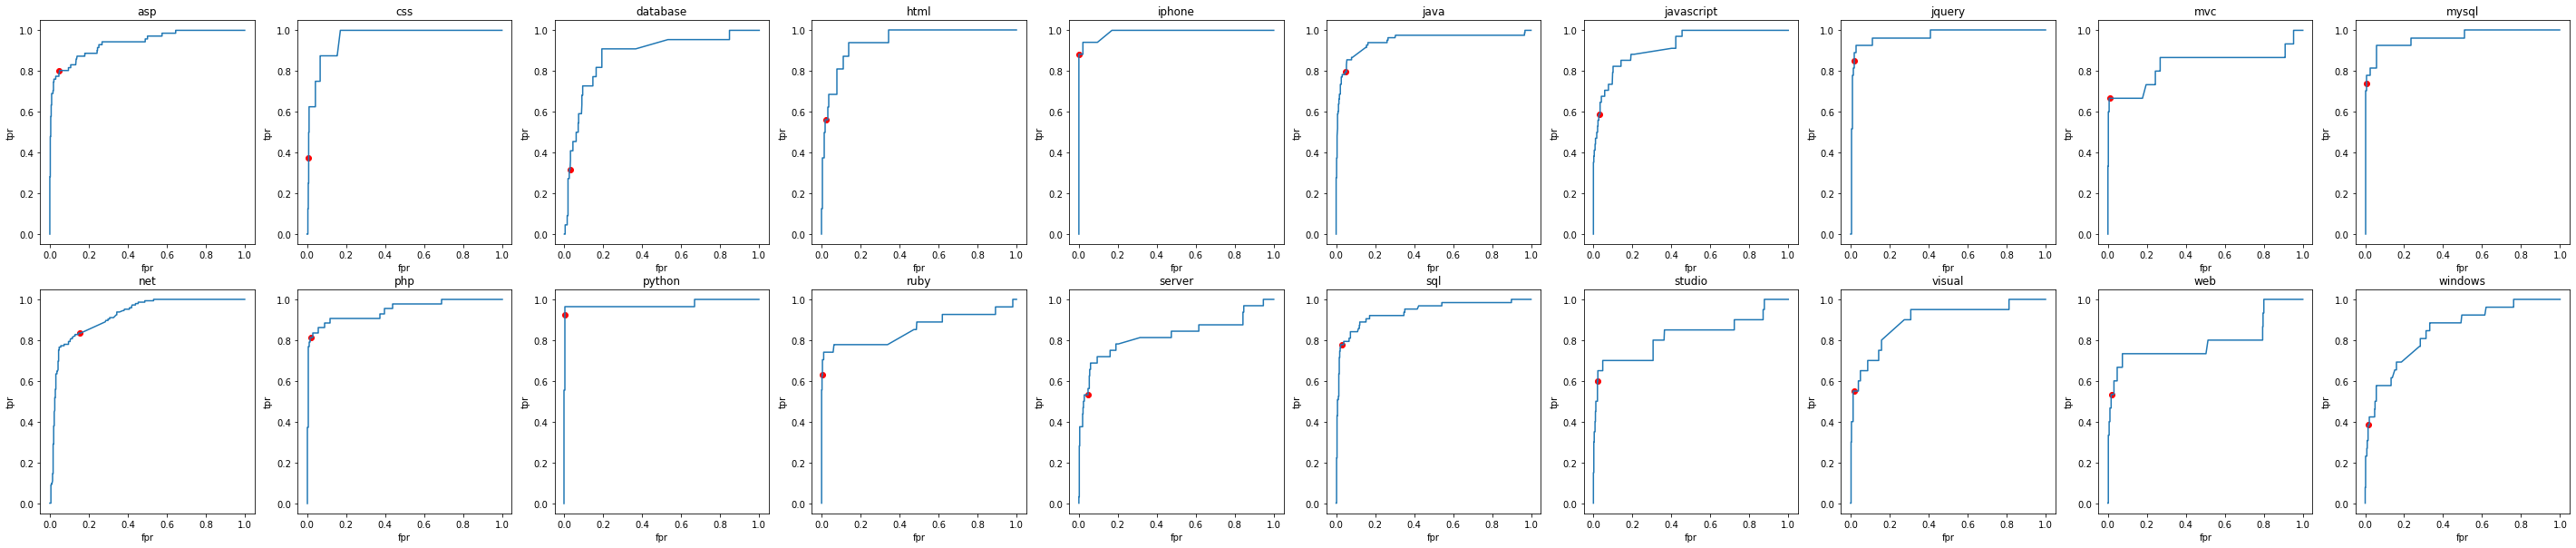

courbe precision-recall pour chaques étiquettes : train
-----------------------------------------------


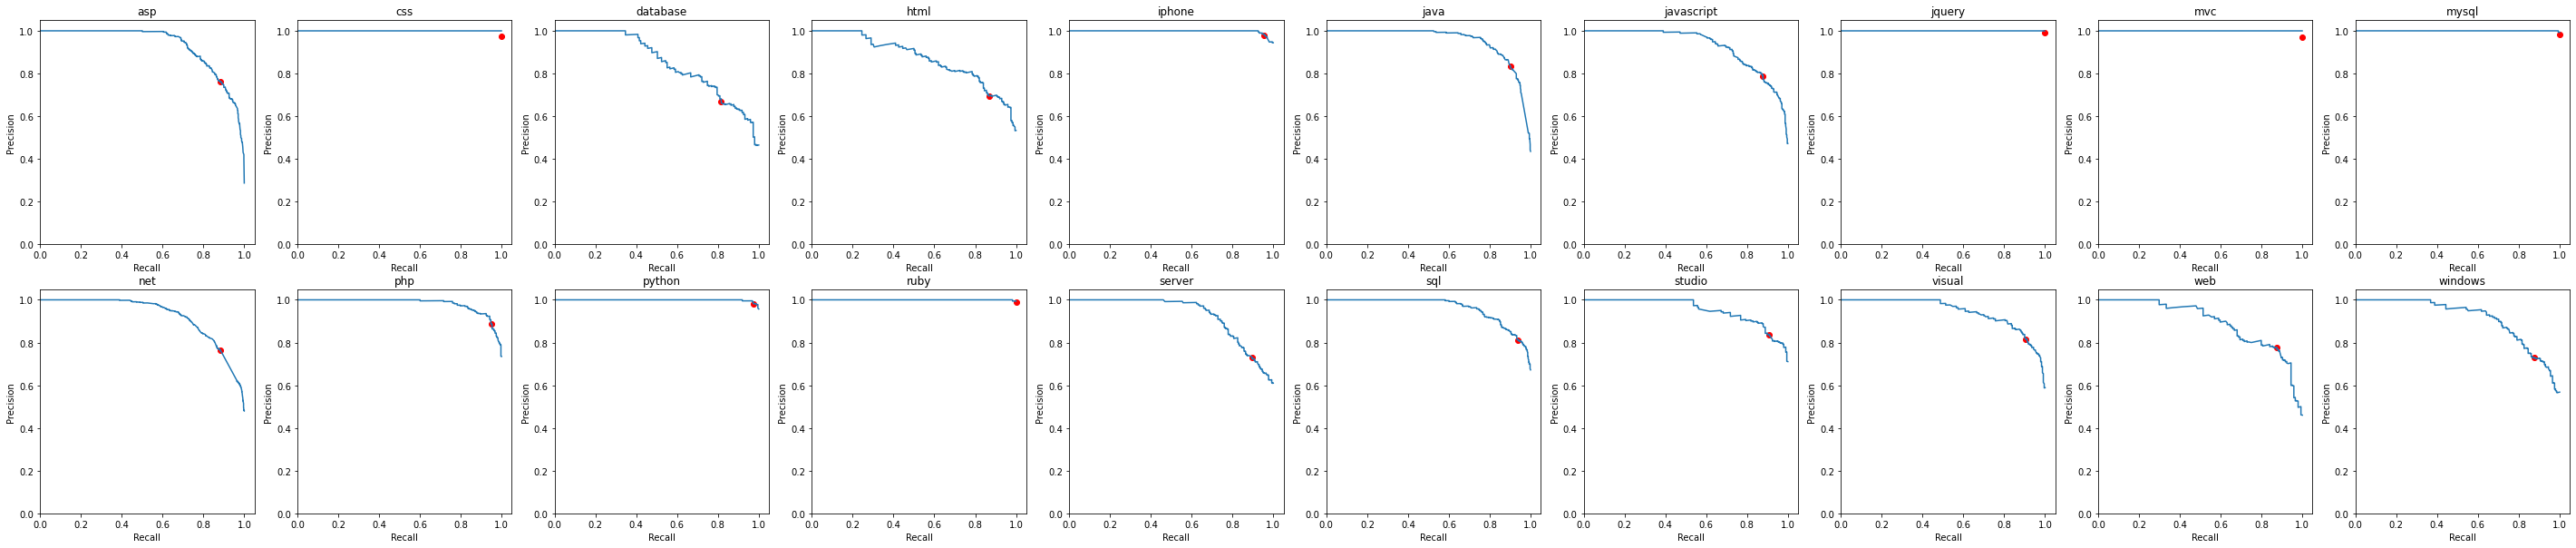

courbe precision-recall pour chaques étiquettes : val
-----------------------------------------------


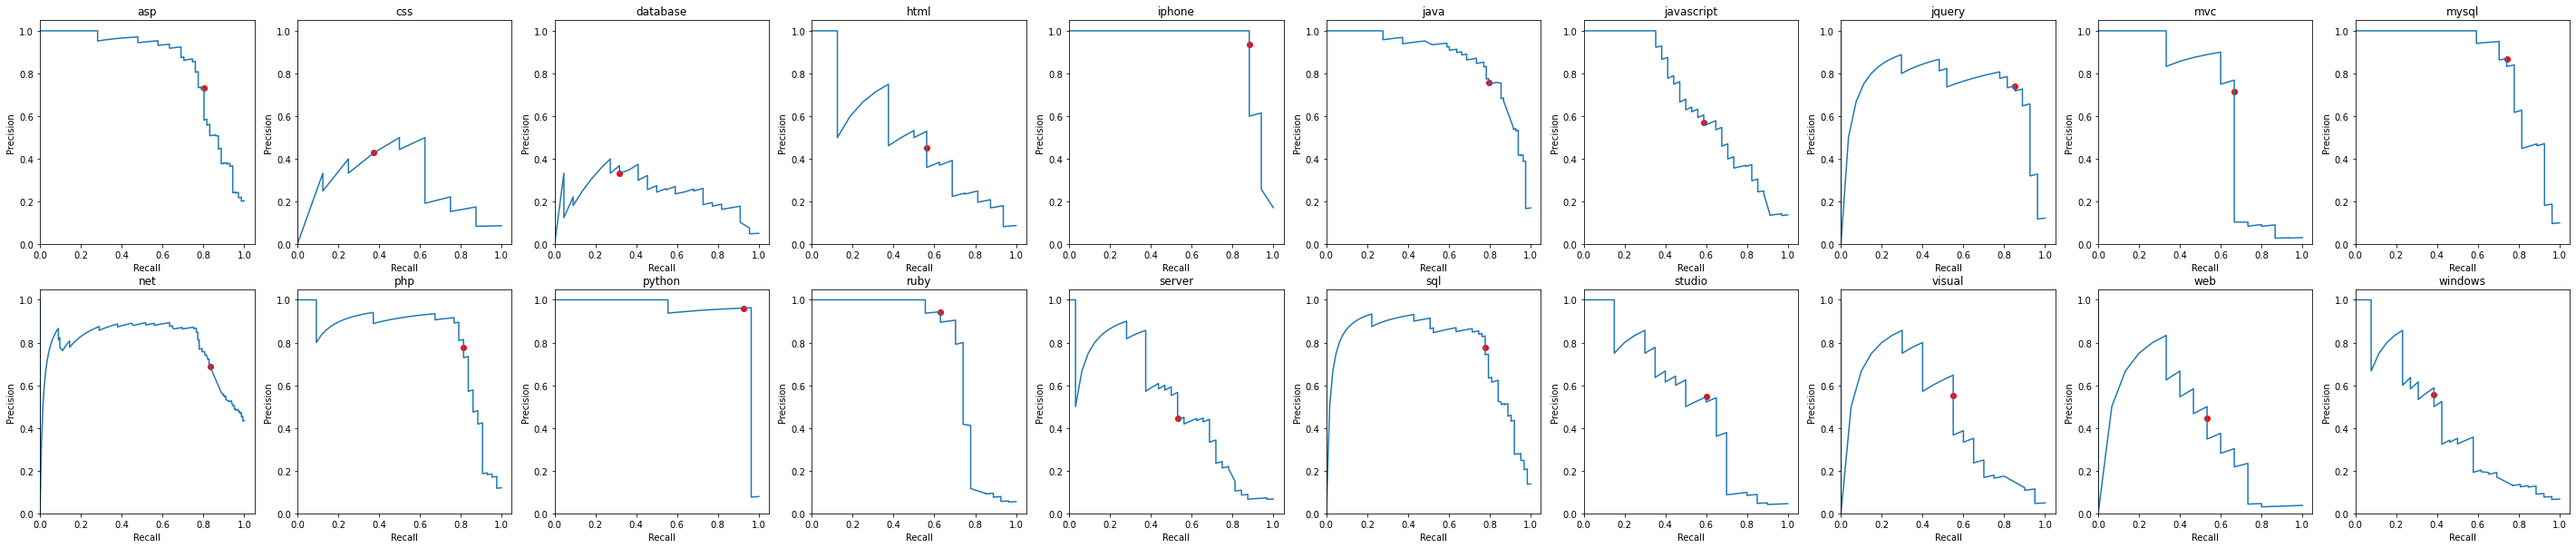

courbe accuracy pour chaques étiquettes : train
---------------------------------------


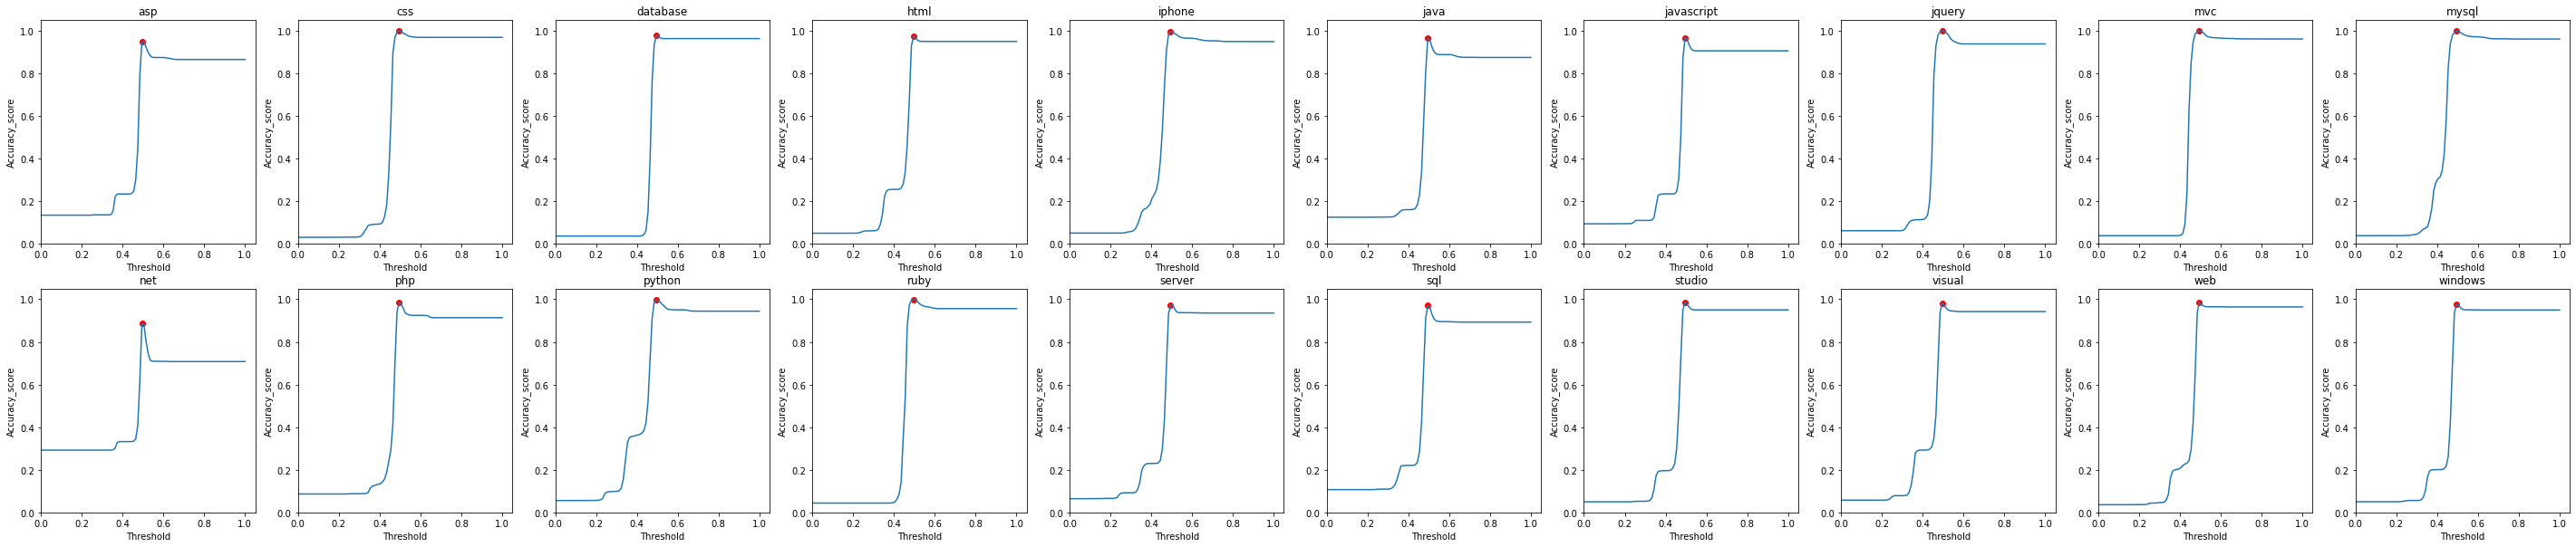

with threshold =  0.494949494949495
best average accuracy weighted score =  0.9601766196013288


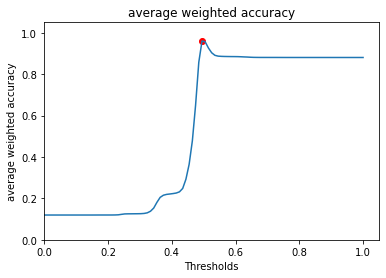

courbe accuracy pour chaques étiquettes : val
---------------------------------------


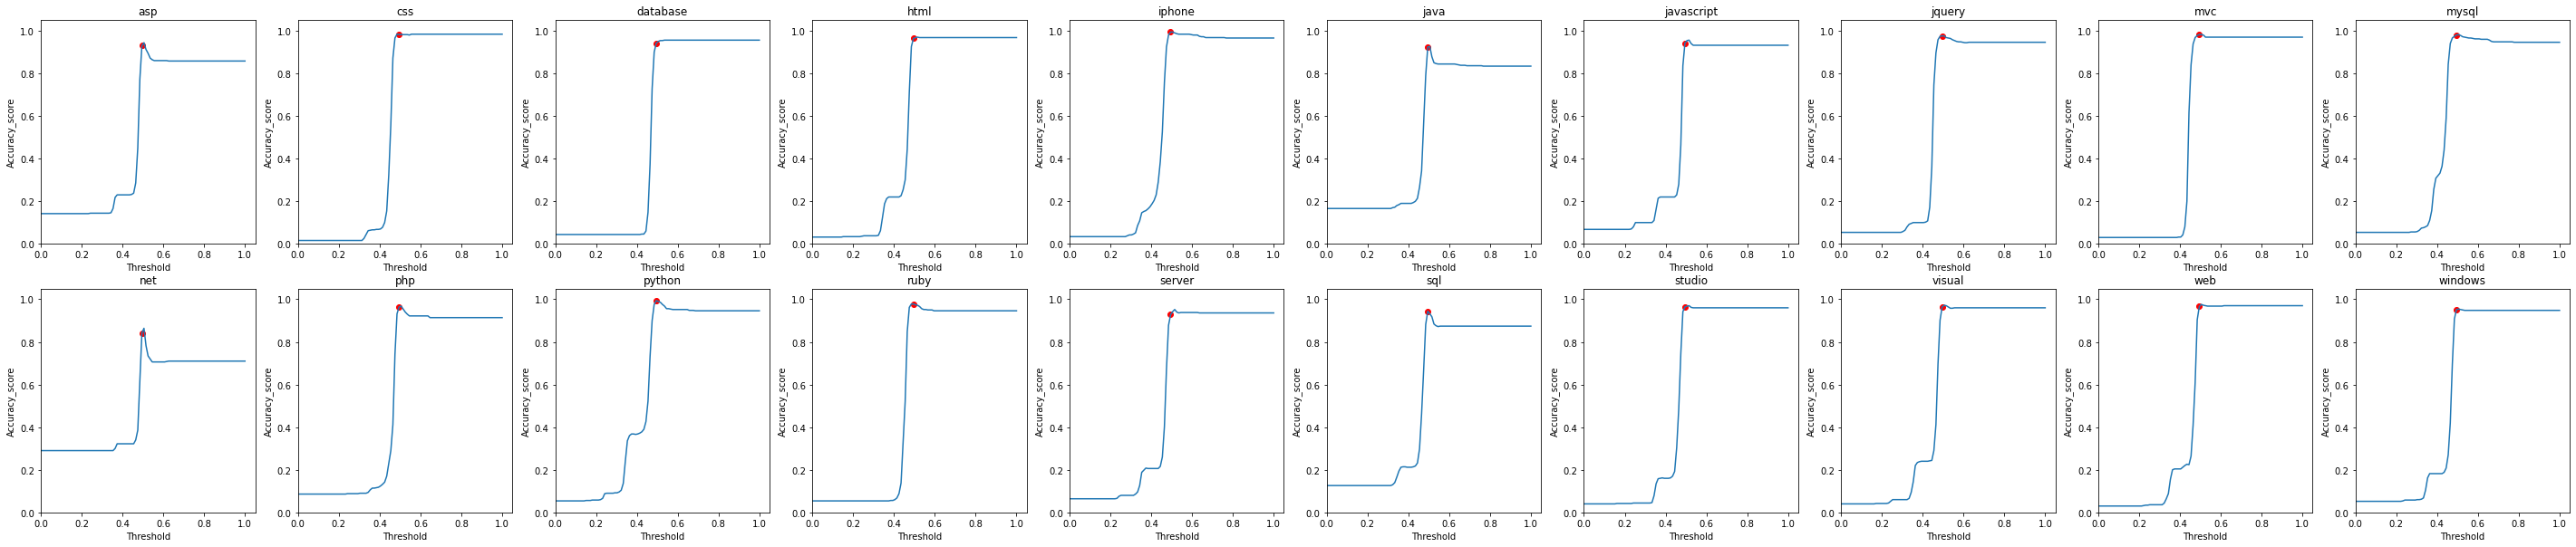

with threshold =  0.5050505050505051
best average accuracy weighted score =  0.9377940379403793


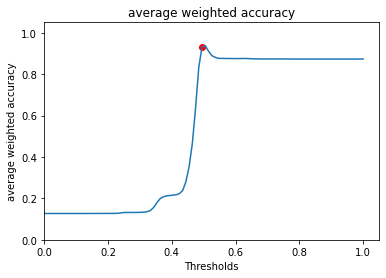

courbe jaccard : train
--------------
with threshold =  0.494949494949495
best jaccard score =  0.7654121982064387


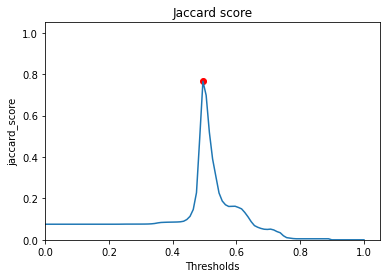

courbe jaccard : val
--------------
with threshold =  0.494949494949495
best jaccard score =  0.5628732050892223


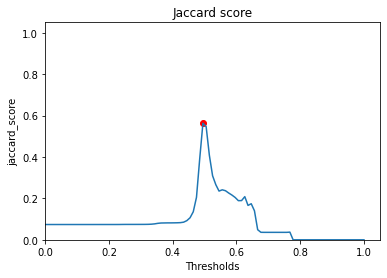

matrice de confusion : train
--------------------


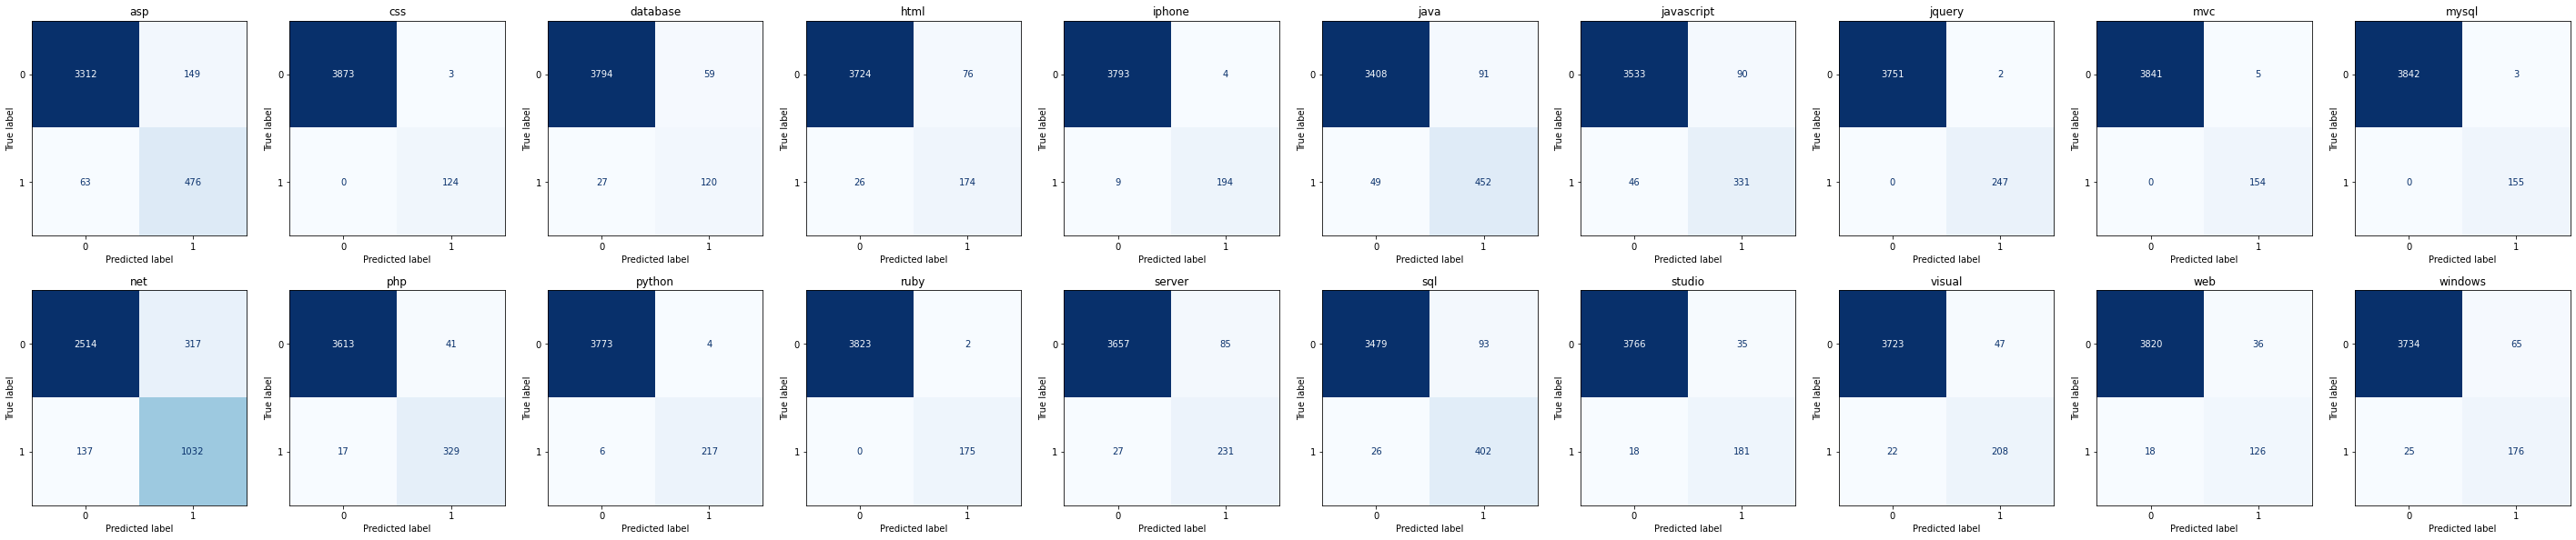

matrice de confusion : val
--------------------


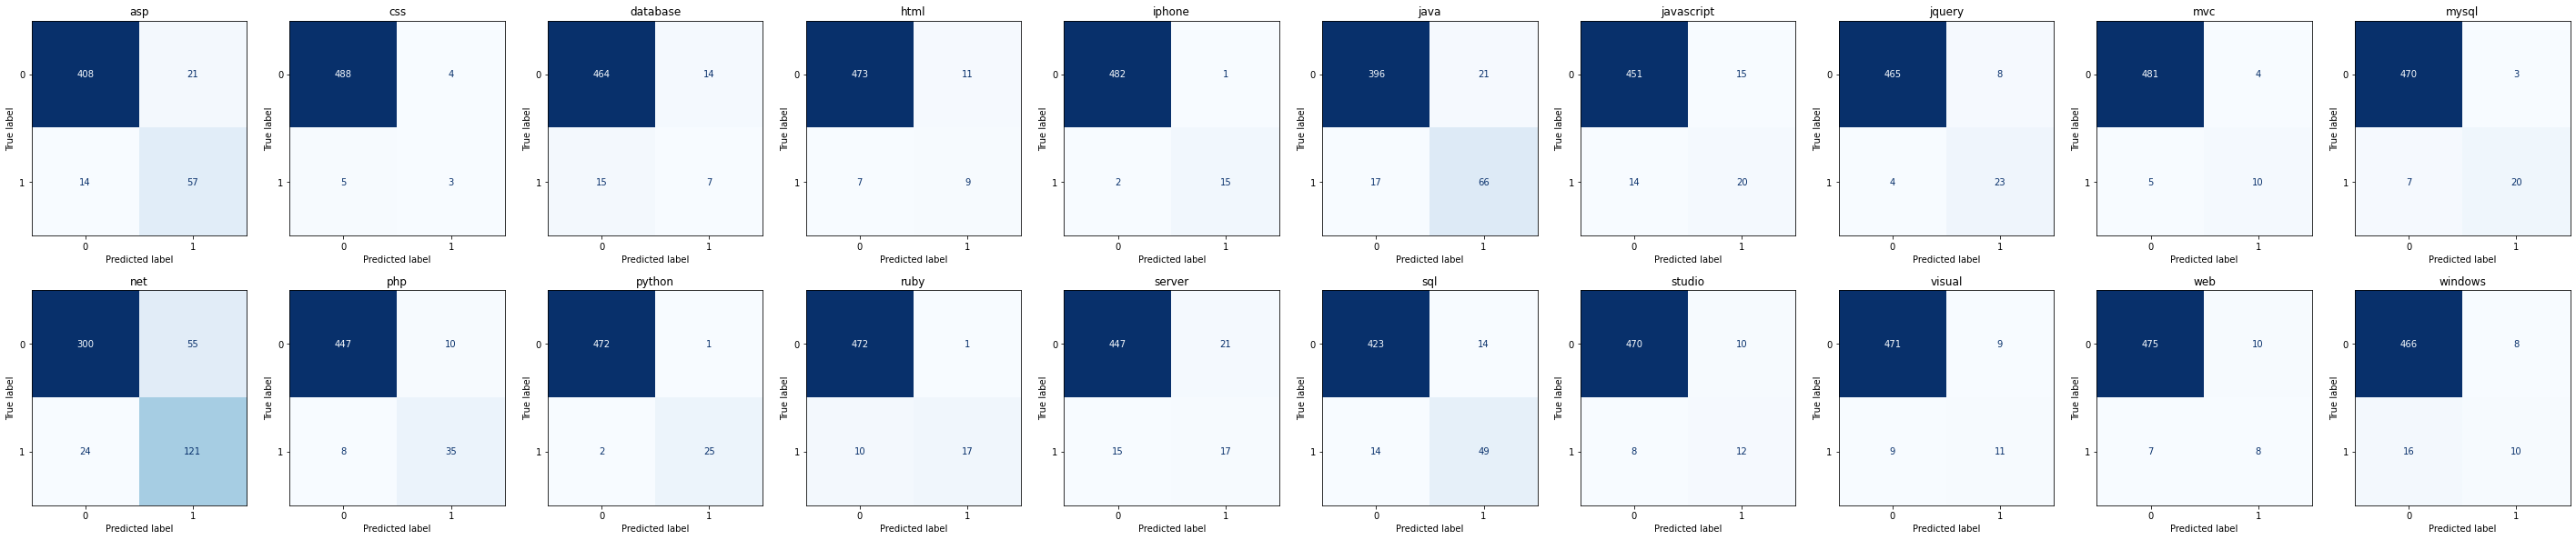

In [58]:
plot_all_graphs(y_train,y_val,y_score_train,y_score_val,threshold=threshold)

**Reduire X ?**

In [66]:
"""from sklearn.feature_selection import SelectFromModel

rscv_random_forest.best_estimator_.feature_importances_

X_train_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_train_tfidf)
X_val_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_val_tfidf)
X_test_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_test_tfidf)"""

'from sklearn.feature_selection import SelectFromModel\n\nrscv_random_forest.best_estimator_.feature_importances_\n\nX_train_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_train_tfidf)\nX_val_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_val_tfidf)\nX_test_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_test_tfidf)'

**rapport de Classification**

<AxesSubplot:title={'center':'Train - Rapport de classification'}>

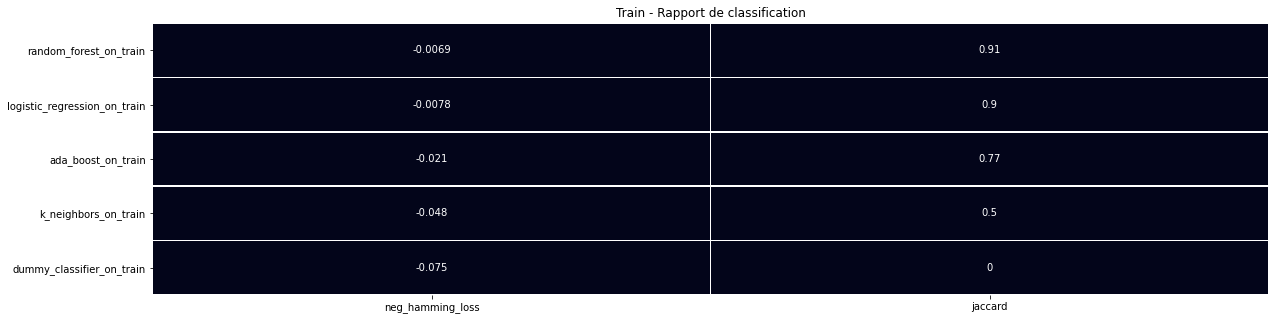

In [60]:
cr = classification_report[classification_report.index.str.contains('train$')].sort_values(by=['neg_hamming_loss'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de classification'}>

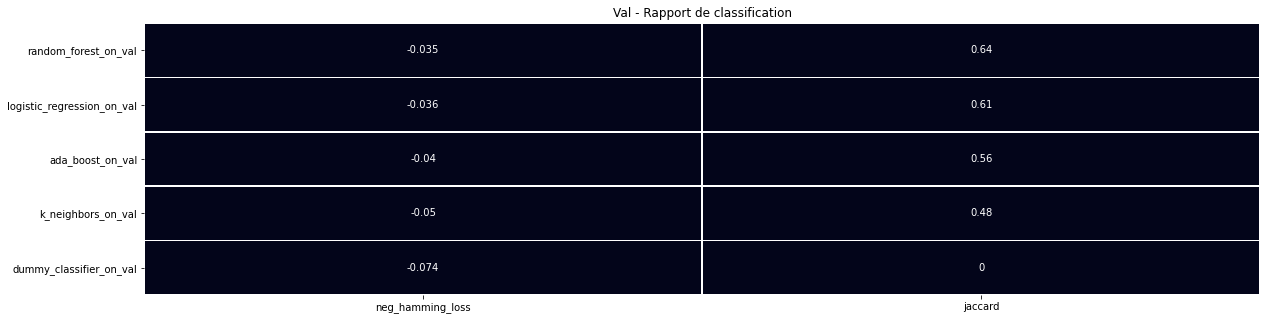

In [61]:
cr = classification_report[classification_report.index.str.contains('val$')].sort_values(by=['neg_hamming_loss'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**fonction pour api prediction**

In [67]:
# retourne les étiquettes pour les predictions
def get_labels(predictions, labels):
    preds = []
    for prediction in predictions:
        pred = []
        for i, is_label in enumerate(prediction):
            if is_label == 0:
                pass
            else :
                pred.append(labels[i])
        preds.append(pred)
    return preds
        
get_labels(y_pred_val, labels=tags.columns.tolist())

[['studio', 'visual'],
 ['php'],
 ['asp', 'net'],
 ['net'],
 ['net'],
 ['java'],
 [],
 ['asp', 'server', 'sql'],
 ['php'],
 ['mysql', 'sql'],
 [],
 ['web'],
 ['studio', 'visual'],
 ['server', 'windows'],
 ['python'],
 ['asp', 'javascript', 'net'],
 ['asp', 'net'],
 ['asp', 'net', 'web'],
 ['jquery'],
 ['net', 'studio'],
 [],
 [],
 ['asp', 'mvc', 'net'],
 ['ruby', 'studio'],
 ['javascript', 'jquery'],
 ['asp', 'net'],
 ['java'],
 ['mysql'],
 ['server', 'sql'],
 ['net', 'studio', 'visual'],
 ['net'],
 ['jquery'],
 ['java'],
 ['iphone'],
 ['studio'],
 ['php'],
 ['iphone'],
 ['web'],
 [],
 ['web'],
 ['net'],
 ['javascript'],
 ['java', 'windows'],
 ['java'],
 ['asp', 'net'],
 ['css', 'html', 'javascript'],
 ['database', 'sql'],
 ['java'],
 [],
 ['net', 'sql'],
 [],
 ['asp', 'net'],
 ['asp', 'javascript', 'net'],
 [],
 ['net'],
 [],
 [],
 ['net'],
 [],
 ['php'],
 [],
 ['windows'],
 [],
 ['iphone'],
 ['asp', 'net', 'visual', 'windows'],
 ['database', 'java'],
 ['net'],
 ['net'],
 ['javascript

In [63]:
y_pred_val.shape

(500, 20)

**export modele pour api prediction**

In [64]:
import pickle

#model
filename = 'logistic_regression.sav'
pickle.dump(gscv_logistic_regression, open(filename, 'wb'))

#vectorizer
filename = 'multi_tfidf_vectorizer.sav'
pickle.dump(multi_tfidf_vectorizer, open(filename, 'wb'))

In [65]:
#labels
my_labels = pd.Series(tags.columns.tolist())
my_labels.to_csv("data/my_labels.csv", index=False)